# Analysez des données de systèmes éducatifs

## Introduction

### Objectifs

- Valider la qualité de ce jeu de données :
  - Comporte-t-il beaucoup de données manquantes ?
  - Comporte-t-il beaucoup de données dupliquées ?
- Décrire les informations contenues dans le jeu de données :
  - Nombre de colonnes ?
  - Nombre de lignes ?
- Sélectionner les informations qui semblent pertinentes pour répondre à la problématique :
  - Quelles sont les colonnes contenant des informations qui peuvent être utiles pour répondre à la problématique de l’entreprise ?
- Déterminer des ordres de grandeurs des indicateurs statistiques classiques pour les différentes zones géographiques et pays du monde :
  - Moyenne
  - Médiane
  - Écart-type par pays / par continent ou bloc géographique

### Problématique

__Ce jeu de donnée peut-il informer les décisions d'ouverture vers de nouveaux pays pour une start-up qui propose des contenus de formation en ligne pour un public de niveau lycée et université ?__

## Setup

### Install Python

From [here](https://www.python.org/downloads/)

### Create a virtual environment

Via VSC : Cmd + Shft + P -> 'Python: Create Environment' -> Venv -> Choose Python to use as base
Created venv is activated automatically.

### Install jupyter

Send `pip install notebook` in a terminal.

### Launch jupyter notebook

Send `jupyter notebook` to open jupyter.
Create a new notebook.

### Install pandas

In [1]:
# install in virtual environment
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Check the version of the installed package

In [2]:
%pip list # get the list of all packages installed, then find pandas -> version is 2.2.3

Note: you may need to restart the kernel to use updated packages.


In [3]:
# other method to return pandas version directly
%pip freeze | findstr pandas

pandas==2.2.3
Note: you may need to restart the kernel to use updated packages.


[This website](https://pandas.pydata.org/) tells us that 2.2.3 is the latest version.

## Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import statsmodels.api as sm
import missingno as msno
from typing import Optional, Callable
import random

In [5]:
ed_stats_country = pd.read_csv('Projet+Python_Dataset_Edstats_csv/EdStatsCountry.csv')
ed_stats_series = pd.read_csv('Projet+Python_Dataset_Edstats_csv/EdStatsSeries.csv')
ed_stats_country_series = pd.read_csv('Projet+Python_Dataset_Edstats_csv/EdStatsCountry-Series.csv')
ed_stats_foot_note = pd.read_csv('Projet+Python_Dataset_Edstats_csv/EdStatsFootNote.csv')
ed_stats_data = pd.read_csv('Projet+Python_Dataset_Edstats_csv/EdStatsData.csv')

## Explore data

In complement to standard methods (like `df.info()`, `df.describe()`, etc...) the function `get_df_variables_info()` will be used to retrieve formatted info on all columns of each dataframe.

In [6]:
# Automatically get info about each variable of a given dataframe.
def get_df_variables_info(df: pd.DataFrame):
    # Set the seaborn theme for plots
    sns.set_theme(palette="pastel")
    
    # Get the shape of the DataFrame
    (n_rows, n_columns) = df.shape
    df_info = f"""
Number of rows: {n_rows}
Number of columns: {n_columns}"""

    # Sensitivity for top common values (15%). Used to highlight if most common values actually represent a significant proportion of the values.
    top_common_values_sensitivity = 0.15
    
    # Iterate over each column in the DataFrame
    for i, col in enumerate(df.columns):
        # Count occurrences of each value in the column
        value_counts = df.value_counts(col)
        # Get the column type
        col_type = df[col].dtype
        # Count null values in the column
        n_null_values = df.isnull().sum()[col]
        # Count unique values
        n_unique_values = len(value_counts)
        # Count non-null values
        n_values = n_rows - n_null_values
        # Get the mode of the column
        mode = df[col].mode().values
        
        # Print basic information about the column
        df_info += f"""
{"*"*20}
column name: {col}
type: {col_type}
missing value rate: {round(n_null_values/n_rows*100, 2)}%"""

        # Proceed if there are non-null values
        if n_values != 0:
            df_info += f"""
unique values: {n_unique_values} out of {n_values} non-null values ({round(100-n_unique_values/n_values*100, 2)}% of duplicates)"""

            # If the column has fewer than 6 unique values, print their counts
            if n_unique_values < 6:
                for i, v in enumerate(value_counts):
                    df_info += f"""
        - {value_counts.index[i]} ({v} occurrences)"""

            # If the column type is numeric, gather statistical info
            if np.issubdtype(col_type, np.number):
                # Calculate quantiles, ignoring NaN values
                quantiles = np.quantile(df[col].dropna(), np.array([0.0, 0.25, 0.5, 0.75, 1.0]))
                mean = round(df[col].mean(), 2)
                
                # Print statistical summary
                df_info += f"""
mean: {mean}
min: {df[col].min()}
max: {df[col].max()}
median: {df[col].median()}
std: {round(df[col].std(ddof=1), 2)}"""

                # Create a boxplot for the column
                fig, ax = plt.subplots(figsize=(9, 3))
                ax.boxplot(df[col].dropna(), vert=False, showmeans=True, 
                           meanprops={"markerfacecolor":'white', "marker":'o', "markeredgecolor":'firebrick', "markersize":8})

                # Customize the plot
                ax.grid(visible=False)

                # Draw quantiles as vertical lines
                ax.vlines(quantiles, [0]*quantiles.size, [1]*quantiles.size, color='chocolate', ls=':', lw=1, zorder=0)
                ax.set_ylim(0.5, 1.5)
                ax.set_yticklabels([])  # Hide y-tick labels
                ax.set_xticks(quantiles)  # Set x-ticks to quantiles

                # Annotate mean value next to the mean marker
                ax.text(mean, 1.1, f'Mean: {round(mean, 2)}', color='firebrick', ha='center', fontsize=10)

                # Set the plot title
                plt.title(f"Distribution of column '{col}'")
                plt.show()

            # Print the mode of the column
            df_info += f"""
mode: {", ".join(str(v) if i < 3 else f"... ({len(mode)} elements)" for i, v in enumerate(mode[:min(len(mode), 4)]))} ({value_counts.values[0]} occurrence(s))"""

            # Calculate top common values based on sensitivity
            n_top_common_values = int(len(value_counts) * top_common_values_sensitivity)
            top_common_values = value_counts.values[:n_top_common_values]
            
            # Check if the top common values represent a significant proportion of the data
            if value_counts.quantile(1 - top_common_values_sensitivity) / value_counts.max() < 0.25 and n_top_common_values <= 10:
                sum_top_common_values = top_common_values.sum()
                top_common_values_prop = round(sum_top_common_values / n_values, 2)
                top_common_values_info = [f"{value_counts.index[i]} ({value})" for i, value in enumerate(top_common_values)]
                
                # Print additional comments on common values
                df_info += f"""
additional comment : First {n_top_common_values} unique values represent {top_common_values_prop * 100}% of total values : {', '.join(top_common_values_info)}"""
        else:
            # Inform if the column only contains null values
            df_info += f"""
This column only contains null values."""
        
        df_info += "\n"  # Newline for better readability between columns

    return df_info

### EdStatsCountry.csv

#### General info

In [7]:
ed_stats_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       241 non-null    object 
 1   Short Name                                         241 non-null    object 
 2   Table Name                                         241 non-null    object 
 3   Long Name                                          241 non-null    object 
 4   2-alpha code                                       238 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      145 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                                       214 non-null    object 
 9   WB-2 code 

In [8]:
ed_stats_country.head()

Country Code   Short Name   Table Name                     Long Name  \
0          ABW        Aruba        Aruba                         Aruba   
1          AFG  Afghanistan  Afghanistan  Islamic State of Afghanistan   
2          AGO       Angola       Angola   People's Republic of Angola   
3          ALB      Albania      Albania           Republic of Albania   
4          AND      Andorra      Andorra       Principality of Andorra   

  2-alpha code   Currency Unit  \
0           AW   Aruban florin   
1           AF  Afghan afghani   
2           AO  Angolan kwanza   
3           AL    Albanian lek   
4           AD            Euro   

                                       Special Notes  \
0  SNA data for 2000-2011 are updated from offici...   
1  Fiscal year end: March 20; reporting period fo...   
2  April 2013 database update: Based on IMF data,...   
3                                                NaN   
4                                                NaN   

                      Region          Income Group WB-2 code  ...  \
0  Latin America & Caribbean  High income: nonOECD        AW  ...   
1                 South Asia            Low income        AF  ...   
2         Sub-Saharan Africa   Upper middle income        AO  ...   
3      Europe & Central Asia   Upper middle income        AL  ...   
4      Europe & Central Asia  High income: nonOECD        AD  ...   

            IMF data dissemination standard  \
0                                       NaN   
1  General Data Dissemination System (GDDS)   
2  General Data Dissemination System (GDDS)   
3  General Data Dissemination System (GDDS)   
4                                       NaN   

                            Latest population census  \
0                                               2010   
1                                               1979   
2                                               1970   
3                                               2011   
4  2011. Population figures compiled from adminis...   

                             Latest household survey  \
0                                                NaN   
1  Multiple Indicator Cluster Survey (MICS), 2010/11   
2               Malaria Indicator Survey (MIS), 2011   
3       Demographic and Health Survey (DHS), 2008/09   
4                                                NaN   

   Source of most recent Income and expenditure data  \
0                                                NaN   
1            Integrated household survey (IHS), 2008   
2            Integrated household survey (IHS), 2008   
3  Living Standards Measurement Study Survey (LSM...   
4                                                NaN   

  Vital registration complete Latest agricultural census  \
0                         Yes                        NaN   
1                         NaN                    2013/14   
2                         NaN                       2015   
3                         Yes                       2012   
4                         Yes                        NaN   

  Latest industrial data Latest trade data Latest water withdrawal data  \
0                    NaN            2012.0                          NaN   
1                    NaN            2012.0                         2000   
2                    NaN               NaN                         2005   
3                 2010.0            2012.0                         2006   
4                    NaN            2006.0                          NaN   

  Unnamed: 31  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

[5 rows x 32 columns]

There are too many columns to get a decent overview of the values in all of them. Visual Studio Code extension "Data Wrangler" is used to have a better overview.

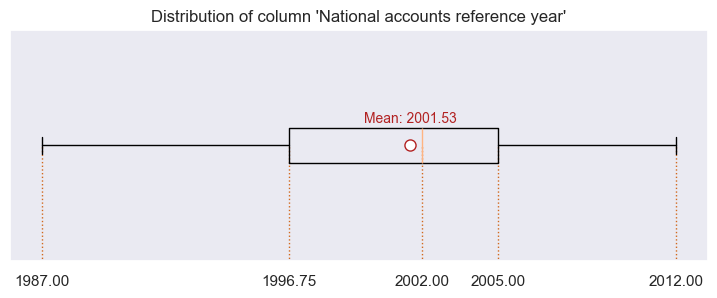

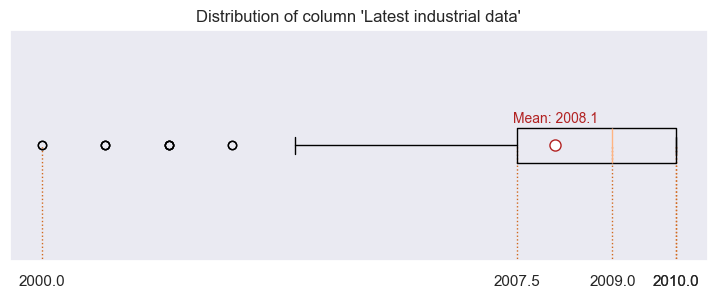

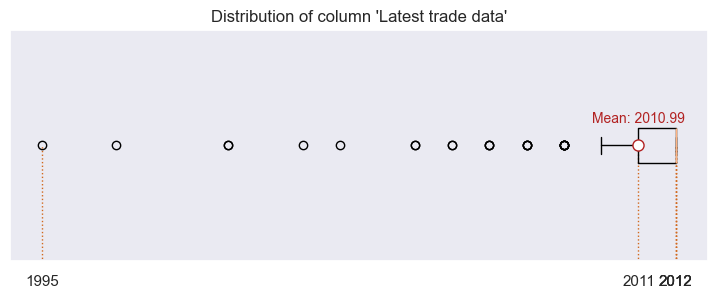


Number of rows: 241
Number of columns: 32
********************
column name: Country Code
type: object
missing value rate: 0.0%
unique values: 241 out of 241 non-null values (0.0% of duplicates)
mode: ABW, AFG, AGO, ... (241 elements) (1 occurrence(s))

********************
column name: Short Name
type: object
missing value rate: 0.0%
unique values: 241 out of 241 non-null values (0.0% of duplicates)
mode: Afghanistan, Albania, Algeria, ... (241 elements) (1 occurrence(s))

********************
column name: Table Name
type: object
missing value rate: 0.0%
unique values: 241 out of 241 non-null values (0.0% of duplicates)
mode: Afghanistan, Albania, Algeria, ... (241 elements) (1 occurrence(s))

********************
column name: Long Name
type: object
missing value rate: 0.0%
unique values: 241 out of 241 non-null values (0.0% of duplicates)
mode: American Samoa, Antigua and Barbuda, Arab Republic of Egypt, ... (241 elements) (1 occurrence(s))

********************
column name: 2-alpha 

In [9]:
print(get_df_variables_info(ed_stats_country))

#### Remove useless columns

In [10]:
# Get percentage of missing values for each column, in complement with info given by get_df_variables_info() function.
ed_stats_country.isna().mean()

Country Code                                         0.000000
Short Name                                           0.000000
Table Name                                           0.000000
Long Name                                            0.000000
2-alpha code                                         0.012448
Currency Unit                                        0.107884
Special Notes                                        0.398340
Region                                               0.112033
Income Group                                         0.112033
WB-2 code                                            0.004149
National accounts base year                          0.149378
National accounts reference year                     0.867220
SNA price valuation                                  0.182573
Lending category                                     0.402490
Other groups                                         0.759336
System of National Accounts                          0.107884
Alternat

In [11]:
# Columns "2-alpha code", "WB-2 code" and "Country Code" have the same purpose. 
# "Country Code" is the column with most data but let's wait until all csv files have been explored before determining the most relevant column.
# Column "Unnamed: 31" is empty, no need to keep it.

ed_stats_country.drop(columns=["Unnamed: 31"], inplace=True)

#### Fix dtypes

Here are the possible wrongly-assigned types:
- Column "National accounts base year" is of type "object". Converting it to numeric is not possible because some values are a combination of several years (for example "2002/03").
- Column "PPP survey year" is of type "object". Converting it to numeric is not possible because some values are strings (for example "Rolling").

#### Conclusion

The file EdStatsCountry.csv contains comprehensive data on 241 countries, including identification codes, names, economic indicators, most recent surveys and censuses and statistical information related to their financial and demographic profiles. This information aims to facilitate analysis of global economic conditions.

### EdStatsSeries.csv

#### General info

In [12]:
ed_stats_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Series Code                          3665 non-null   object 
 1   Topic                                3665 non-null   object 
 2   Indicator Name                       3665 non-null   object 
 3   Short definition                     2156 non-null   object 
 4   Long definition                      3665 non-null   object 
 5   Unit of measure                      0 non-null      float64
 6   Periodicity                          99 non-null     object 
 7   Base Period                          314 non-null    object 
 8   Other notes                          552 non-null    object 
 9   Aggregation method                   47 non-null     object 
 10  Limitations and exceptions           14 non-null     object 
 11  Notes from original source    

In [13]:
ed_stats_series.head()

Series Code       Topic  \
0  BAR.NOED.1519.FE.ZS  Attainment   
1     BAR.NOED.1519.ZS  Attainment   
2  BAR.NOED.15UP.FE.ZS  Attainment   
3     BAR.NOED.15UP.ZS  Attainment   
4  BAR.NOED.2024.FE.ZS  Attainment   

                                      Indicator Name  \
0  Barro-Lee: Percentage of female population age...   
1  Barro-Lee: Percentage of population age 15-19 ...   
2  Barro-Lee: Percentage of female population age...   
3  Barro-Lee: Percentage of population age 15+ wi...   
4  Barro-Lee: Percentage of female population age...   

                                    Short definition  \
0  Percentage of female population age 15-19 with...   
1  Percentage of population age 15-19 with no edu...   
2  Percentage of female population age 15+ with n...   
3  Percentage of population age 15+ with no educa...   
4  Percentage of female population age 20-24 with...   

                                     Long definition  Unit of measure  \
0  Percentage of female population age 15-19 with...              NaN   
1  Percentage of population age 15-19 with no edu...              NaN   
2  Percentage of female population age 15+ with n...              NaN   
3  Percentage of population age 15+ with no educa...              NaN   
4  Percentage of female population age 20-24 with...              NaN   

  Periodicity Base Period Other notes Aggregation method  ...  \
0         NaN         NaN         NaN                NaN  ...   
1         NaN         NaN         NaN                NaN  ...   
2         NaN         NaN         NaN                NaN  ...   
3         NaN         NaN         NaN                NaN  ...   
4         NaN         NaN         NaN                NaN  ...   

  Notes from original source  General comments  \
0                        NaN               NaN   
1                        NaN               NaN   
2                        NaN               NaN   
3                        NaN               NaN   
4                        NaN               NaN   

                                              Source  \
0  Robert J. Barro and Jong-Wha Lee: http://www.b...   
1  Robert J. Barro and Jong-Wha Lee: http://www.b...   
2  Robert J. Barro and Jong-Wha Lee: http://www.b...   
3  Robert J. Barro and Jong-Wha Lee: http://www.b...   
4  Robert J. Barro and Jong-Wha Lee: http://www.b...   

  Statistical concept and methodology Development relevance  \
0                                 NaN                   NaN   
1                                 NaN                   NaN   
2                                 NaN                   NaN   
3                                 NaN                   NaN   
4                                 NaN                   NaN   

  Related source links Other web links  Related indicators  License Type  \
0                  NaN             NaN                 NaN           NaN   
1                  NaN             NaN                 NaN           NaN   
2                  NaN             NaN                 NaN           NaN   
3                  NaN             NaN                 NaN           NaN   
4                  NaN             NaN                 NaN           NaN   

   Unnamed: 20  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 21 columns]

There are too many columns to get a decent overview of the values in all of them. Visual Studio Code extension "Data Wrangler" is used to have a better overview.

In [14]:
print(get_df_variables_info(ed_stats_series))


Number of rows: 3665
Number of columns: 21
********************
column name: Series Code
type: object
missing value rate: 0.0%
unique values: 3665 out of 3665 non-null values (0.0% of duplicates)
mode: BAR.NOED.1519.FE.ZS, BAR.NOED.1519.ZS, BAR.NOED.15UP.FE.ZS, ... (3665 elements) (1 occurrence(s))

********************
column name: Topic
type: object
missing value rate: 0.0%
unique values: 37 out of 3665 non-null values (98.99% of duplicates)
mode: Learning Outcomes (1046 occurrence(s))
additional comment : First 5 unique values represent 74.0% of total values : Learning Outcomes (1046), Attainment (733), Education Equality (426), Secondary (256), Primary (248)

********************
column name: Indicator Name
type: object
missing value rate: 0.0%
unique values: 3665 out of 3665 non-null values (0.0% of duplicates)
mode: Adjusted net enrolment rate, lower secondary, both sexes (%), Adjusted net enrolment rate, lower secondary, female (%), Adjusted net enrolment rate, lower secondary,

#### Remove useless columns

In [15]:
# Get percentage of missing values for each column, in complement with info given by get_df_variables_info() function.
ed_stats_series.isna().mean()

Series Code                            0.000000
Topic                                  0.000000
Indicator Name                         0.000000
Short definition                       0.411733
Long definition                        0.000000
Unit of measure                        1.000000
Periodicity                            0.972988
Base Period                            0.914325
Other notes                            0.849386
Aggregation method                     0.987176
Limitations and exceptions             0.996180
Notes from original source             1.000000
General comments                       0.996180
Source                                 0.000000
Statistical concept and methodology    0.993724
Development relevance                  0.999181
Related source links                   0.941337
Other web links                        1.000000
Related indicators                     1.000000
License Type                           1.000000
Unnamed: 20                            1

In [16]:
# Columns "Unit of measure", "Notes from original source", "Other web links", "Related indicators", "License Type" and "Unnamed: 20" are empty, no need to keep it.

# Remove 6 empty columns
ed_stats_series.dropna(axis=1, how='all', inplace=True)

#### Fix dtypes

Nothing unusual about the dtypes.

#### Conclusion

The file EdStatsSeries.csv contains data on 3665 indicators, including identification codes, names, and definitions.

### EdStatsCountry-Series.csv

#### General info

In [17]:
ed_stats_country_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  613 non-null    object 
 1   SeriesCode   613 non-null    object 
 2   DESCRIPTION  613 non-null    object 
 3   Unnamed: 3   0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 19.3+ KB


In [18]:
ed_stats_country_series.head()

CountryCode         SeriesCode  \
0         ABW        SP.POP.TOTL   
1         ABW        SP.POP.GROW   
2         AFG        SP.POP.GROW   
3         AFG  NY.GDP.PCAP.PP.CD   
4         AFG        SP.POP.TOTL   

                                         DESCRIPTION  Unnamed: 3  
0  Data sources : United Nations World Population...         NaN  
1  Data sources: United Nations World Population ...         NaN  
2  Data sources: United Nations World Population ...         NaN  
3                 Estimates are based on regression.         NaN  
4  Data sources : United Nations World Population...         NaN

In [19]:
print(get_df_variables_info(ed_stats_country_series))


Number of rows: 613
Number of columns: 4
********************
column name: CountryCode
type: object
missing value rate: 0.0%
unique values: 211 out of 613 non-null values (65.58% of duplicates)
mode: GEO, MDA (18 occurrence(s))

********************
column name: SeriesCode
type: object
missing value rate: 0.0%
unique values: 21 out of 613 non-null values (96.57% of duplicates)
mode: SP.POP.GROW, SP.POP.TOTL (211 occurrence(s))
additional comment : First 3 unique values represent 72.0% of total values : SP.POP.GROW (211), SP.POP.TOTL (211), NY.GDP.PCAP.PP.KD (19)

********************
column name: DESCRIPTION
type: object
missing value rate: 0.0%
unique values: 97 out of 613 non-null values (84.18% of duplicates)
mode: Data sources : United Nations World Population Prospects (154 occurrence(s))

********************
column name: Unnamed: 3
type: float64
missing value rate: 100.0%
This column only contains null values.



#### Remove useless columns

In [20]:
# Get percentage of missing values for each column, in complement with info given by get_df_variables_info() function.
ed_stats_country_series.isna().mean()

CountryCode    0.0
SeriesCode     0.0
DESCRIPTION    0.0
Unnamed: 3     1.0
dtype: float64

In [21]:
# Column "Unnamed: 3" is empty, no need to keep it.

ed_stats_country_series.drop(columns=["Unnamed: 3"], inplace=True)

#### Fix dtypes

Nothing unusual about the dtypes.

#### Conclusion

The file EdStatsSeries-Country.csv contains details on calculation methods and sources for specific Indicator / Country pairs.

### EdStatsFootNote.csv

#### General info

In [22]:
ed_stats_foot_note.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643638 entries, 0 to 643637
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CountryCode  643638 non-null  object 
 1   SeriesCode   643638 non-null  object 
 2   Year         643638 non-null  object 
 3   DESCRIPTION  643638 non-null  object 
 4   Unnamed: 4   0 non-null       float64
dtypes: float64(1), object(4)
memory usage: 24.6+ MB


In [23]:
ed_stats_foot_note.head()

CountryCode      SeriesCode    Year          DESCRIPTION  Unnamed: 4
0         ABW  SE.PRE.ENRL.FE  YR2001  Country estimation.         NaN
1         ABW  SE.TER.TCHR.FE  YR2005  Country estimation.         NaN
2         ABW  SE.PRE.TCHR.FE  YR2000  Country estimation.         NaN
3         ABW  SE.SEC.ENRL.GC  YR2004  Country estimation.         NaN
4         ABW     SE.PRE.TCHR  YR2006  Country estimation.         NaN

In [24]:
print(get_df_variables_info(ed_stats_foot_note))


Number of rows: 643638
Number of columns: 5
********************
column name: CountryCode
type: object
missing value rate: 0.0%
unique values: 239 out of 643638 non-null values (99.96% of duplicates)
mode: LIC (7320 occurrence(s))

********************
column name: SeriesCode
type: object
missing value rate: 0.0%
unique values: 1558 out of 643638 non-null values (99.76% of duplicates)
mode: SH.DYN.MORT (9226 occurrence(s))

********************
column name: Year
type: object
missing value rate: 0.0%
unique values: 56 out of 643638 non-null values (99.99% of duplicates)
mode: YR2004 (27128 occurrence(s))

********************
column name: DESCRIPTION
type: object
missing value rate: 0.0%
unique values: 9102 out of 643638 non-null values (98.59% of duplicates)
mode: Country Data (191188 occurrence(s))

********************
column name: Unnamed: 4
type: float64
missing value rate: 100.0%
This column only contains null values.



#### Fix dtypes

Column "Year" seems to be formatted as "YR****", that is why it is an object.
Let's check it is always formatted like this.

In [25]:
ed_stats_foot_note.loc[~ed_stats_foot_note["Year"].str.match(r'YR\d{4}')]

CountryCode   SeriesCode    Year  \
150668         EAP  SP.POP.GROW  yr2012   
157898         ECA  SP.POP.GROW  yr2012   
172364         EMU  SP.POP.GROW  yr2012   
232331         HIC  SP.POP.GROW  yr2012   
308605         LAC  SP.POP.GROW  yr2012   
344095         LIC  SP.POP.GROW  yr2012   
354902         LMC  SP.POP.GROW  yr2012   
360606         LMY  SP.POP.GROW  yr2012   
404072         MIC  SP.POP.GROW  yr2012   
416009         MNA  SP.POP.GROW  yr2012   
512858         SAS  SP.POP.GROW  yr2012   
537753         SSA  SP.POP.GROW  yr2012   
609268         UMC  SP.POP.GROW  yr2012   
630940         WLD  SP.POP.GROW  yr2012   

                                   DESCRIPTION  Unnamed: 4  
150668  5-year average value between 0s and 5s         NaN  
157898  5-year average value between 0s and 5s         NaN  
172364  5-year average value between 0s and 5s         NaN  
232331  5-year average value between 0s and 5s         NaN  
308605  5-year average value between 0s and 5s         NaN  
344095  5-year average value between 0s and 5s         NaN  
354902  5-year average value between 0s and 5s         NaN  
360606  5-year average value between 0s and 5s         NaN  
404072  5-year average value between 0s and 5s         NaN  
416009  5-year average value between 0s and 5s         NaN  
512858  5-year average value between 0s and 5s         NaN  
537753  5-year average value between 0s and 5s         NaN  
609268  5-year average value between 0s and 5s         NaN  
630940  5-year average value between 0s and 5s         NaN

Some contain "yr" instead of "YR".  
Let's convert in to numeric value to prevent any issue.

In [26]:
ed_stats_foot_note.loc[:, "Year"] = ed_stats_foot_note.loc[:, "Year"].str[2:]
ed_stats_foot_note.loc[:, "Year"] = pd.to_numeric(ed_stats_foot_note["Year"])
ed_stats_foot_note.dtypes

CountryCode     object
SeriesCode      object
Year            object
DESCRIPTION     object
Unnamed: 4     float64
dtype: object

#### Remove useless columns

In [27]:
# Get percentage of missing values for each column, in complement with info given by get_df_variables_info() function.
ed_stats_foot_note.isna().mean()

CountryCode    0.0
SeriesCode     0.0
Year           0.0
DESCRIPTION    0.0
Unnamed: 4     1.0
dtype: float64

In [28]:
# Column "Unnamed: 4" is empty, no need to keep it.

ed_stats_foot_note.drop(columns=["Unnamed: 4"], inplace=True)

#### Conclusion

The file EdStatsFootNote.csv is very similar to EdStatsCountry-Series.csv. It contains details on calculation methods and sources for specific Indicator / Country / Year combinations.

### EdStatsData.csv

#### General info

In [29]:
ed_stats_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Data columns (total 70 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    886930 non-null  object 
 1   Country Code    886930 non-null  object 
 2   Indicator Name  886930 non-null  object 
 3   Indicator Code  886930 non-null  object 
 4   1970            72288 non-null   float64
 5   1971            35537 non-null   float64
 6   1972            35619 non-null   float64
 7   1973            35545 non-null   float64
 8   1974            35730 non-null   float64
 9   1975            87306 non-null   float64
 10  1976            37483 non-null   float64
 11  1977            37574 non-null   float64
 12  1978            37576 non-null   float64
 13  1979            36809 non-null   float64
 14  1980            89122 non-null   float64
 15  1981            38777 non-null   float64
 16  1982            37511 non-null   float64
 17  1983      

In [30]:
ed_stats_data.head()

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   
4   Arab World          ARB   

                                      Indicator Name  Indicator Code  \
0  Adjusted net enrolment rate, lower secondary, ...      UIS.NERA.2   
1  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.F   
2  Adjusted net enrolment rate, lower secondary, ...  UIS.NERA.2.GPI   
3  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.M   
4  Adjusted net enrolment rate, primary, both sex...     SE.PRM.TENR   

        1970       1971       1972       1973       1974      1975  ...  2060  \
0        NaN        NaN        NaN        NaN        NaN       NaN  ...   NaN   
1        NaN        NaN        NaN        NaN        NaN       NaN  ...   NaN   
2        NaN        NaN        NaN        NaN        NaN       NaN  ...   NaN   
3        NaN        NaN        NaN        NaN        NaN       NaN  ...   NaN   
4  54.822121  54.894138  56.209438  57.267109  57.991138  59.36554  ...   NaN   

   2065  2070  2075  2080  2085  2090  2095  2100  Unnamed: 69  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN          NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN          NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN          NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN          NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN          NaN  

[5 rows x 70 columns]

There are too many columns to get a decent overview of the values in all of them. Visual Studio Code extension "Data Wrangler" is used to have a better overview.

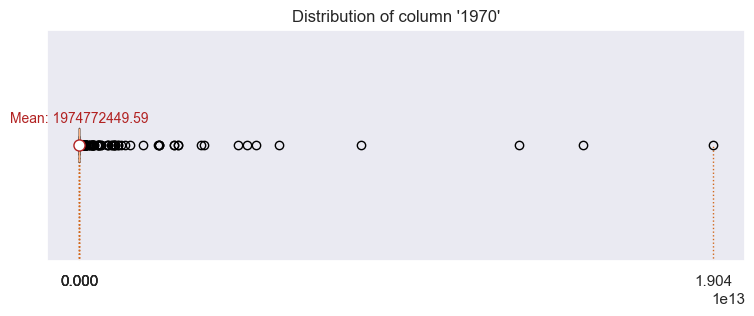

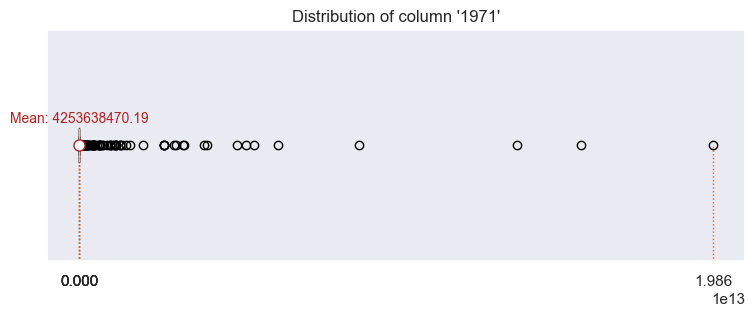

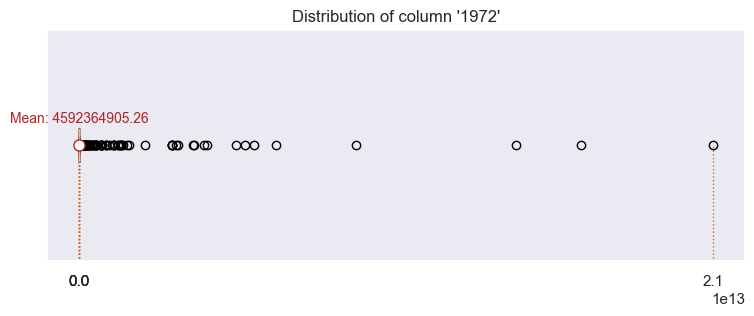

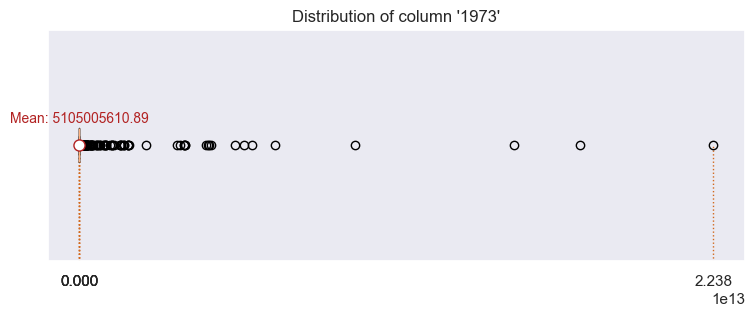

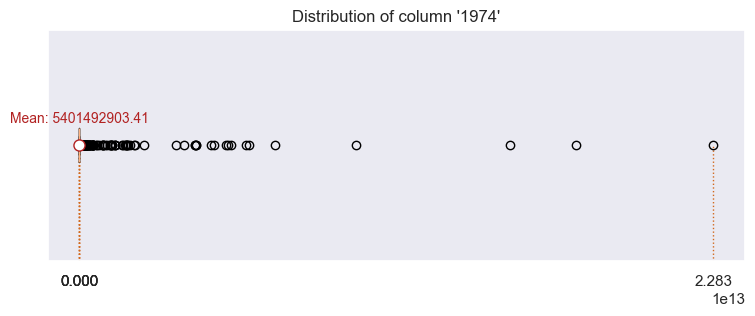

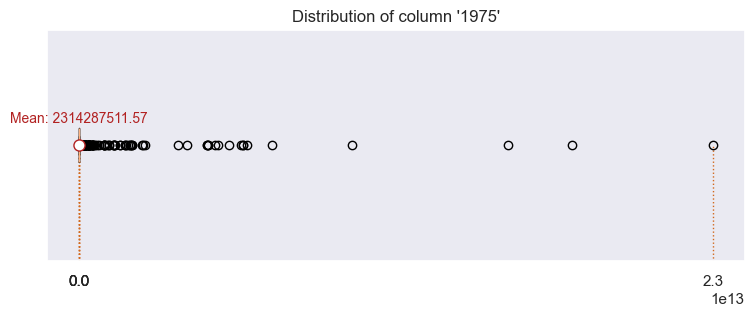

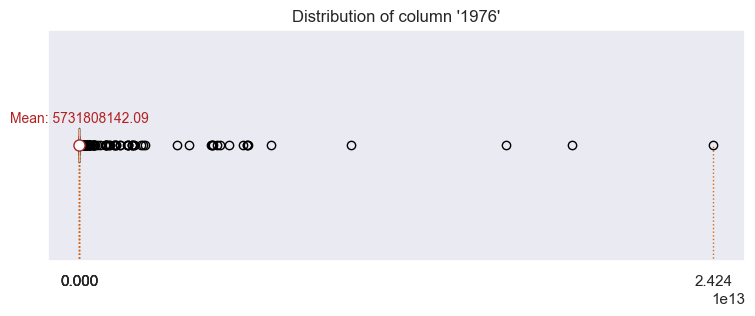

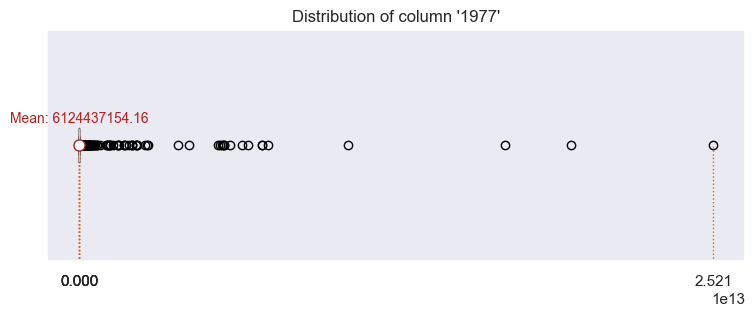

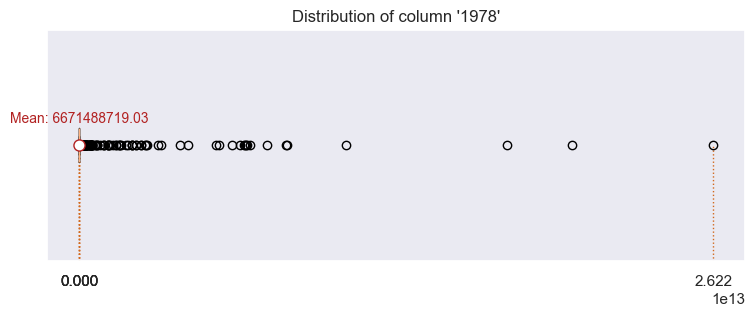

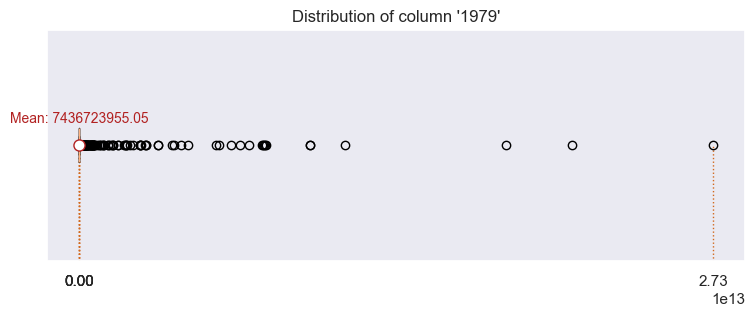

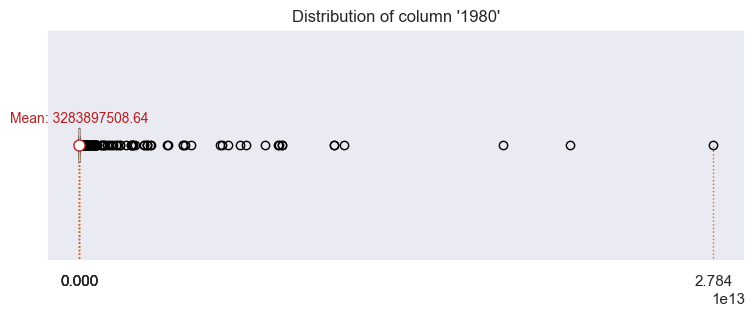

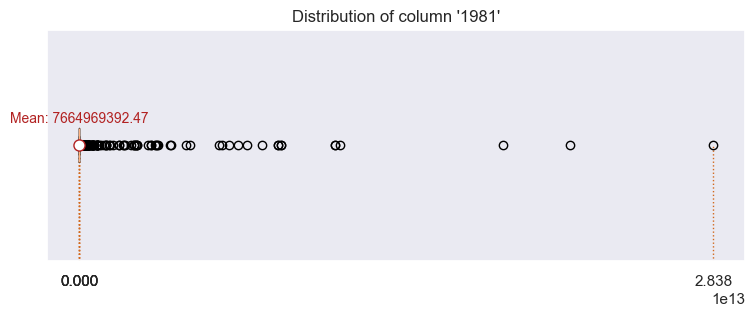

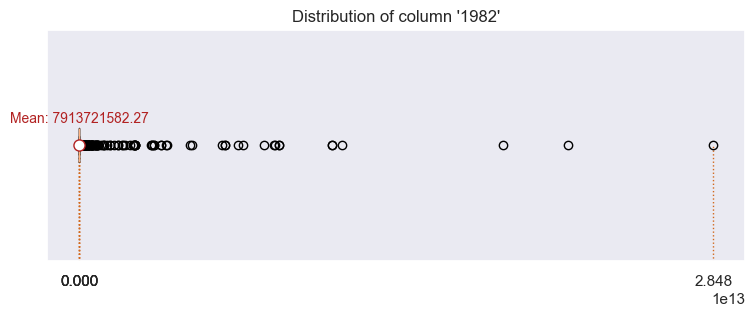

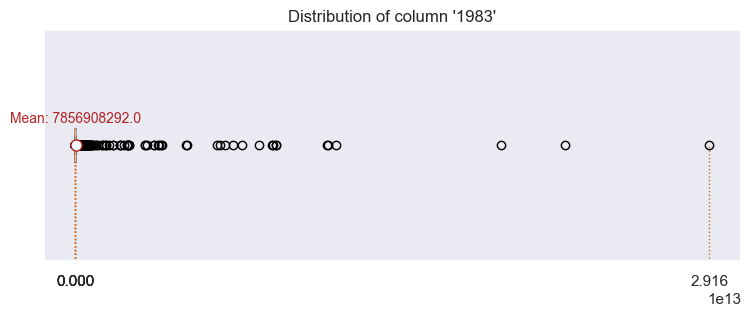

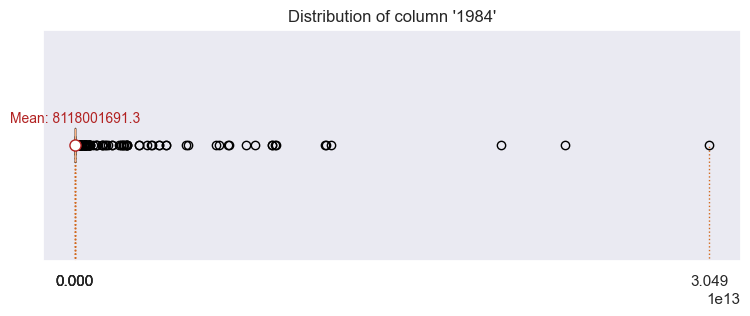

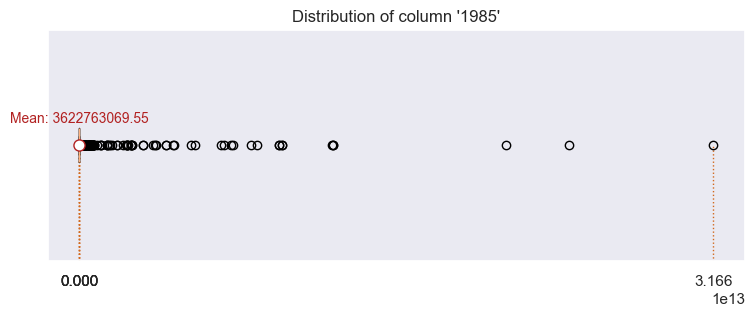

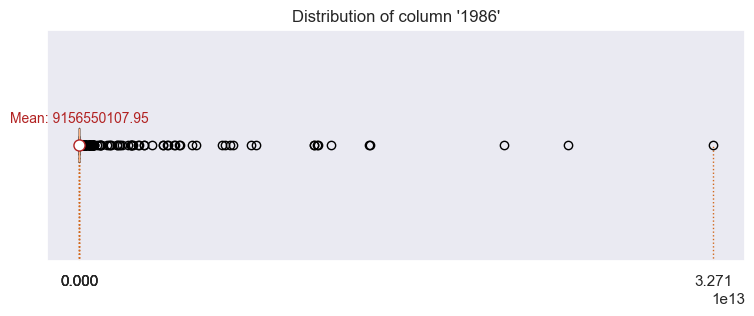

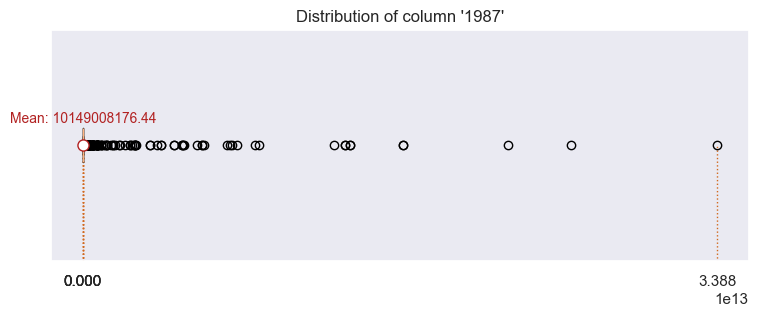

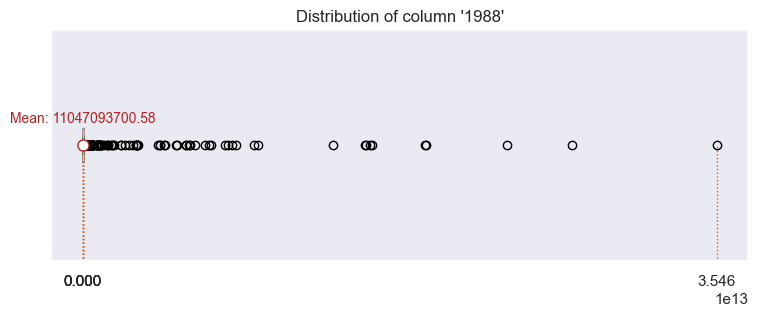

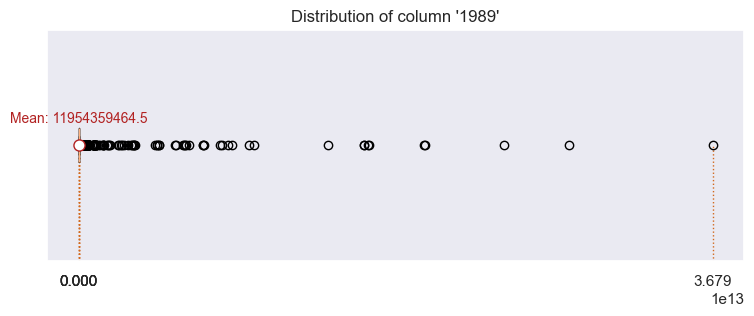

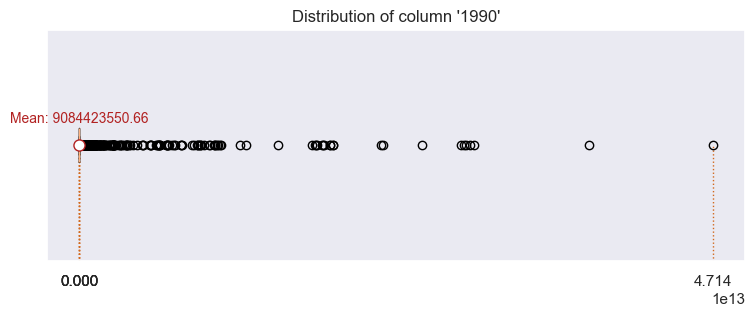

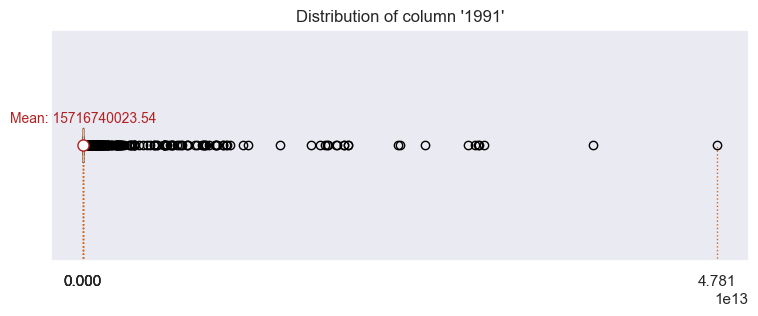

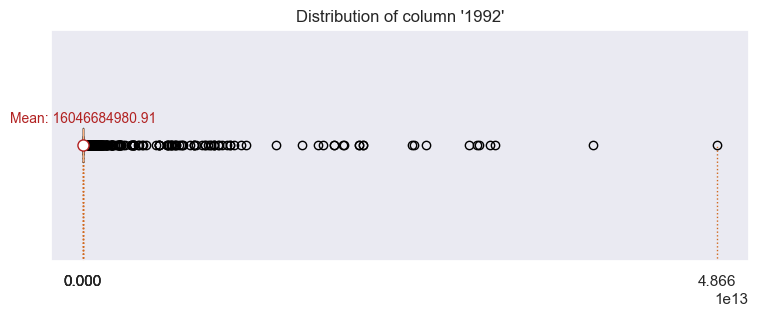

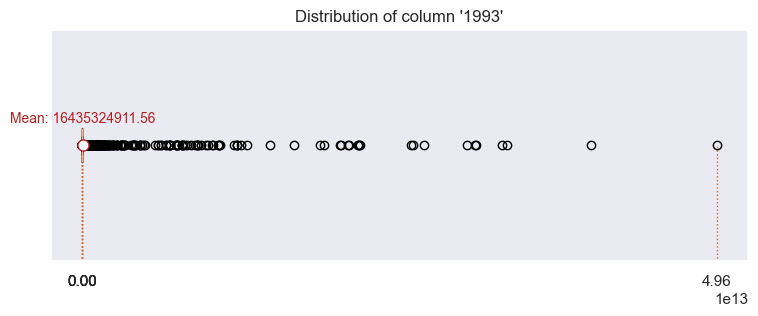

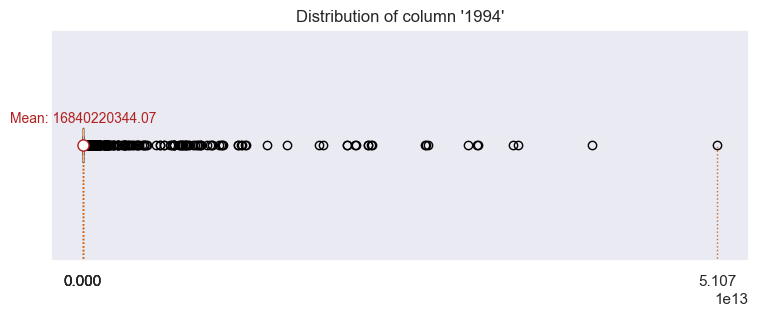

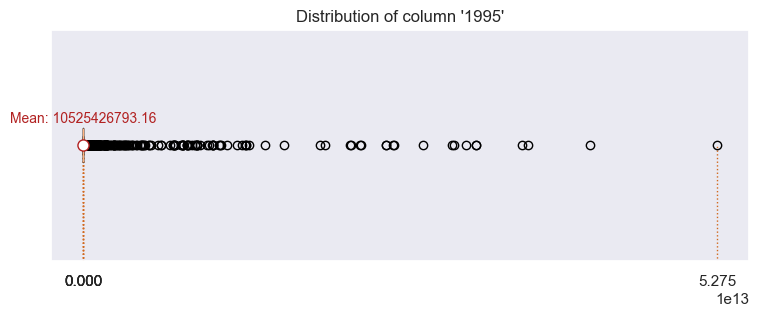

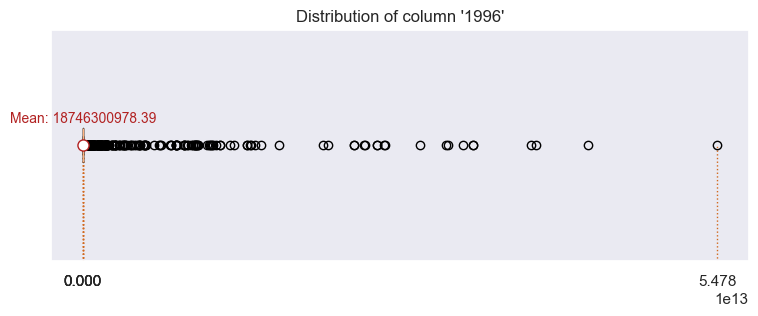

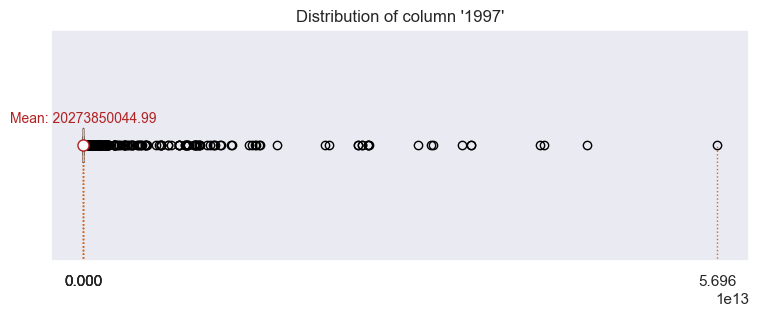

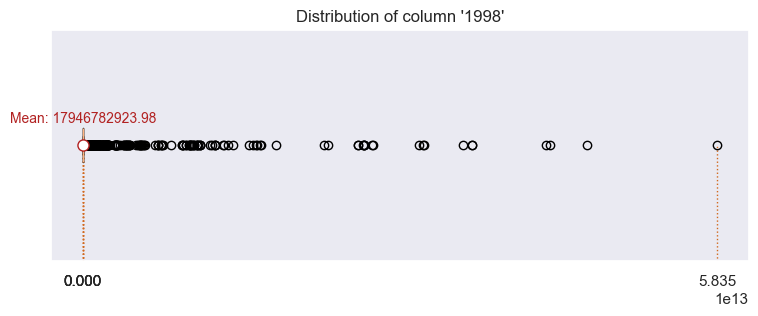

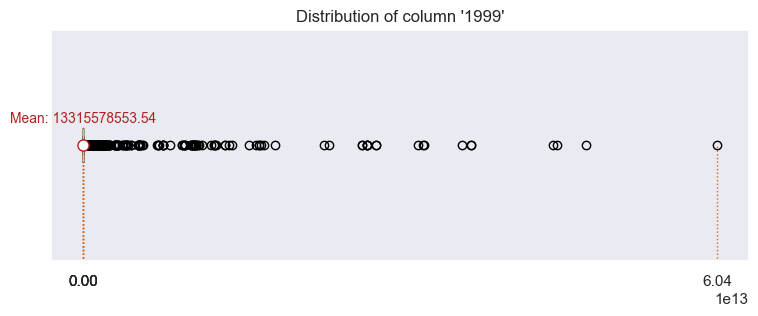

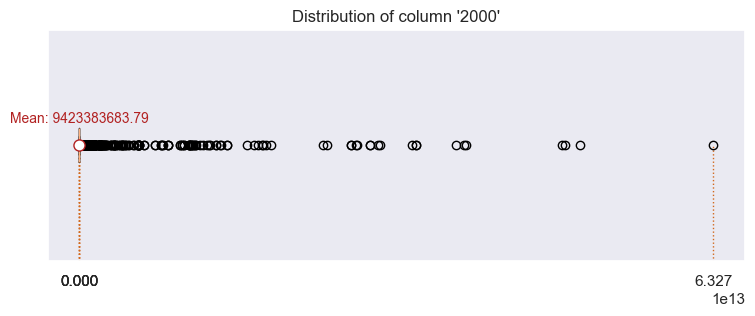

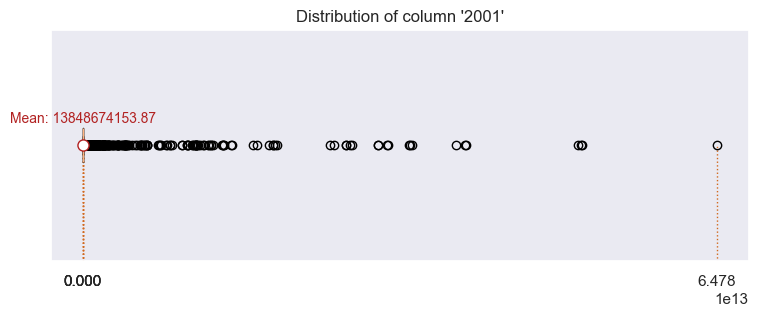

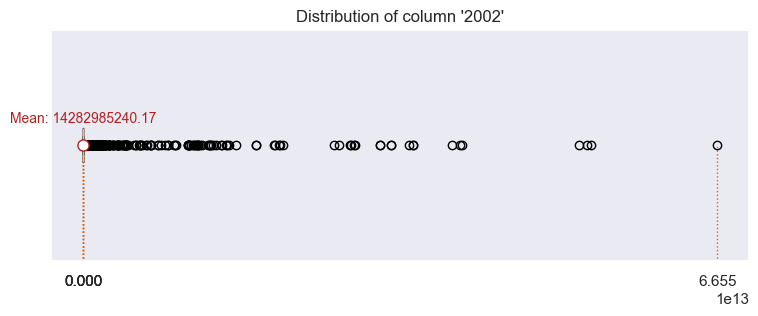

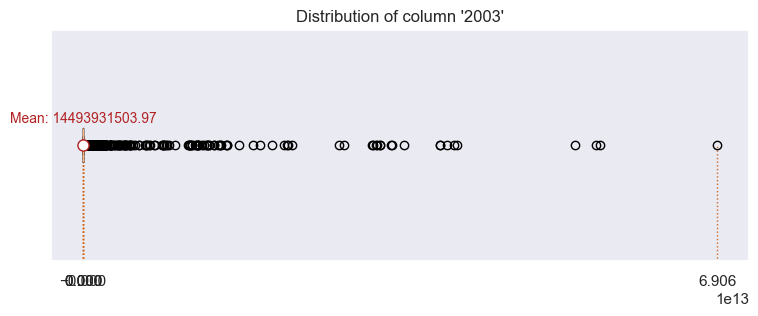

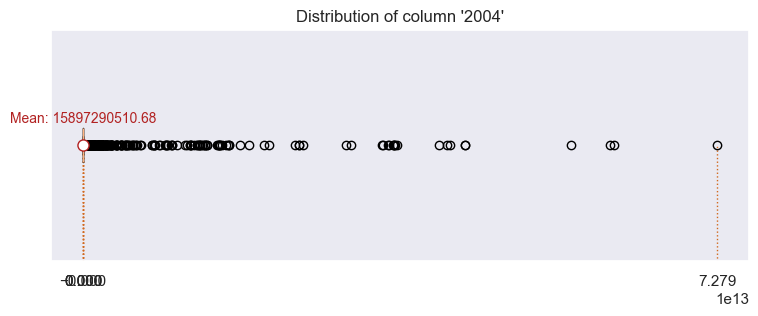

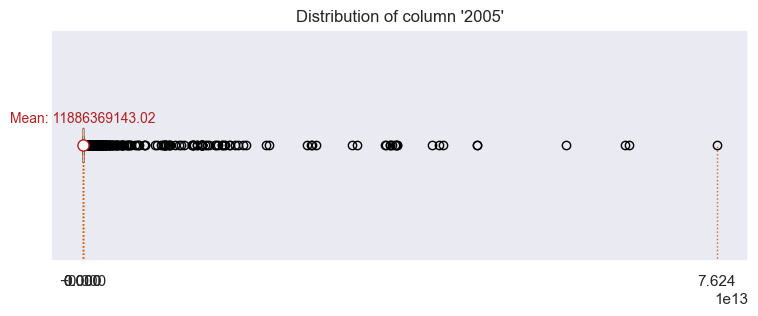

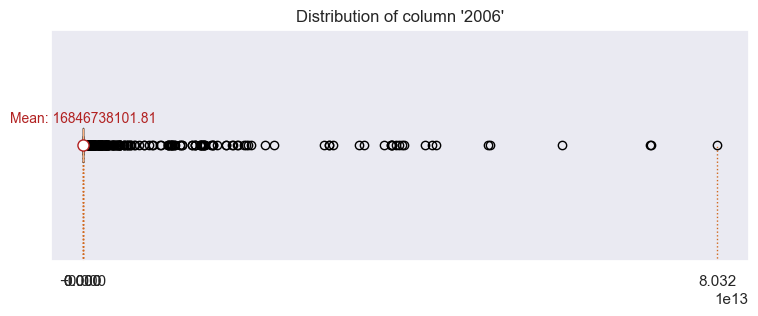

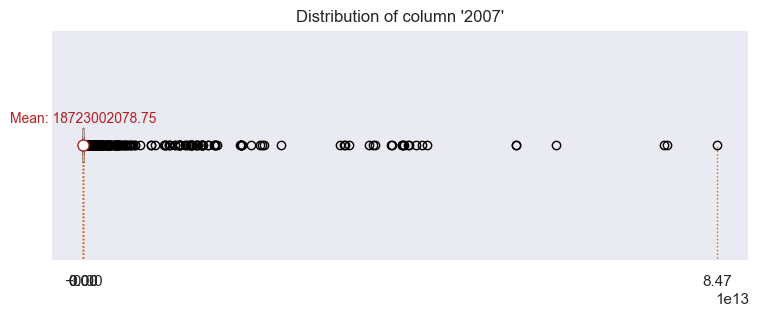

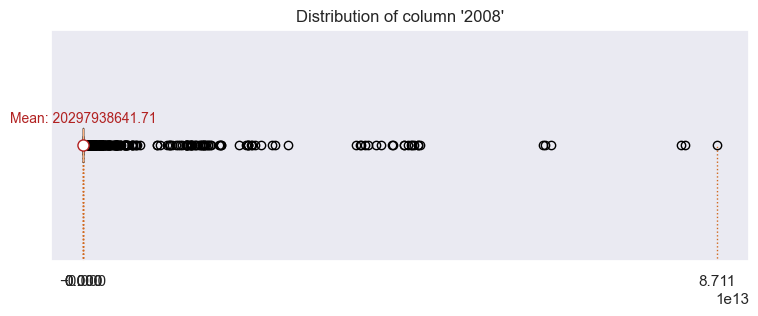

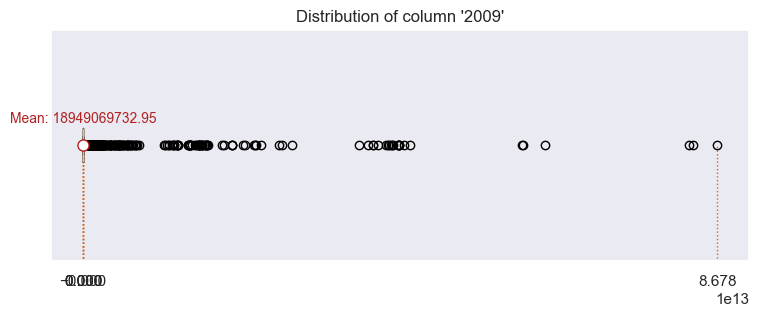

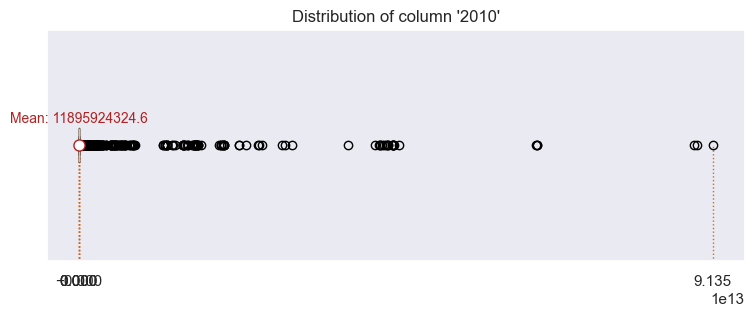

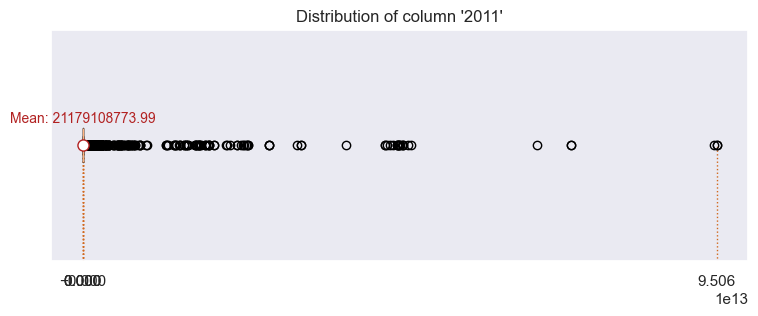

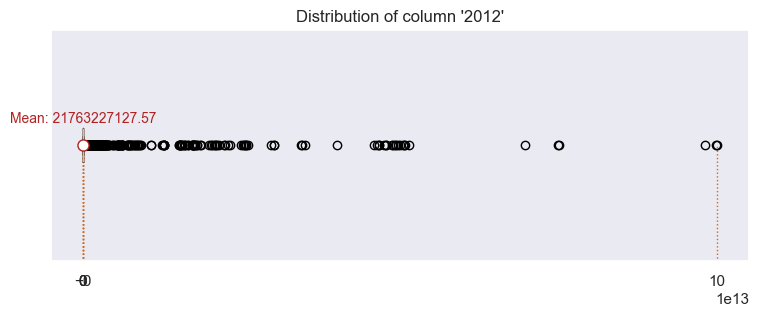

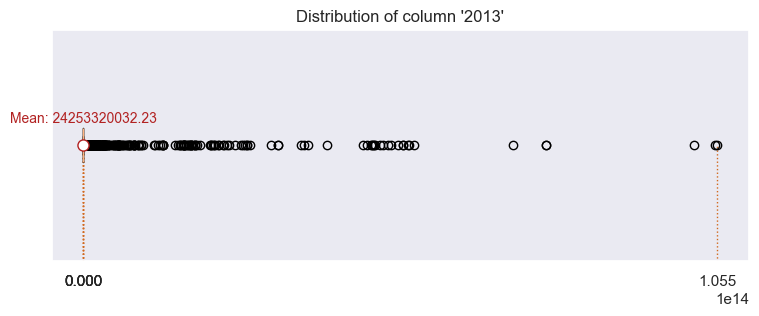

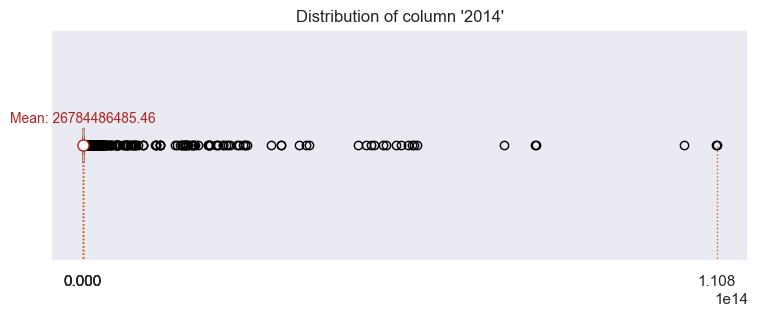

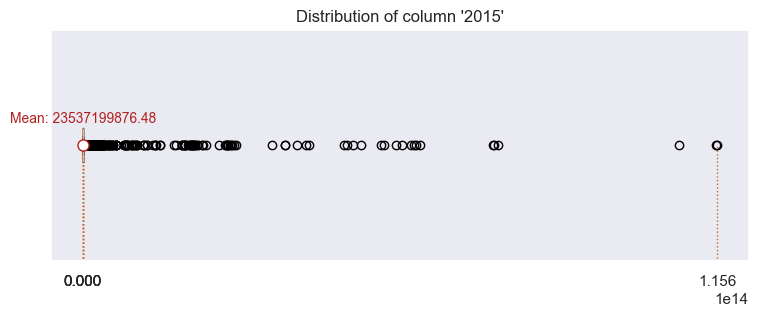

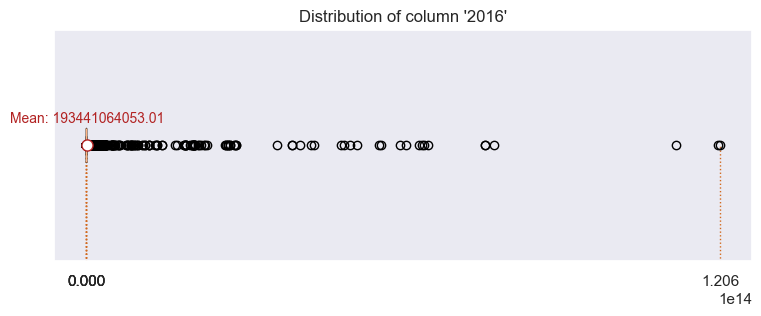

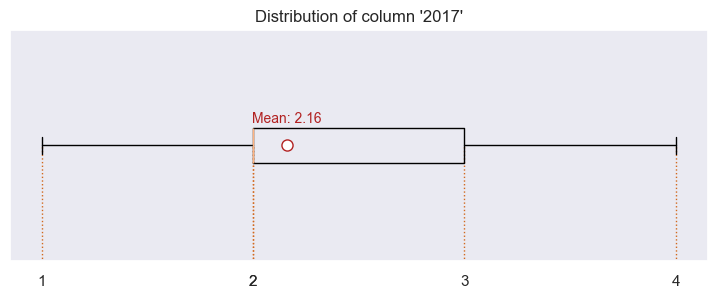

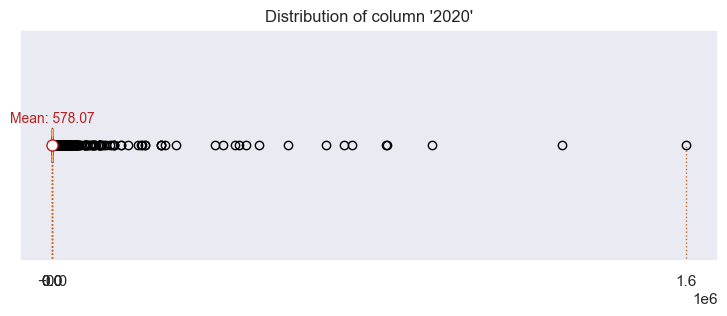

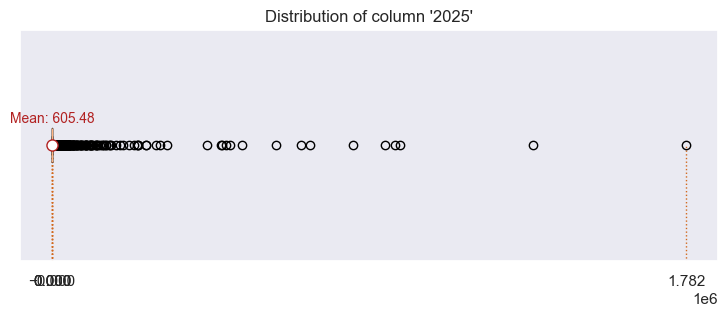

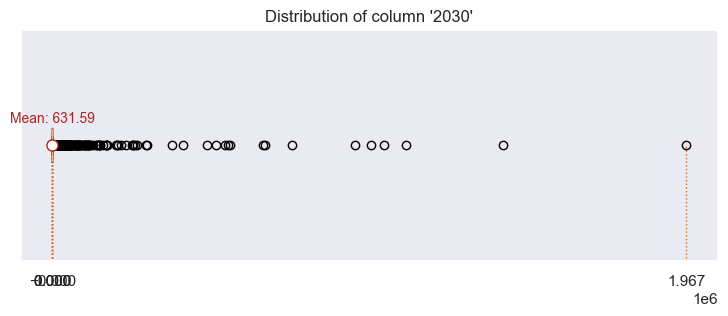

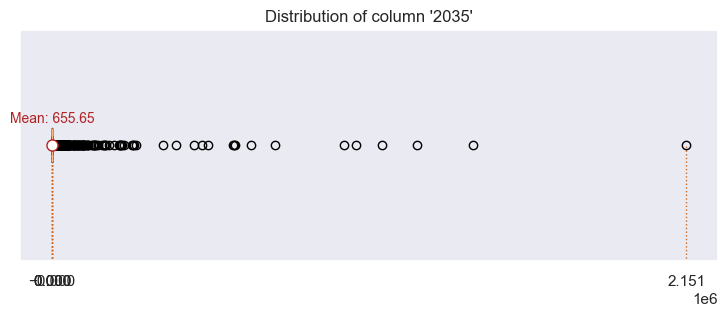

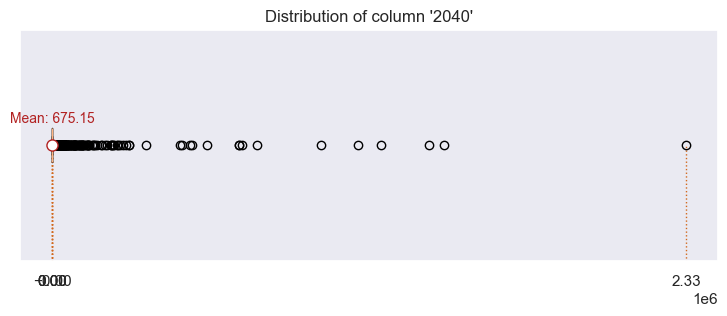

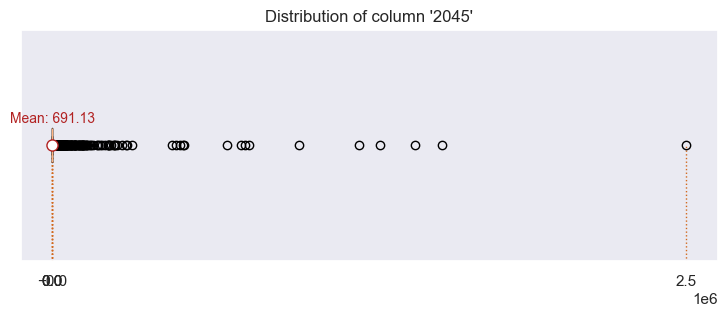

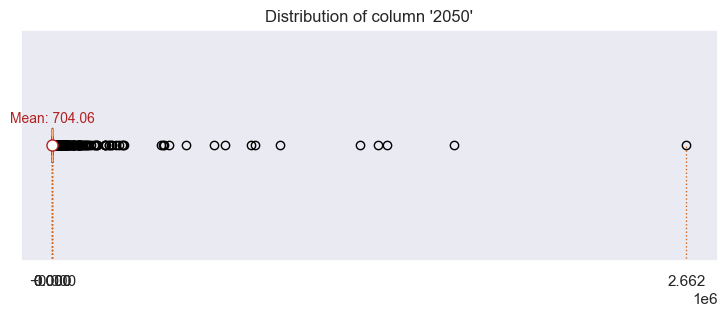

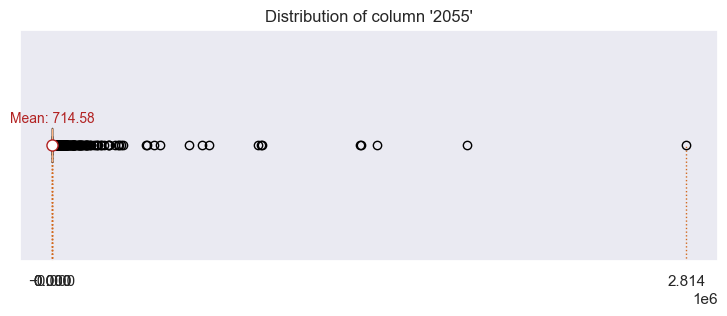

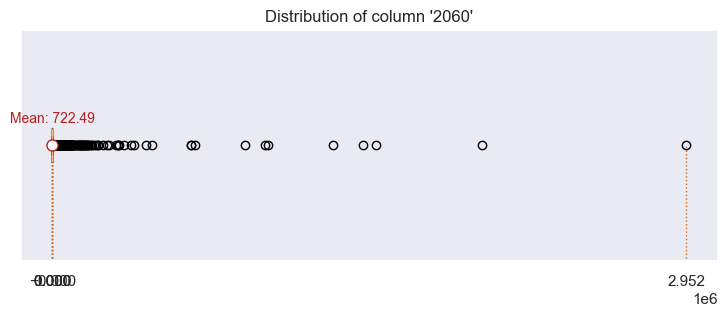

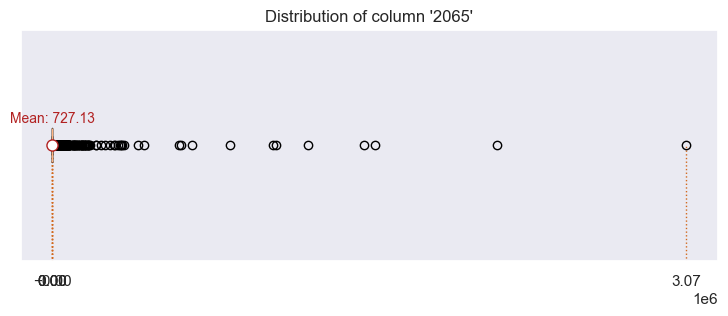

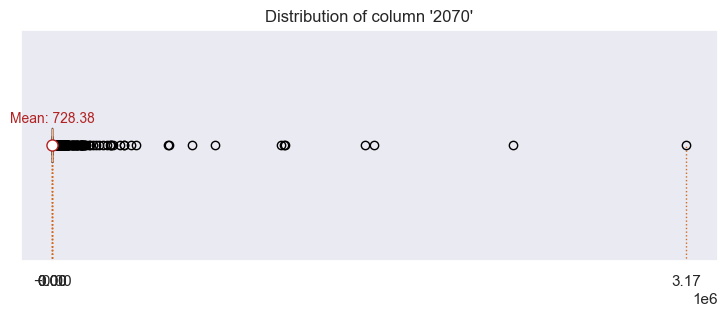

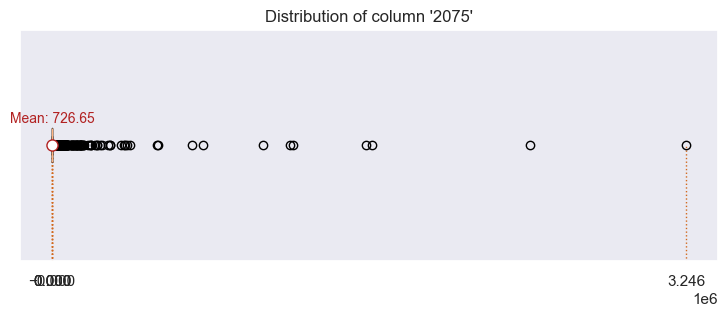

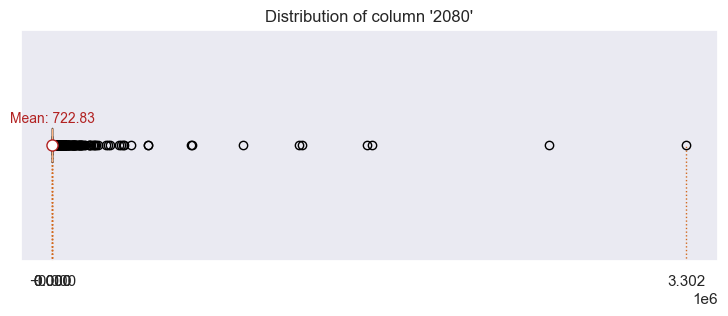

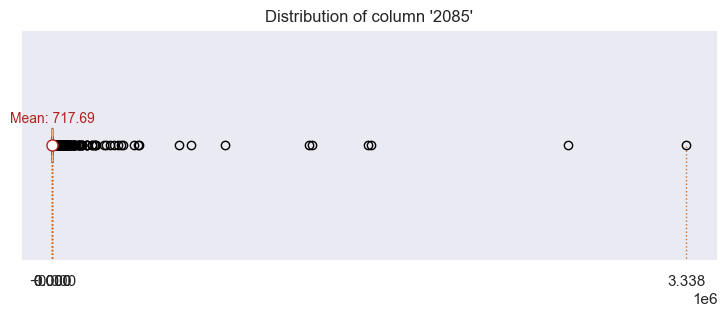

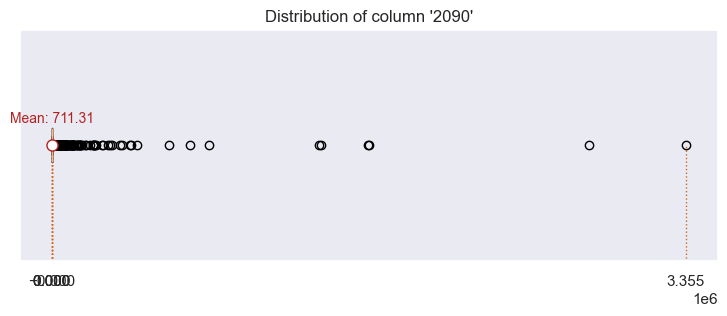

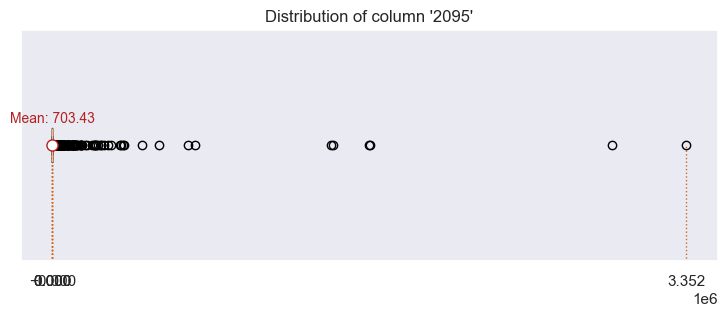

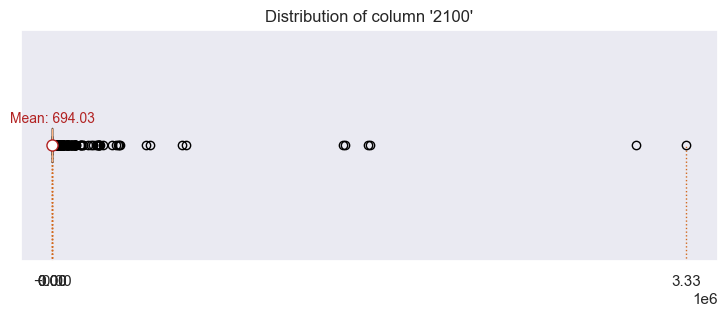


Number of rows: 886930
Number of columns: 70
********************
column name: Country Name
type: object
missing value rate: 0.0%
unique values: 242 out of 886930 non-null values (99.97% of duplicates)
mode: Afghanistan, Albania, Algeria, ... (242 elements) (3665 occurrence(s))

********************
column name: Country Code
type: object
missing value rate: 0.0%
unique values: 242 out of 886930 non-null values (99.97% of duplicates)
mode: ABW, AFG, AGO, ... (242 elements) (3665 occurrence(s))

********************
column name: Indicator Name
type: object
missing value rate: 0.0%
unique values: 3665 out of 886930 non-null values (99.59% of duplicates)
mode: Adjusted net enrolment rate, lower secondary, both sexes (%), Adjusted net enrolment rate, lower secondary, female (%), Adjusted net enrolment rate, lower secondary, gender parity index (GPI), ... (3665 elements) (242 occurrence(s))

********************
column name: Indicator Code
type: object
missing value rate: 0.0%
unique values

In [31]:
print(get_df_variables_info(ed_stats_data))

In [32]:
# Show that every country code / indicator code combination is unique

ed_stats_data_country_indicator = ed_stats_data[["Country Code", "Indicator Code"]]
sum(ed_stats_data_country_indicator.duplicated())

0

In [33]:
# Create a list of all the years inside EdStatsData.csv
years = ed_stats_data.columns[ed_stats_data.columns.str.isnumeric()]

# Get the number and proportion of rows with no data
nbr_empty_rows = ed_stats_data.loc[ed_stats_data[years].isnull().all(axis=1)].shape[0]
percent_empty_rows = nbr_empty_rows/ed_stats_data.shape[0]*100
print(f"There are {nbr_empty_rows} rows (i.e. Country / Indicator pairs) for which there is no data at all. That corresponds to {round(percent_empty_rows, 2)}% of rows.")

There are 529525 rows (i.e. Country / Indicator pairs) for which there is no data at all. That corresponds to 59.7% of rows.


In [34]:
# Identify extremely high values (> 1 billion) in years columns

ed_stats_data_over_1billion_2014 = ed_stats_data.loc[ed_stats_data["2014"] > 1e9, ["Country Name", "Indicator Name", "2014"]]
ed_stats_data_over_1billion_2014 # Use Data Wrangler to get a better overview of the data

Country Name                            Indicator Name  \
4907    East Asia & Pacific  GDP at market prices (constant 2005 US$)   
4908    East Asia & Pacific        GDP at market prices (current US$)   
4913    East Asia & Pacific  GDP, PPP (constant 2011 international $)   
4914    East Asia & Pacific        GDP, PPP (current international $)   
4915    East Asia & Pacific                         GNI (current US$)   
...                     ...                                       ...   
884508             Zimbabwe        GDP at market prices (current US$)   
884513             Zimbabwe  GDP, PPP (constant 2011 international $)   
884514             Zimbabwe        GDP, PPP (current international $)   
884515             Zimbabwe                         GNI (current US$)   
884518             Zimbabwe        GNI, PPP (current international $)   

                2014  
4907    2.022557e+13  
4908    2.190003e+13  
4913    3.290467e+13  
4914    3.461161e+13  
4915    2.203734e+13  
...              ...  
884508  1.589105e+10  
884513  2.966961e+10  
884514  3.125385e+10  
884515  1.403881e+10  
884518  2.761095e+10  

[1234 rows x 3 columns]

Extremely high values msotly correpsond to GDP indicators, which are really high especially for aggregates of countries.

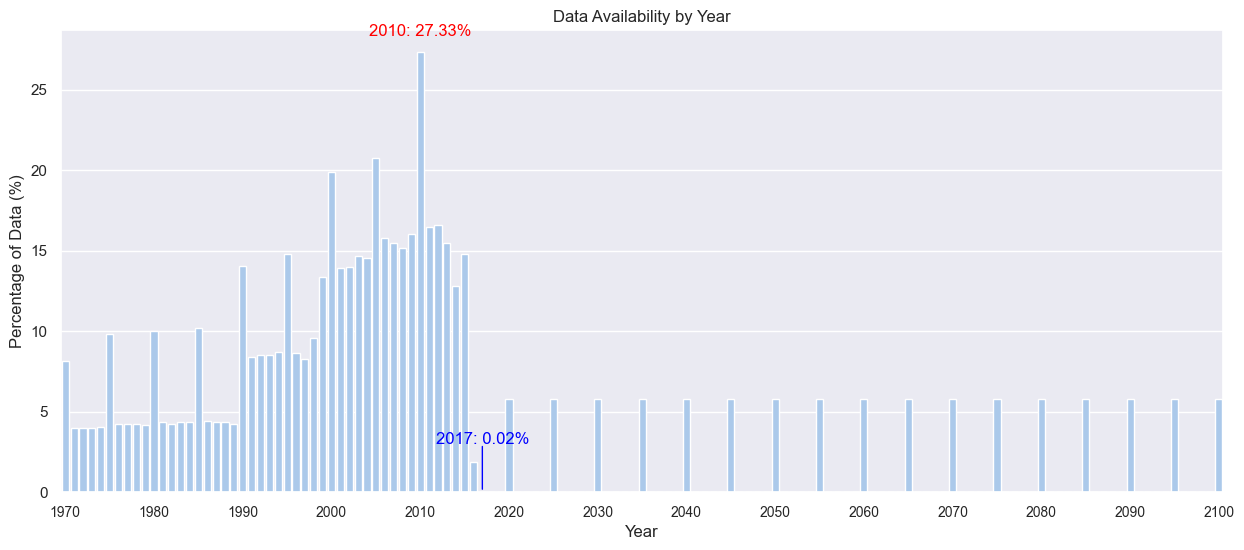

In [35]:
# Visualize data availability by year

# Calculate percentage of filled data for each year
filled_data_per_year = 100 * ed_stats_data.loc[:, ed_stats_data.columns[ed_stats_data.columns.str.isnumeric()]].notna().mean()

# Create a Series for years from 1970 to 2100
years_completed = pd.Series(range(1970, 2101)).astype(str) 

# Reindex to include all years, filling missing years with 0
filled_data_per_year_reindexed = filled_data_per_year.reindex(years_completed, fill_value=0)

# Set the theme and create the plot
sns.set_theme(palette='pastel')
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(ax=ax, x=filled_data_per_year_reindexed.index, y=filled_data_per_year_reindexed.values)
# Set x-ticks to show every 10 years
ax.set_xticks(ticks=range(0, len(years_completed), 10), labels=years_completed[::10], fontsize=10)

# Calculate min and max values, only taking into account years which are in the dataframe
filtered_data = filled_data_per_year_reindexed[years]

min_value = filtered_data.min()
max_value = filtered_data.max()
min_index = filtered_data.idxmin()
max_index = filtered_data.idxmax()
ax.text(min_index, min_value + 3, f'{min_index}: {min_value:.2f}%', ha='center', color='blue')
ax.text(max_index, max_value + 1, f'{max_index}: {max_value:.2f}%', ha='center', color='red')

# Add a small line to the annotation for the min value
ax.annotate('', xy=(min_index, min_value + 3), xytext=(min_index, min_value),
                arrowprops=dict(arrowstyle='-', color='blue', linewidth=1))

ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Data (%)')
ax.set_title('Data Availability by Year')
plt.show()

In [36]:
# Select columns for years after 2017
years = ed_stats_data.columns[ed_stats_data.columns.str.isnumeric()]
years_after_2017 = years[years.astype(int) > 2017]

# Display indicators with at least one non-null value after 2017
indicators_after_2017 = ed_stats_data[ed_stats_data[years_after_2017].notnull().any(axis=1)].value_counts(['Indicator Code', 'Indicator Name']).reset_index()
indicators_after_2017

Indicator Code                                     Indicator Name  \
0    PRJ.POP.ALL.S1.MF  Wittgenstein Projection: Population in thousan...   
1    PRJ.ATT.1519.1.FE  Wittgenstein Projection: Percentage of the pop...   
2    PRJ.ATT.1519.1.MA  Wittgenstein Projection: Percentage of the pop...   
3    PRJ.ATT.1519.1.MF  Wittgenstein Projection: Percentage of the pop...   
4     PRJ.POP.ALL.1.MA  Wittgenstein Projection: Population in thousan...   
..                 ...                                                ...   
303  PRJ.ATT.1519.3.MF  Wittgenstein Projection: Percentage of the pop...   
304  PRJ.ATT.1519.3.MA  Wittgenstein Projection: Percentage of the pop...   
305  PRJ.ATT.1519.3.FE  Wittgenstein Projection: Percentage of the pop...   
306  PRJ.ATT.1519.2.MF  Wittgenstein Projection: Percentage of the pop...   
307  PRJ.ATT.1519.2.MA  Wittgenstein Projection: Percentage of the pop...   

     count  
0      167  
1      167  
2      167  
3      167  
4      167  
..     ...  
303    167  
304    167  
305    167  
306    167  
307    167  

[308 rows x 3 columns]

In [37]:
if indicators_after_2017["Indicator Name"].str.contains('Wittgenstein Projection').all():
    print("All the indicators after 2017 contain 'Wittgenstein Projection'. These are all projections.")
else:
    print("Some indicators after 2017 do not contain 'Wittgenstein Projection'")

All the indicators after 2017 contain 'Wittgenstein Projection'. These are all projections.


C:\Users\HCYF5290\AppData\Local\Temp\1\ipykernel_2616\1580614555.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=8)


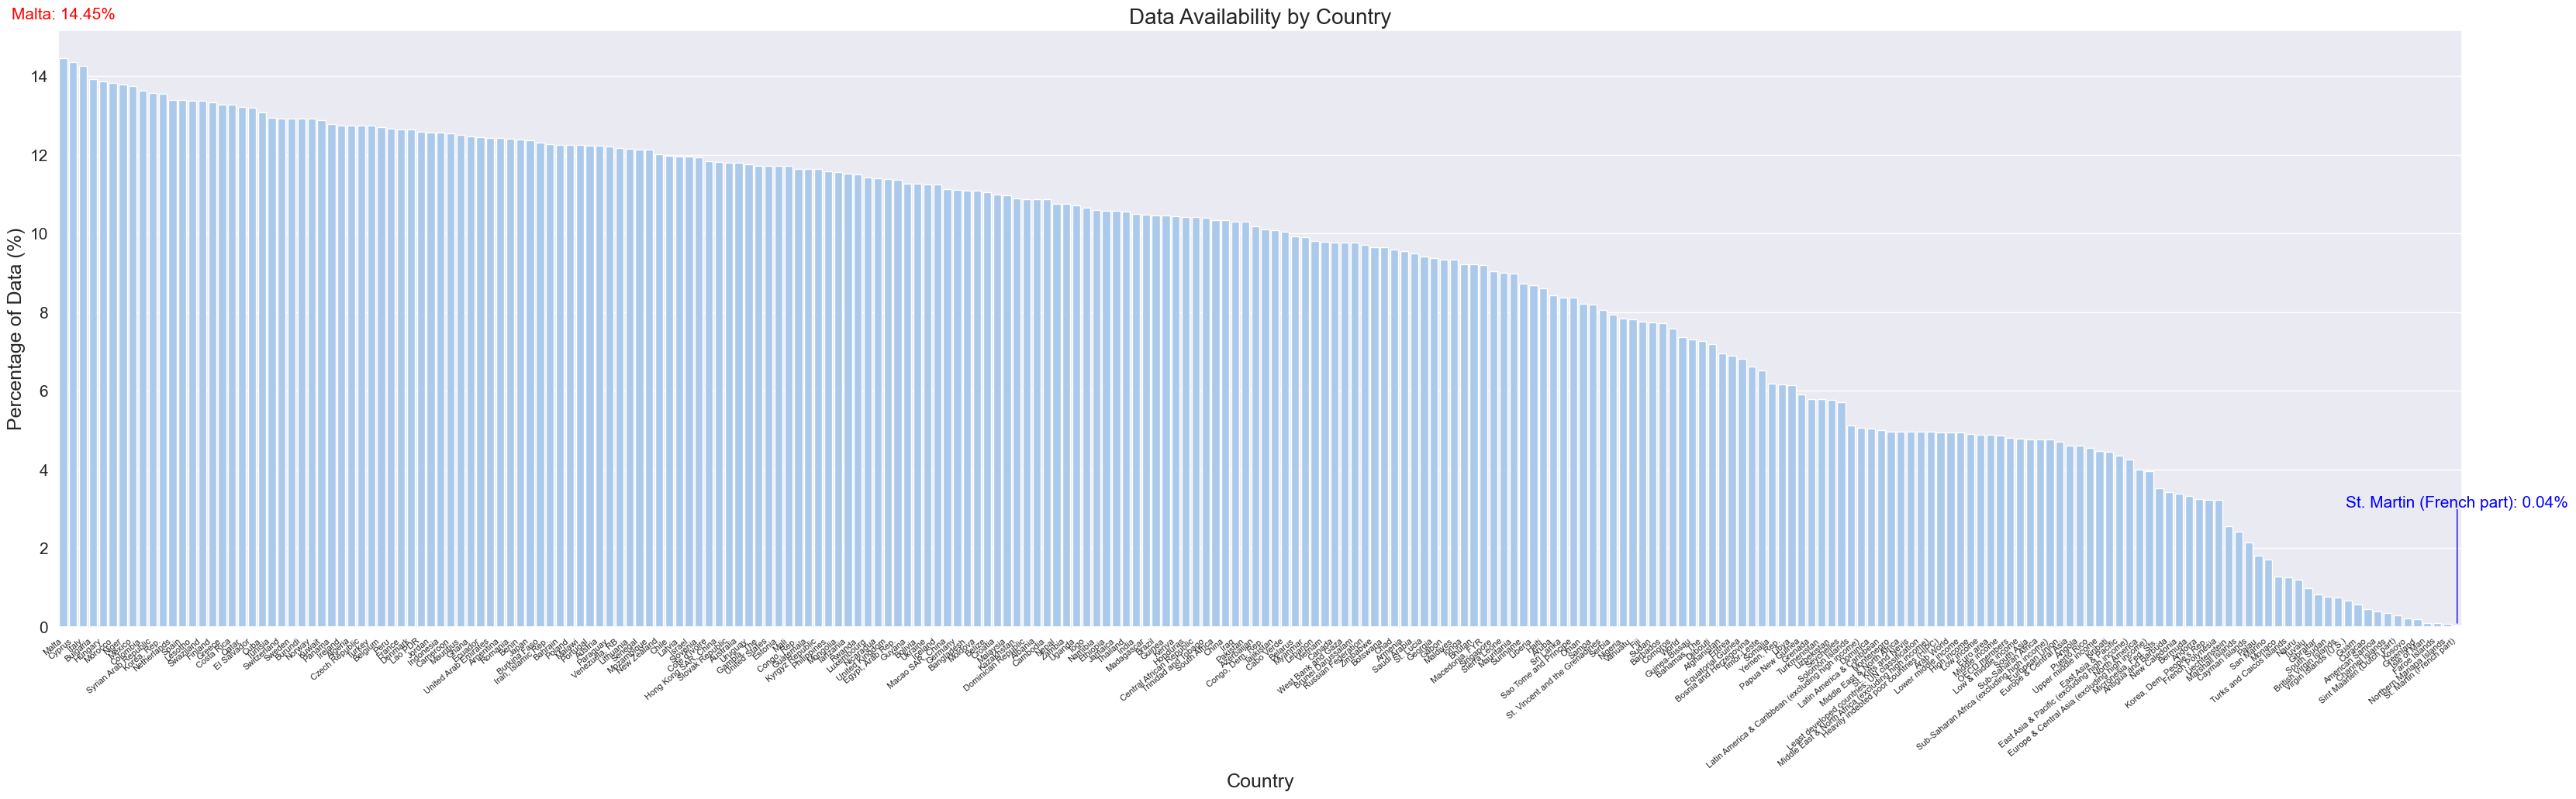

In [38]:
# Visualize data availability by country

# Calculate percentage of filled data for each country
filled_data_per_country_per_year = ed_stats_data.groupby("Country Name").agg(lambda x: x.notna().mean())
filled_data_per_country = 100 * filled_data_per_country_per_year.loc[:, ed_stats_data.columns[ed_stats_data.columns.str.isnumeric()]].mean(axis=1)

# Set the theme and create the plot
sns.set_theme(palette='pastel')
fig, ax = plt.subplots(figsize=(40,10))
sns.barplot(ax=ax, data=filled_data_per_country, orient='v', order=filled_data_per_country.sort_values(ascending=False).index)

min_value = filled_data_per_country.min()
max_value = filled_data_per_country.max()
min_index = filled_data_per_country.idxmin()
max_index = filled_data_per_country.idxmax()
ax.text(min_index, min_value + 3, f'{min_index}: {round(min_value,2)}%', ha='center', color='blue', fontsize = 15)
ax.text(max_index, max_value + 1, f'{max_index}: {round(max_value, 2)}%', ha='center', color='red', fontsize = 15)

# Add a small line to the annotation for the min value
ax.annotate('', xy=(min_index, min_value + 3), xytext=(min_index, min_value),
                arrowprops=dict(arrowstyle='-', color='blue', linewidth=1))

plt.yticks(fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=8)
ax.set_xlabel('Country', fontsize=18)
ax.set_ylabel('Percentage of Data (%)', fontsize=18)
ax.set_title('Data Availability by Country', fontsize=20)
plt.show()

#### Fix dtypes

Nothing unusual about the dtypes.

#### Remove useless columns

In [39]:
# Get percentage of missing values for each column, in complement with info given by get_df_variables_info() function.
ed_stats_data.isna().mean()

Country Name      0.000000
Country Code      0.000000
Indicator Name    0.000000
Indicator Code    0.000000
1970              0.918496
                    ...   
2085              0.942007
2090              0.942007
2095              0.942007
2100              0.942007
Unnamed: 69       1.000000
Length: 70, dtype: float64

In [40]:
# Column "Unnamed: 69" is empty, no need to keep it.
ed_stats_data.drop(columns=["Unnamed: 69"], inplace=True)

#### Conclusion

- The file EdStatsData.csv contains data on 3665 indicators for 242 countries from 1970 to 2100. Every Country Code / Indicator Code pair is unique.  
- There are a lot of missing values:
  - The percentage of filled data per country goes from 0.04% (St. Marin (French Part)) to 14.45% (Malta).
  - The percentage of filled data per year goes from 0.02% (2017) to 27.33% (2010). There is a peak every 5 five years (1970, 1975, 1980, and so on) until 2010. Then there is a huge drop on year 2017. After that, the amount of data stays constant every 5 years. Note that the percentage of filled data is 0% for every year which are not a multiple of 5 after 2017 because those years are not in the csv file. 
- All values after 2017 are predictions. This tells us that the data set is not really up-to-date (about 8 years behind) but it should still be okay to perform estimations.  
- The proportion of Country / Indicator pairs for which there is no data is close to 60%.
- Some values are extremely high in the years columns (over 1 billion). It often corresponds to economic data (GDP, GNI, ...) or indicators related to population in aggregates of countries.

### Common data between CSV files

Those CSV files have some information in common :
- Country Code
  - EdStatsCountry.csv (Country Code)
  - EdStatsData.csv (Country Code)
  - EdStatsCountry-Series.csv (CountryCode)
  - EdStatsFootNote.csv (CountryCode)
- Indicator Code
  - EdStatsData.csv (Indicator Code)
  - EdStatsSeries.csv (Series Code)
  - EdStatsCountry-Series.csv (SeriesCode)
  - EdStatsFootNote.csv (SeriesCode)
- DESCRIPTION (of indicator)
  - EdStatsCountry-Series.csv (DESCRIPTION)
  - EdStatsFootNote.csv (DESCRIPTION)
- Country Name (The differences will not be thoroughly investigated because there is already "Country Code" variable in common between those 2 files.)
  - EdStatsCountry.csv (Short Name)
  - EdStatsData.csv (Country Name)

__Comparing Country Codes__

The "Country Code" column in file EdStatsData.csv includes all countries that are present in the other csv files.  
Could be interesting to note that EdStatsData includes "British Virgin Islands" but EdStatsCountry does not. 

__Comparing Indicator Codes__

There are 3665 unique values of "Indicator Code" in EdStatsData.csv.  
Let's check if this file includes all indicators that are present in the other csv files.

_EdStatsData.csv  vs EdStatsSeries.csv_

The number of distinct elements in "Series Code" from EdStatsSeries and "Indicator Code" from EdStatsData is the same. Let's check if the values are the same.

In [41]:
# Compare "Series Code" values from EdStatsSeries and "Indicator Code" values from EdStatsData

series_set = set(ed_stats_series["Series Code"])
data_set = set(ed_stats_data["Indicator Code"])

len(series_set - data_set)

53

There are 53 differences. Let's display it in a dataframe to visualize the differences better :

In [42]:
# Display differences between both Series

compare_series_data = pd.DataFrame({"Series Code":ed_stats_series["Series Code"].sort_values().unique(), "Indicator Code":ed_stats_data["Indicator Code"].sort_values().unique()})
compare_series_data.loc[compare_series_data["Series Code"] != compare_series_data["Indicator Code"]]

Series Code              Indicator Code
2292      SE.SEC.DURS.LO               SE.SEC.DURS.LO
2314   SE.SEC.ENRR.UP.FE            SE.SEC.ENRR.UP.FE
2717        UIS.AIR.1.GPI         UIS.AIR.1.GLAST.GPI
2718  UIS.AIR.1.Glast.GPI               UIS.AIR.1.GPI
2724          UIS.CEAge.1                 UIS.CEAGE.1
...                   ...                         ...
3658          UIS.thAge.0   UIS.XUNIT.USCONST.2.FSGOV
3659    UIS.thAge.3.A.GPV  UIS.XUNIT.USCONST.23.FSGOV
3660    UIS.thAge.4.A.GPV   UIS.XUNIT.USCONST.3.FSGOV
3661          UIS.thDur.0   UIS.XUNIT.USCONST.4.FSGOV
3662    UIS.thDur.4.A.GPV  UIS.XUNIT.USCONST.56.FSGOV

[168 rows x 2 columns]

Now there are 168 differences. Some of the elements seem to have been missorted due to formats being different. For example :  

2717&ensp;| UIS.AIR.1.GPI&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;|&ensp;UIS.AIR.1.GLAST.GPI  
2718&ensp;| UIS.AIR.1.Glast.GPI&ensp;|&ensp;UIS.AIR.1.GPI  

Let's force the format and compare the sets again:

In [43]:
# Force case to uppercase and remove trailing white spaces.
formatted_series_set = set(x.strip().upper() for x in series_set)
formatted_data_set = set(x.strip().upper() for x in data_set)

# Check again if there are any differences
formatted_series_set - formatted_data_set

set()

In fact, "Indicator Code" from EdStatsData contain all indicator codes which are in any other csv file from the dataset. It is only a matter of trailing whitespaces and uppercase vs lowercase.  
Let's apply this format to all columns corresponding to indicator codes.

In [44]:
def format_indicator_codes(s:pd.Series):
    return s.str.strip().str.upper()

ed_stats_series.loc[:, "Series Code"] = format_indicator_codes(ed_stats_series["Series Code"])
ed_stats_country_series.loc[:, "SeriesCode"] = format_indicator_codes(ed_stats_country_series["SeriesCode"])
ed_stats_foot_note.loc[:, "SeriesCode"] = format_indicator_codes(ed_stats_foot_note["SeriesCode"])
ed_stats_data.loc[:, "Indicator Code"] = format_indicator_codes(ed_stats_data["Indicator Code"])

__Comparing Country Code / Indicator Code pairs__

EdStatsData.csv contains all Country / Indicator pairs which are in EdStatsCountry-Series and EdStatsFootNote.

__Comparing Country / Indicator pairs Descriptions__

EdStatsFootNote.csv and EdStatsCountry-Series.csv both contain descriptions for an indicator applied to a country. In the case of EdStatsFootNote.csv, it is even for a given year.  

Some incoherences have been spotted between both files. For example:
- Georgia, on indicator "SP.POP.TOTL.FE.ZS":
  - "__Including__ Abkhazia and South Ossetia." (Description from EdStatsFootNote for all the years)
  - "__Excluding__ Abkhazia and South Ossetia." (Description from EdStatsSeries-Country)

This seems to happen for "Georgia", "Moldova", "Mauritius", "Serbia" and "West Bank and Gaza".

If looking at those descriptions is necessary at some point, data from file EdStatsFootNote.csv will be prioritized because it contains information on the year. If there is no description of the given Country / Indicator pair, information will be searched in EdStatsDataCountry-Series.csv.

__Comparing Country Names__

There are some differences between "Country Name" in EdStatsData.csv and "Short Name" in EdStatsCountry.csv. However they are all orthographic differences. None of the differences is due to an error of labelling / naming.

## Preparing data

In [45]:
# Create new column to easily identify aggregates
ed_stats_country["isAggregate"] = ed_stats_country["Special Notes"].fillna('').str.contains('aggregate')

#Filter ed_stats_country to only keep useful columns
ed_stats_country_filtered = ed_stats_country[["Country Code", "Income Group", "Region", "isAggregate"]]

# Merge useful columns with ed_stats_data to access them easily
ed_stats_data = ed_stats_data.merge(ed_stats_country_filtered, how="left", on="Country Code")

# Replace NA values by "Undefined" in "Region" and "Income Group"
ed_stats_data.loc[:, ["Region", "Income Group"]] = ed_stats_data.loc[:, ["Region", "Income Group"]].fillna("Undefined")


In [46]:
# Add Region, Income Group and isAggregate to "British Virgin Islands" according to World Bank Group data
ed_stats_data.loc[ed_stats_data["Country Code"] == "VGB", "Region"] = "Latin America & Caribbean"
ed_stats_data.loc[ed_stats_data["Country Code"] == "VGB", "Income Group"] = "High income: nonOECD"
ed_stats_data.loc[ed_stats_data["Country Code"] == "VGB", "isAggregate"] = False

# Convert isAggregate type to bool. Wasn't bool until now because there were missing values
ed_stats_data["isAggregate"] = ed_stats_data["isAggregate"].astype(bool)

In [47]:
# Define generic lists of countries. Most analysis will be done without aggregates
all_countries = ed_stats_country["Country Code"].tolist()
countries_not_aggregates = ed_stats_country.loc[~(ed_stats_country["isAggregate"]), "Country Code"].tolist()

In [48]:
# Define generic list of indicators.
all_indicators = ed_stats_data["Indicator Code"].unique().tolist()

In [49]:
# Define generic list of years
all_years = ed_stats_data.columns[ed_stats_data.columns.str.isnumeric()].tolist()

## Strategy

In order to answer the problem, we will build several custom scores based on the available indicators:

- Demographic Score : What is the amount of potential customers ?
- Economic Score : Is the population able to pay for online training ?

Other scores could be built, such as :
- Ease-of-entry Score : Is there a place for new educational offers ?
- Need Score : Is there a need for additional educational offers ?
- Ability Score : Is the population able to follow online training ?

However, this exploratory analysis only focused on demographic and economic scores.

__Determine relevant years__

At first, relevant years will be determined by visualizing percentage of filled data per year.  
Those years will be the ones used to predict future data in the end.

Then, by going more into details of available data for each of those years, the most relevant year will be determined.

__Determine relevant indicators__

Several relevant indicators will be chosen to build each score for a given year.  
Missing data will be estimated using several methods.
  
Here is a detailed protocole :

- For each chosen indicator:
  - For each country with missing values for the given year:
    - If number of individuals (N) >= 5  
      __1.Calculate correlation coefficient between time and indicator for each country.__
      - If R² >= 0.5
        &rarr; Perform linear regression to predict values on given year for given country.
      - If R² < 0.5  
        __2.Calculate coefficient of variation (CV) for given country__
          - If CV < 0.3 : variation is considered acceptable
            &rarr; Precision is considered sufficient to impute on mean value.

    &rarr; Identify the best indicator to perform linear regression
      - If there is one indicator with R² >= 0.5 which respects all criteria  
        __3.Estimate data by performing linear regression with this indicator__
    
    &rarr; Perform ANOVA with available categories ('Region' and 'Income Group')
      - If one of the η² coefficient is sufficiently high
        - Choose this type of aggregate
          - If the value of the corresponding aggregate is missing for the given year  
            __4.Estimate data with the median of the values of countries belonging to corresponding aggregate.__
          - If the value of the corresponding aggregate is not missing  
            __4bis.Estimate data with this value.__

__Calculate scores for most relevant year__

Scores will be determined for each country for this year.  
Each country will also have a confidence score based on the percentage of filled data among the chosen indicators

__Predict scores for 2025__

To conclude, scores for most promising countries will be predicted in 2025 by estimating the values of the chosen indicators using linear regression or imputations.

## Determine relevant years

Relevant years for this analysis are the most recent years, but also years for which there is sufficient data.  
Let's visualize data availibility by year in a more detailed way.

In [50]:
def filter_df(df:pd.DataFrame, countries:list=countries_not_aggregates, inds:list=all_indicators, years:list=all_years) -> pd.DataFrame:
    '''
    Filters a DataFrame by specified countries, indicators, and years.

    Parameters:
    df (pd.DataFrame): DataFrame to filter.
    countries (list): Country codes to include. Defaults to countries_not_aggregates.
    inds (list): Indicator codes to include. Defaults to all_indicators.
    years (list): Years to include. Defaults to all_years.

    Returns:
    pd.DataFrame: Filtered DataFrame with specified countries, indicators, and years.
    '''
    non_numeric_cols = df.columns[(~df.columns.str.isnumeric())].tolist()
    return df.loc[(df["Country Code"].isin(countries)) & (df["Indicator Code"].isin(inds)), non_numeric_cols + [y for y in years if y in df.columns]]

In [51]:
def groupby_sortby_filled_data(df_filtered:pd.DataFrame, groupby:str="Indicator Code"):
    '''
    Groups and sorts a DataFrame by the percentage of filled data for each indicator.

    Parameters:
    df_filtered (pd.DataFrame): DataFrame to process.
    groupby (str): Column to group by. Defaults to "Indicator Code".

    Returns:
    pd.DataFrame: Sorted DataFrame with indicators based on the mean percentage of filled data.
    '''
    # Drop useless columns
    columns_to_drop = df_filtered.columns[(~df_filtered.columns.str.isnumeric()) & (df_filtered.columns != groupby)]
    df_filtered = df_filtered.drop(columns=columns_to_drop)

    # Calculate percentage of filled data for each indicator
    filled_data_per_indicator_per_year = df_filtered.groupby(groupby).agg(lambda x: x.notna().mean()*100)

    # Sort indicators by mean percentage of filled data
    filled_data_per_indicator_per_year.loc[:, "Mean Filled Percentage"] = filled_data_per_indicator_per_year.mean(axis=1)
    sorted_row_df = filled_data_per_indicator_per_year.sort_values("Mean Filled Percentage", ascending=False)
    
    return sorted_row_df

In [52]:
def get_filled_data_percentage(df:pd.DataFrame, inds:list, years:list=[], countries:list=countries_not_aggregates, groupby="Indicator Code"):
    '''
    Gets the percentage of filled data for specified indicators.

    Parameters:
    df (pd.DataFrame): DataFrame to analyze.
    inds (list): List of indicator codes.
    years (list): Years to include. Defaults to empty list.
    countries (list): Country codes to include. Defaults to countries_not_aggregates.

    Returns:
    pd.DataFrame: DataFrame with the percentage of filled data for each indicator and for each year.
    '''
    if len(years) == 0:
        years = df.columns[df.columns.str.isnumeric()]
    filtered_df = filter_df(df, countries=countries, inds=inds, years=years)
    prepared_df = groupby_sortby_filled_data(filtered_df, groupby=groupby)

    return prepared_df

In [53]:
def prepare_data_heatmaps(df:pd.DataFrame, countries:list=all_countries, inds:list=all_indicators, years:list=[]):
    '''
    Prepares data for heatmaps by ensuring all years are represented.

    Parameters:
    df (pd.DataFrame): DataFrame to process.
    countries (list): Country codes to include. Defaults to all_countries.
    inds (list): Indicator codes to include. Defaults to all_indicators.
    years (list): Years to include. Defaults to all_years.

    Returns:
    pd.DataFrame: DataFrame reindexed to include all years, filling missing values with 0.
    '''
    if len(years) == 0:
        years = df.columns[df.columns.str.isnumeric()]
        
    # List of all the years in the columns of df
    int_years = [int(y) for y in years]
    
    # Prepare list of years to complete the missing years in the columns of df
    years_completed = pd.Series(range(min(int_years), max(int_years)+1)).astype(str)

    grouped_df = get_filled_data_percentage(df, countries=countries, inds=inds, years=years)
    grouped_filtered_df = grouped_df.loc[:, ~grouped_df.columns.isin(["Mean Filled Percentage"])]
    
    reindexed_cols_df = grouped_filtered_df.reindex(columns=years_completed, fill_value=0)
    return reindexed_cols_df

In [54]:
def produce_heatmaps(prepared_df:pd.DataFrame):  
    '''
    Generates heatmaps to visualize the percentage of filled data by indicator for each year.

    Parameters:
    prepared_df (pd.DataFrame): DataFrame containing the percentage of filled data.
    '''
    # Prepare the plots
    fig, axes = plt.subplots(2, figsize=(20,20))
    sns.set_theme(palette='dark')

    # First plot with years sorted chronologically 
    sns.heatmap(ax=axes[0], data=prepared_df, yticklabels=False)
    axes[0].set_title('Percentage of filled data by indicator for each year (chronologically sorted)', fontsize=18)
    axes[0].set_xlabel('Year', fontsize=15)
    axes[0].set_ylabel('Indicators', fontsize=15)
    # Set x-ticks to show every 10 years
    axes[0].set_xticks(ticks=np.arange(0, len(prepared_df.columns), 10)+0.5, labels=prepared_df.columns[::10], fontsize=12)

    # Sort years by mean percentage of filled data
    prepared_df.loc["Mean Filled Percentage (per year)", :] = prepared_df.mean(axis=0)
    sorted_row_col_df = prepared_df.sort_values("Mean Filled Percentage (per year)", axis=1, ascending=False)
    filtered_df = sorted_row_col_df.loc[sorted_row_col_df.index != "Mean Filled Percentage (per year)"]

    # Second plot with years sorted by mean percentage of filled data
    sns.heatmap(ax=axes[1], data=filtered_df, yticklabels=False)
    axes[1].set_title('Percentage of filled data by indicator for each year (sorted by filled data)', fontsize=18)
    axes[1].set_xlabel('Year', fontsize=15)
    axes[1].set_ylabel('Indicators', fontsize=15)
    axes[1].set_xticks(ticks=np.arange(0, len(filtered_df.columns))+0.5, labels=filtered_df.columns, fontsize=10)

    # Plot everything
    plt.tight_layout()
    plt.show()

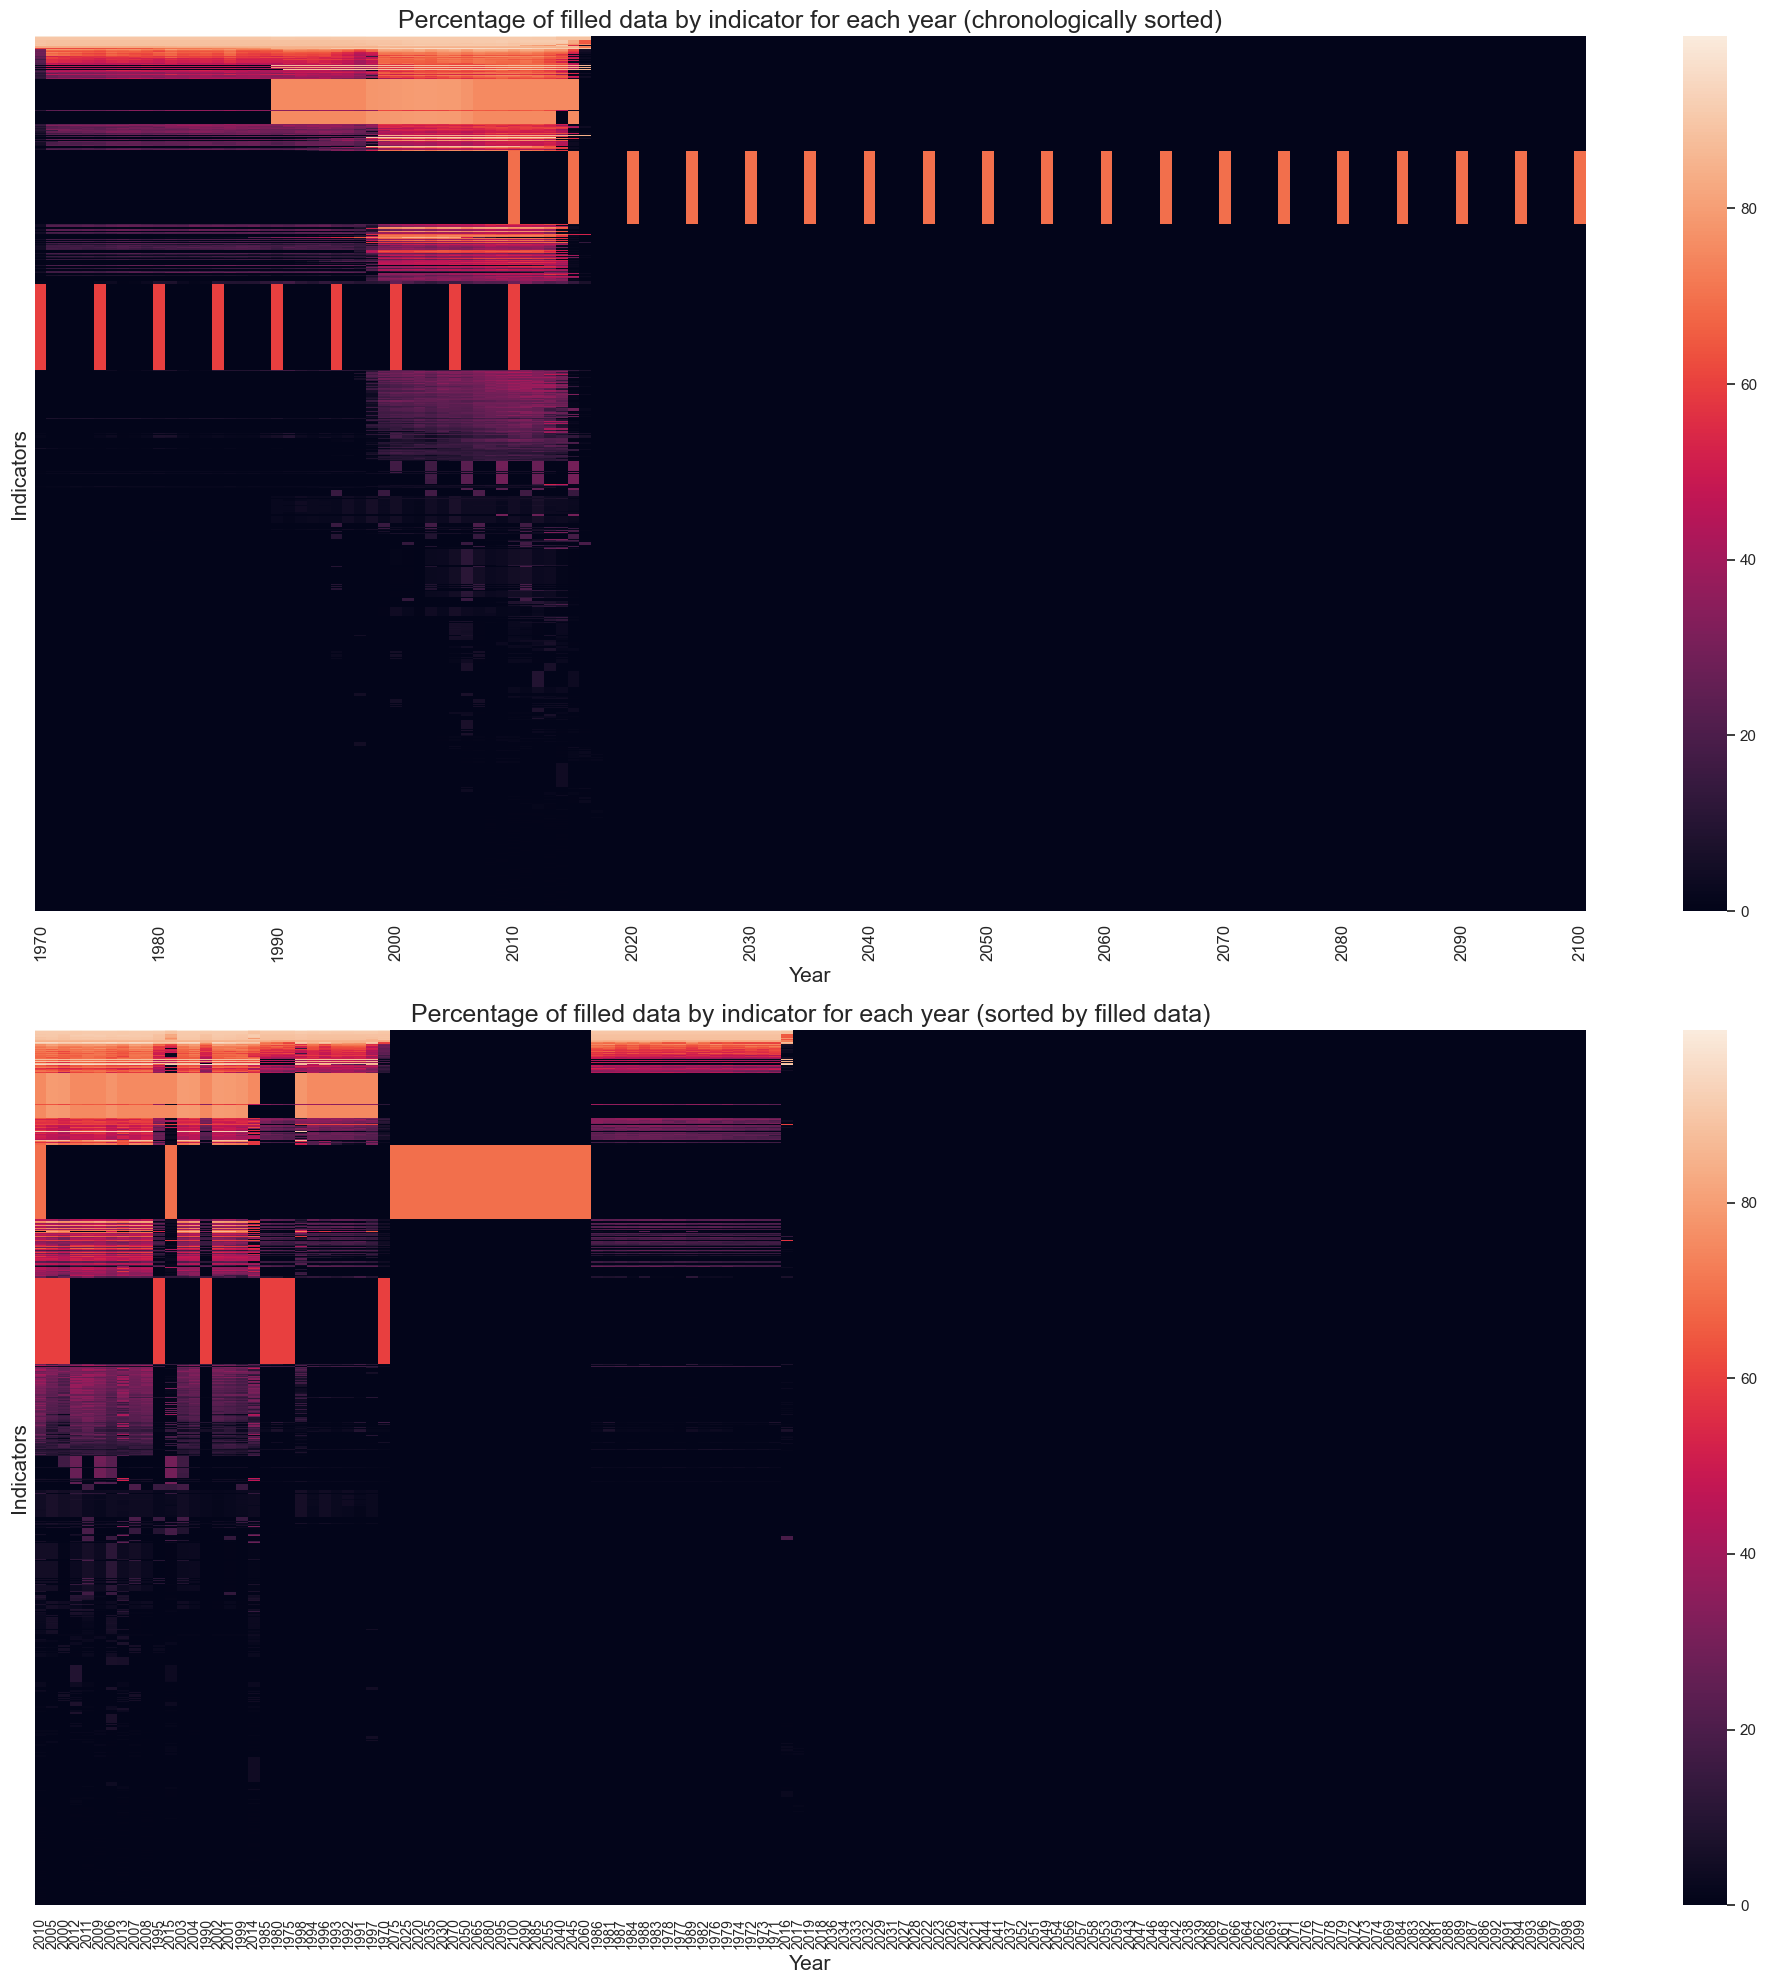

In [55]:
produce_heatmaps(prepare_data_heatmaps(ed_stats_data))

Years which have the most data available are : 1990, 1995, and all the years from 1999 to 2015.
We'll only consider the ones that are the most recent for the rest of this analysis : from 1999 to 2015.

In [56]:
# save ed_stats_data before applying changes to it, just in case 
original_ed_stats_data = ed_stats_data.copy()

In [57]:
# Only keep relevant columns in ed_stats_data DataFrame
irrelevant_years = [y for y in ed_stats_data.columns[ed_stats_data.columns.str.isnumeric()] if int(y) < 1999 or int(y) > 2015]
ed_stats_data.drop(columns=irrelevant_years, inplace=True)

__Focus on similar-colored bars appearing at regular intervals on heatmap "Percentage of filled data by indicator for each year (chronologically sorted)"__

- The similar-colored bars appearing at regular intervals between 2010 and 2100 correspond to all projections mentioned above. They belong to "Attainment" topic. They are about educational level of the population for a given age group.  
  &rarr; This is ot the focus for the moment. However, might be useful to predict demographic score later.
- Other bars of similar color between 1970 and 2010 correspond to all Barro-Lee indicators. They also belong to "Attainment" topic and are also about educational level of the population for a given age group.  
  &rarr; Although these indicators could be interesting in theory, there is not enough years covered. They will not be used in this analysis.   

It will be considered that indicators need to have percentage of filled data of at least 10% (~25 countries) on 3 years to have a chance to be estimated with other indicators.  
Let's filter those in order to have a better overview of the available data and choose the msot relevant year.

In [58]:
treshold_filled_data = 10
treshold_count_years = 3

filled_data_percentage = get_filled_data_percentage(ed_stats_data, inds=all_indicators, countries=all_countries)
filled_data_percentage.drop(columns=["Mean Filled Percentage"], inplace=True)
count_years_over_threshold = (filled_data_percentage > treshold_filled_data).sum(axis=1)
insufficient_data_indicators = count_years_over_threshold[count_years_over_threshold <= treshold_count_years].index.tolist()
print(f"{len(insufficient_data_indicators)} indicators have insufficient data and will not be considered in this analysis.")

ed_stats_data = ed_stats_data.loc[~ed_stats_data["Indicator Code"].isin(insufficient_data_indicators)]

2416 indicators have insufficient data and will not be considered in this analysis.


On the other hand, it will be considered that countries need to have percentage of filled data of at least 2% (~25 indicators) 
on 3 years to have a chance to be estimated with other countries.
Let's also filter those.

In [59]:
treshold_filled_data = 2
treshold_count_years = 3

filled_data_percentage = get_filled_data_percentage(ed_stats_data, inds=all_indicators, countries=all_countries, groupby="Country Code")
filled_data_percentage.drop(columns=["Mean Filled Percentage"], inplace=True)
count_years_over_threshold = (filled_data_percentage > treshold_filled_data).sum(axis=1)
insufficient_data_countries = count_years_over_threshold[count_years_over_threshold <= treshold_count_years].index.tolist()
print(f"{len(insufficient_data_countries)} countries have insufficient data and will not be considered in this analysis.")

ed_stats_data = ed_stats_data.loc[~ed_stats_data["Country Code"].isin(insufficient_data_countries)]

12 countries have insufficient data and will not be considered in this analysis.


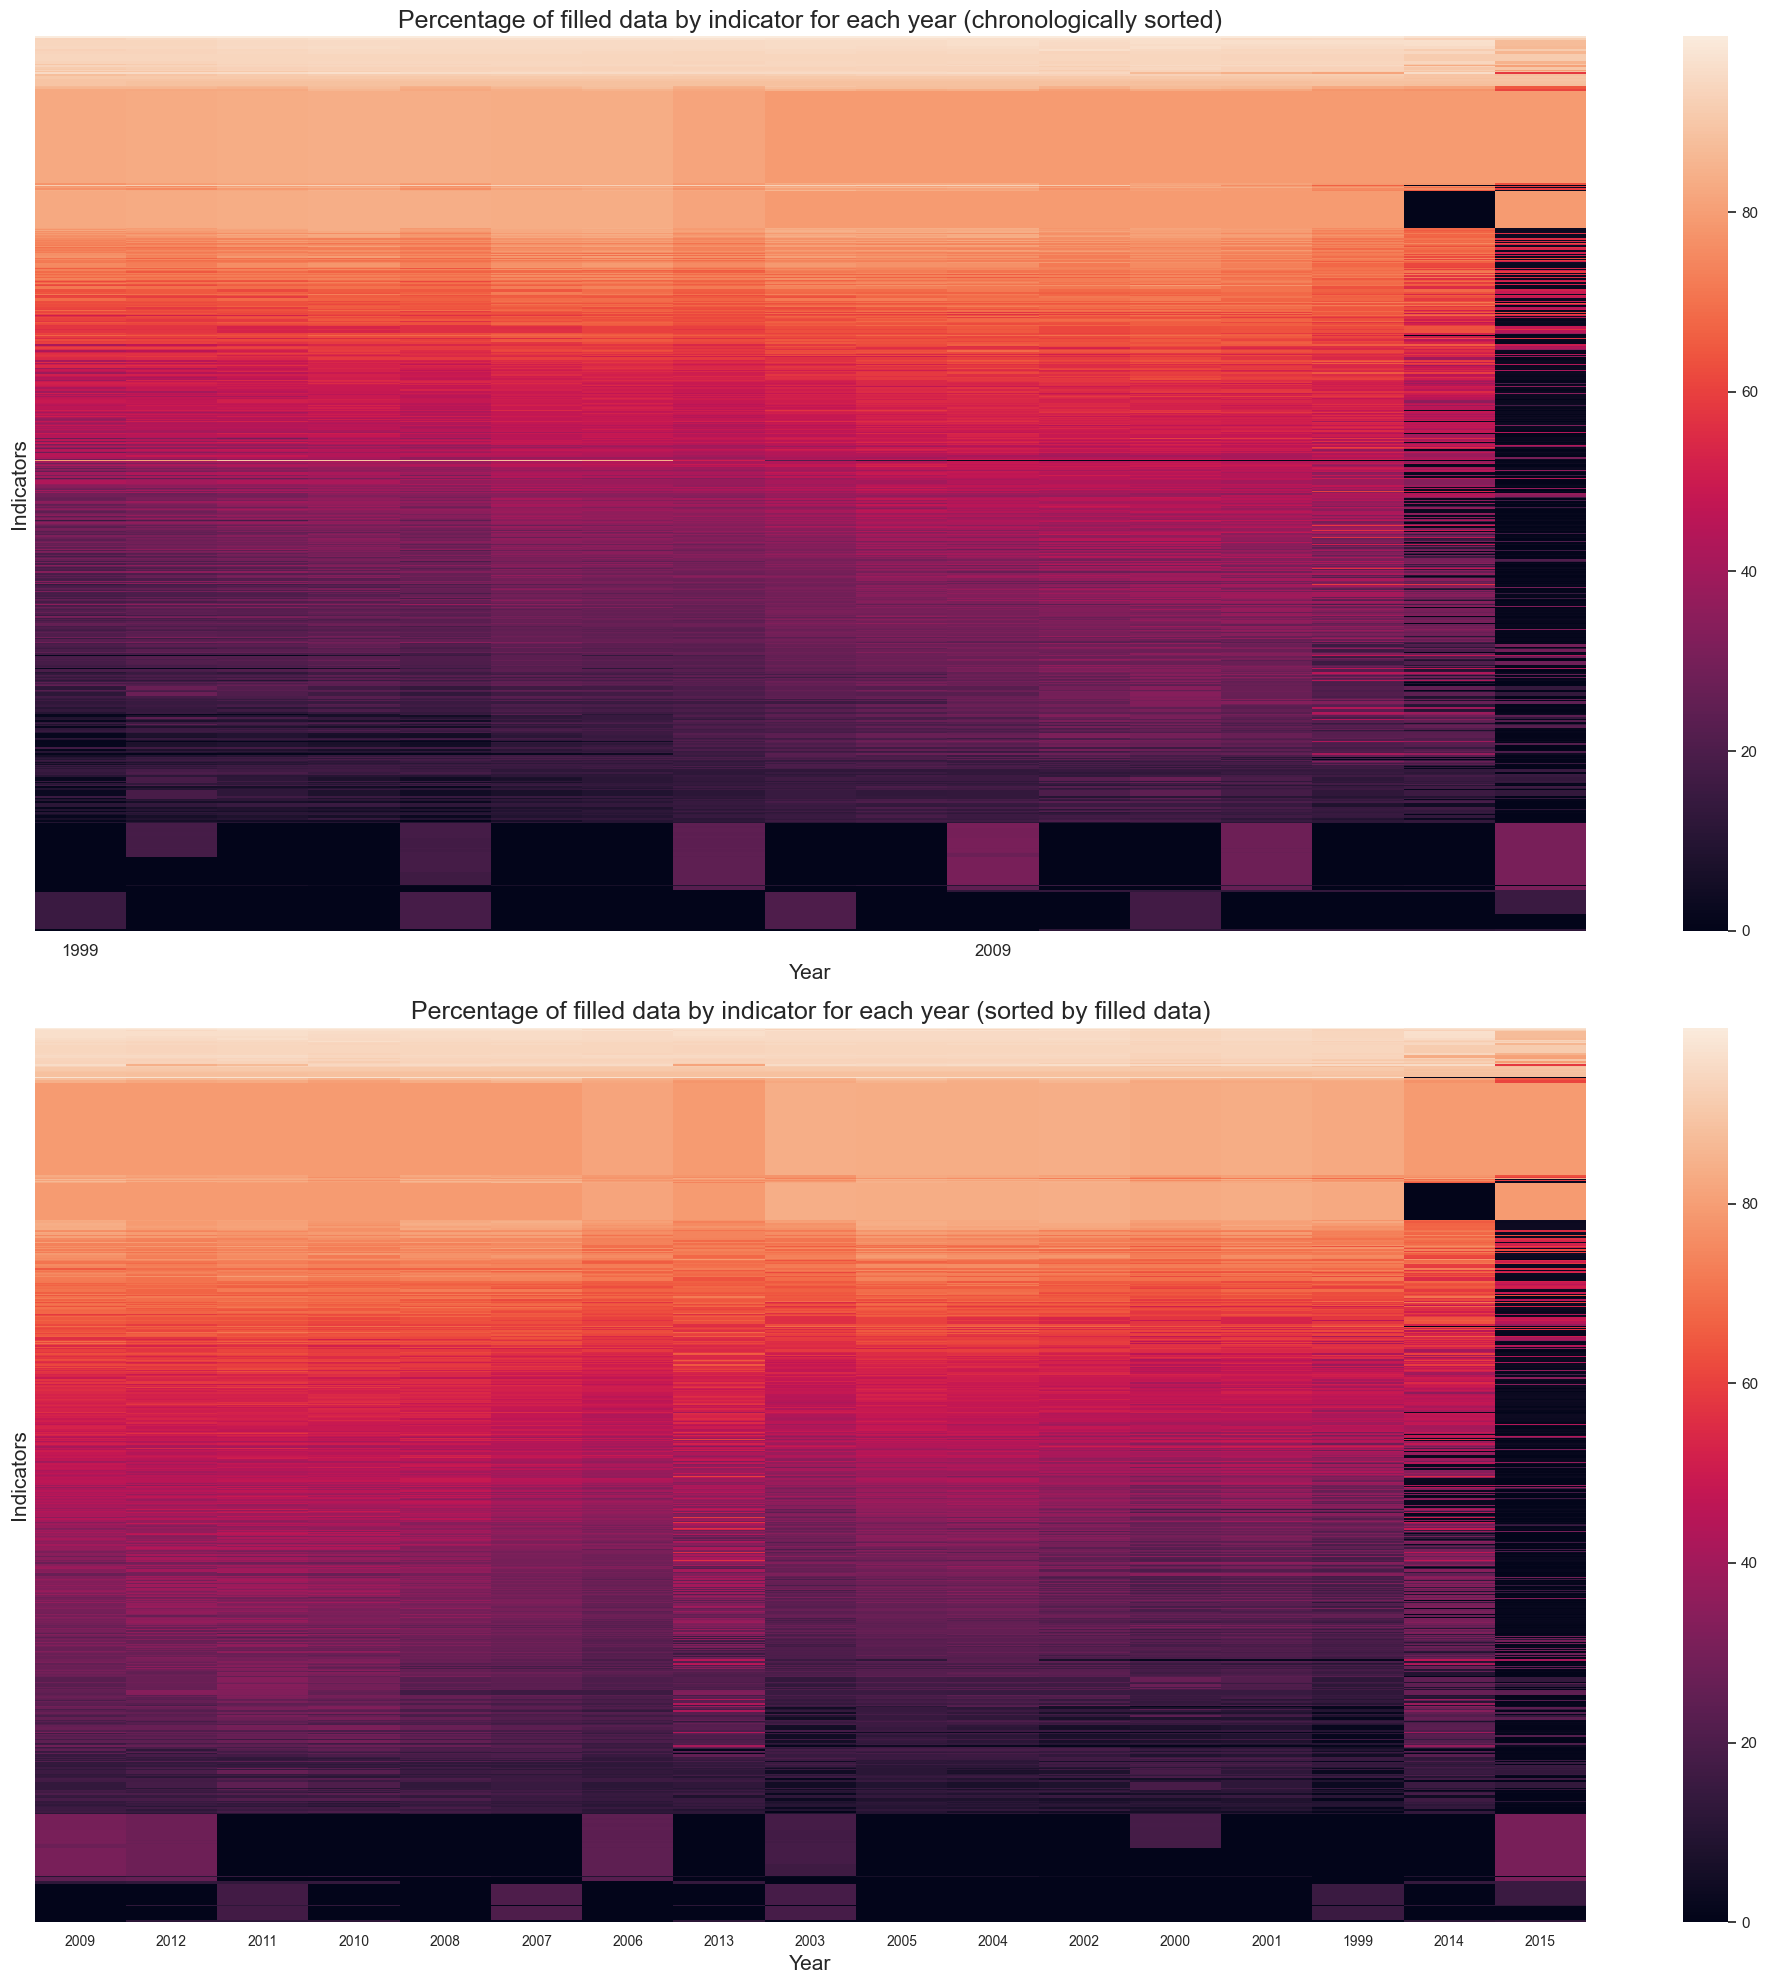

In [60]:
produce_heatmaps(prepare_data_heatmaps(ed_stats_data))

**2012 will be considered as the most relevant year from now on because it contains almost as much data as 2009 (48.37% vs 48.27%). It is also one of the most recent years (considering 2015 is the most recent among relevant years).**

Other columns will still be kept in the analysis to perform linear regression on time and to have a global overview of data availibility.

In [61]:
# Filter ed_stats_series
ed_stats_series = ed_stats_series.loc[~ed_stats_series["Series Code"].isin(insufficient_data_indicators)]

In [62]:
# Filter ed_stats_countries
ed_stats_country = ed_stats_country.loc[~ed_stats_country["Country Code"].isin(insufficient_data_countries)]

In [63]:
# Update generic lists of countries. Most analysis will be done without aggregates
all_countries = ed_stats_country["Country Code"].tolist()
countries_not_aggregates = ed_stats_country.loc[~(ed_stats_country["isAggregate"]), "Country Code"].tolist()

In [64]:
# Update generic list of indicators.
all_indicators = ed_stats_data["Indicator Code"].unique().tolist()

In [65]:
# Update generic list of years
all_years = ed_stats_data.columns[ed_stats_data.columns.str.isnumeric()].tolist()

## Determine relevant indicators

### Demographic Score

Available indicators use 2011 ISDEC standards to define educational level. Based on [equivalence with France](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjA7-j10aaJAxVKTaQEHTUzKBsQFnoECBIQAQ&url=https%3A%2F%2Fwww.education.gouv.fr%2Fmedia%2F21752%2Fdownload&usg=AOvVaw0fK4gIFKBgeYEBgtrAfvyp&opi=89978449), here's how population of potential customers is defined in this analysis in ISDEC standards:

- High school students (ISDEC 2 completed)
- University students (ISDEC 3 to 6 completed. ISDEC 8 are doctoral or equivalent. Depending on how indicators are build, they might be part of this analysis.)
- People aged between 25 and 60 with at least high school level. Corresponding to people who could be in professional transition. (At least ISDEC 2 completed)

Here are relevant indicators to define Demographic Score, based on their definition:

- UIS.E.3
- UIS.E.4
- UIS.E.5.B
- SE.SEC.ENRL
- SE.TER.ENRL
- UIS.EA.3T6.AG25T99

In [66]:
pd.options.display.max_colwidth = 200
demo_score_inds = ["UIS.E.3", "UIS.E.4", "UIS.E.5.B", "SE.SEC.ENRL", "SE.TER.ENRL", "UIS.EA.3T6.AG25T99"]
ed_stats_series.loc[ed_stats_series["Series Code"].isin(demo_score_inds), ["Series Code", "Topic", "Indicator Name"]]

Series Code       Topic  \
2294         SE.SEC.ENRL   Secondary   
2332         SE.TER.ENRL    Tertiary   
2825             UIS.E.3   Secondary   
2835             UIS.E.4    Tertiary   
2841           UIS.E.5.B    Tertiary   
2866  UIS.EA.3T6.AG25T99  Attainment   

                                                                                                          Indicator Name  
2294                                                               Enrolment in secondary education, both sexes (number)  
2332                                                Enrolment in tertiary education, all programmes, both sexes (number)  
2825                                                         Enrolment in upper secondary education, both sexes (number)  
2835                                             Enrolment in post-secondary non-tertiary education, both sexes (number)  
2841                                            Enrolment in tertiary education, ISCED 5 programmes, both sexes (number)  
2866  UIS: Percentage of population age 25+ with at least completed upper secondary education (ISCED 3 or higher). Total

In [67]:
get_filled_data_percentage(ed_stats_data, inds=demo_score_inds, countries=countries_not_aggregates)

1999       2000       2001       2002       2003  \
Indicator Code                                                              
SE.SEC.ENRL         74.019608  72.549020  73.529412  73.039216  71.078431   
UIS.E.3             73.529412  72.549020  73.039216  73.529412  71.568627   
SE.TER.ENRL         64.705882  60.294118  59.803922  64.705882  65.686275   
UIS.E.5.B           46.568627  45.588235  43.137255  45.098039  48.529412   
UIS.E.4             39.215686  42.156863  43.137255  38.235294  39.705882   
UIS.EA.3T6.AG25T99   1.960784   8.333333  10.294118   6.862745   5.392157   

                         2004       2005       2006       2007       2008  \
Indicator Code                                                              
SE.SEC.ENRL         76.960784  76.960784  72.549020  76.470588  75.490196   
UIS.E.3             76.960784  76.960784  73.529412  75.980392  74.509804   
SE.TER.ENRL         65.196078  63.235294  63.235294  62.745098  65.686275   
UIS.E.5.B           46.568627  45.098039  43.627451  45.098039  49.019608   
UIS.E.4             38.235294  36.764706  34.313725  37.254902  36.764706   
UIS.EA.3T6.AG25T99  13.235294  16.176471  23.529412  26.960784  29.411765   

                         2009       2010       2011       2012       2013  \
Indicator Code                                                              
SE.SEC.ENRL         74.509804  73.529412  75.980392  72.549020  68.627451   
UIS.E.3             74.509804  73.039216  75.490196  74.019608  68.627451   
SE.TER.ENRL         66.666667  68.627451  69.607843  68.627451  64.215686   
UIS.E.5.B           48.529412  51.960784  51.960784  52.941176  45.098039   
UIS.E.4             35.784314  34.313725  34.803922  36.274510  40.686275   
UIS.EA.3T6.AG25T99  30.392157  36.274510  34.313725  29.901961  26.960784   

                         2014       2015  Mean Filled Percentage  
Indicator Code                                                    
SE.SEC.ENRL         68.137255  59.803922               72.693195  
UIS.E.3             57.352941   3.431373               68.742791  
SE.TER.ENRL         60.294118  52.941176               63.898501  
UIS.E.5.B           38.725490   1.960784               44.088812  
UIS.E.4             31.862745   0.980392               35.322953  
UIS.EA.3T6.AG25T99  31.372549  26.960784               21.078431

In [68]:
def melt_and_pivot_df(filtered_df:pd.DataFrame, inds:list=all_indicators) -> pd.DataFrame:  
    '''
    Melts and pivots a DataFrame to reshape it for analysis.

    Parameters:
    filtered_df (pd.DataFrame): DataFrame to reshape.
    inds (list): List of indicator codes. Defaults to all_indicators.

    Returns:
    pd.DataFrame: Reshaped DataFrame with indicators as columns.
    '''
    # Check if df is already pivoted
    if set(filtered_df.select_dtypes(include=[np.number]).columns).issubset(inds):
        return filtered_df

    not_numeric_columns = filtered_df.columns[~filtered_df.columns.str.isnumeric()].to_list()

    melted_df = filtered_df.melt(id_vars=not_numeric_columns, var_name="Year", value_name="Value")
    grouped_df = melted_df.groupby([c for c in melted_df.columns if c not in ["Indicator Name", "Value"]])["Value"].sum(min_count=1)
    unstacked_df = grouped_df.unstack('Indicator Code').reset_index()
    return unstacked_df

In [69]:
# Apply a list of functions to transform the data
def transform_data(df:pd.DataFrame, funcs:list[Callable]):
    '''
    Applies a list of functions to transform the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame to transform.
    funcs (list[Callable]): List of functions to apply to the DataFrame.

    Returns:
    pd.DataFrame: Transformed DataFrame.
    '''
    df_copy = df.copy()
    if funcs is not None and len(funcs) > 0:
        for f in funcs:
            try:
                # Iterate over numeric columns
                for col in df_copy.select_dtypes(include=[np.number]).columns:
                    df_copy[col] = f(df_copy[col])
            except AttributeError:
                df_copy = f(df_copy)

    return df_copy

In [70]:
def remove_outliers(s: pd.Series) -> pd.Series:
    '''
    Removes outliers from a Series based on the IQR method.

    Parameters:
    s (pd.Series): Series from which to remove outliers.

    Returns:
    pd.Series: Series with outliers replaced by NaN.
    '''
    s_copy = s.copy()
    
    q1 = s_copy.quantile(0.25)
    q3 = s_copy.quantile(0.75)
    iqr = q3 - q1

    # Define the bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Remove rows with outliers
    s_copy.loc[(s_copy < lower_bound) | (s_copy > upper_bound)] = np.nan

    return s_copy

In [71]:
def get_correlation_params(df:pd.DataFrame, ind_y, ind_x="Year"):
    '''
    Calculates linear regression parameters using Ordinary Least Squares (OLS).

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    ind_y: Dependent variable.
    ind_x (str): Independent variable. Defaults to "Year".

    Returns:
    tuple: Slope coefficient, intercept, R-squared, and R.
    '''
    df_copy = df.copy()

    # Calculate linear regression parameters using OLS method
    X = df_copy[[ind_x]]
    Y = df_copy[ind_y]

    # Add constant for OLS
    X = sm.add_constant(X)
    result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
    
    return result.params[ind_x], result.params['const'], result.rsquared, np.sqrt(result.rsquared)

In [72]:
def custom_style_and_predict(data:pd.DataFrame, ind_y:str, ind_x:str="Year", predict_df:pd.DataFrame=None, predict:bool=False, **kwgs):
    '''
    Applies custom styling to the plot and generates predictions based on linear regression.

    Parameters:
    data (pd.DataFrame): Data for the plot.
    ind_y (str): Dependent variable.
    ind_x (str): Independent variable. Defaults to "Year".
    predict_df (pd.DataFrame): DataFrame for predictions. Defaults to None.
    predict (bool): Whether to predict data. Defaults to False.
    **kws: Additional parameters for customization.

    Returns:
    pd.DataFrame: DataFrame with predictions if applicable.
    '''
    predictions_df = predict_df.copy()
    rsquared = None
    ax = plt.gca()
    # train_data = data.dropna()
    n = len(data)
    insufficent_data_text = AnchoredText(f"INSUFFICIENT DATA", loc='center', prop={'color':'red'})
    if n < 5:
        ax.add_artist(insufficent_data_text)
        return None, None
    else:
        a, b, rsquared, r = get_correlation_params(data, ind_x=ind_x, ind_y=ind_y)

        corr_text = AnchoredText(f"n = {n}\nR = {round(r, 2)}\nR² = {round(rsquared, 2)}", loc='upper left')
        ax.add_artist(corr_text)
        if predict and len(predictions_df) > 0:
            # Apply additional filter if there are any via col, row or hue parameters (regions, countries, or income group for example)
            filter_query = ' & '.join([f'`{col}` in {data[col].unique()}' for col in data if col not in [ind_x, ind_y]])
            if len(filter_query) > 0:
                predictions_df = predictions_df.query(filter_query)
            if rsquared >= 0.5:
                predictions_df.loc[:,ind_y] = a * predictions_df.loc[:,ind_x] + b
                
                return predictions_df, rsquared
        
    return None, rsquared    

In [73]:
def plot_correlation(df:pd.DataFrame, ind_y:str, ind_x:str="Year", suptitle:str='title', display:bool=True, predict_df:pd.DataFrame=None, predict:bool=False, **plot_params):
    '''
    Plots the correlation between two variables using a linear regression model.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    ind_y (str): Dependent variable.
    ind_x (str): Independent variable. Defaults to "Year".
    suptitle (str): Title for the plot. Defaults to 'title'.
    display (bool): Whether to display scatterplots. Defaults to True.
    predict_df (pd.DataFrame): DataFrame for predictions. Defaults to None.
    predict (bool): Whether to predict data. Defaults to False.
    **plot_params: Additional parameters for the plot.

    Returns:
    pd.DataFrame: Concatenated predictions from the plot.
    '''
    predictions = []
    rsquared_list = []
    sns.set_theme(palette="dark")
    g = sns.lmplot(x=ind_x, y=ind_y, data=df, ci=None, height=3, facet_kws={'sharex':False}, **plot_params)
    g.figure.set_figwidth(max(10, g.figure.get_figwidth()))
    g.set_titles(row_template='{row_name}', col_template='{col_name}')
    g.figure.suptitle(suptitle, size=16, y=1)
    
    # Set x-tick labels to include all years
    if ind_x == "Year":
       unique_years = sorted(predict_df[ind_x].unique())
       ticks = [y for y in unique_years if y % (len(unique_years) // 10) == 0]
       g.set(xticks=ticks, xticklabels=ticks)
        
    def wrapper(data, ind_y, ind_x="Year", predict_df:pd.DataFrame=None, predict=False, **kwgs):
        pred, rsquared = custom_style_and_predict(data, ind_y=ind_y, ind_x=ind_x, predict_df=predict_df, predict=predict, **kwgs)
        predictions.append(pred)
        rsquared_list.append(rsquared)

    g.map_dataframe(wrapper, ind_x=ind_x, ind_y=ind_y, predict_df=predict_df, predict=predict)
        
    if display:
        plt.show()
    else:
        plt.close()

    rsquared_list_without_none = [r for r in rsquared_list if r is not None]

    if len(rsquared_list_without_none) > 1:
        print(f"{len(rsquared_list) - len(rsquared_list_without_none)} correlation coefficients were not calculated due to lack of data.") # This number is not accurate because of the dropna in linreg function.
        print(f"Data cannot be predicted on {len([r for r in rsquared_list_without_none if r < 0.5])} missing data points due to insufficient correlation.")
        fig, ax = plt.subplots()
        sns.boxplot(rsquared_list_without_none, ax=ax)
        ax.set_ylim((0,1))
        fig.suptitle("Distribution of R²", size=16)
        ax.set_title(suptitle, fontsize = 12)
        corr_text = AnchoredText(f"n = {len(rsquared_list_without_none)}", loc='upper left')
        ax.add_artist(corr_text)

    if all(p is None for p in predictions):
        return None
    return pd.concat(predictions)

In [74]:
def linreg(df:pd.DataFrame, years:list, countries:list, ind_to_predict:str, ind_x:str="Year", transforms:Optional[list[Callable]]=None, display:bool=True, predict:bool=False, **plot_params):
    '''
    Performs linear regression on specified indicators and plots the correlation.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    years (list): List of years to filter the data on.
    countries (list): List of countries to filter the data on.
    ind_to_predict (str): Indicator to predict.
    ind_x (str): Independent variable. Defaults to "Year".
    transforms (Optional[list[Callable]]): List of transformation functions. Defaults to None.
    display (bool): Whether to display scatterplots. Defaults to True.
    predict (bool): Whether to predict missing data. Defaults to False.
    **plot_params: Additional parameters for the plot.

    Returns:
    pd.DataFrame: DataFrame with updated values if predictions are made.
    '''
    df_copy = df.copy()

    if ind_x == "Year":
        # List of all the years in the columns of df
        int_years = [int(y) for y in years]
        
        # Prepare list of years to complete the missing years in the columns of df
        years_completed = pd.Series(range(min(int_years), max(int_years)+1)).astype(str)

        for y in years_completed:
            if not y in df_copy:
                df_copy[str(y)] = np.nan

    filtered_df = filter_df(df_copy, countries=countries, years=years, inds=[ind_to_predict, ind_x])

    pivoted_df = melt_and_pivot_df(filtered_df, [ind_to_predict, ind_x])

    if ind_x != "Year":
        ind_x_name = df_copy.loc[df_copy["Indicator Code"] == ind_x, "Indicator Name"].values[0]
    elif len(years) < 2:
        raise ValueError('List "years" needs to contain at least 2 years to perform linear regression.')
    else:
        # Force numeric type if ind_x="Year"
        pivoted_df[ind_x] = pivoted_df[ind_x].astype(int)
        ind_x_name = "Time"
    ind_y_name = df_copy.loc[df_copy["Indicator Code"] == ind_to_predict, "Indicator Name"].values[0]
    plot_suptitle = f"Correlation between '{ind_x_name}' and '{ind_y_name}' {"("+', '.join([f.__name__ for f in transforms])+")" if transforms is not None else ''}"

    predict_df = pivoted_df.loc[pivoted_df[ind_x].notna() & pivoted_df[ind_to_predict].isna()]

    transformed_df = transform_data(pivoted_df, transforms)
    
    # This dropna is necessary to use getCorrelationParams function later in custom_style_and_predict function.
    # Data could be dropped directly in custom_style_and_predict function to keep track of the number of countries with insufficient data easily.
    # However, it heavily impacts performance, this is why we drop nan values here and lose some information on the number of countries with insufficient data.
    # This number could still be recovered here by comparing daraframe before / after dropna.
    train_data = transformed_df.dropna()

    predictions_df = plot_correlation(train_data, ind_x=ind_x, ind_y=ind_to_predict, suptitle=plot_suptitle, display=display, predict_df=predict_df, predict=predict, **plot_params)

    if predict:
        if predictions_df is not None:
            predictions_df.dropna(subset=[ind_to_predict], inplace=True)
            pivoted_df_with_predictions = pivoted_df.fillna(predictions_df)

            pivoted_df_with_predictions["Year"] = pivoted_df_with_predictions["Year"].astype(str)

            # Restore the original shape of the input DataFrame
            grouped_df = pivoted_df_with_predictions.groupby([c for c in pivoted_df_with_predictions if c not in [ind for ind in [ind_to_predict, ind_x] if ind != "Year"]])[ind_to_predict].sum(min_count=1)

            unstacked_df = grouped_df.unstack('Year').reset_index()
            
            # Add "Indicator Name" and "Indicator Code" columns.
            unstacked_df["Indicator Code"] = ind_to_predict
            unstacked_df['Indicator Name'] = ind_y_name

            index = ["Country Code", "Indicator Code"]

            reindexed_df = unstacked_df.set_index(index)

            df_copy = df_copy.set_index(index)
            df_copy.update(reindexed_df)
            df_final = df_copy.reset_index()
            if predictions_df.shape[0] > 0:
                print(f'''Successfully estimated data for indicator '{ind_to_predict}' using '{ind_x}' {f"on {len([c for c in predictions_df["Country Name"].unique()])} countries : \n" + ", ".join([f"'{c}'" for c in predictions_df["Country Name"].unique()] if "Country Name" in predictions_df else '')}''')
            else:
                print(f'''No data to estimate, check dataframe content and passed arguments.''')
            return df_final
        else:
            print('No data could be predicted.')
            return df_copy

- The functions defined here allow to visualize correlation and predict data using linear regression between 2 chosen indicators for a given year, and a given list of countries.  
- They alternatively allow to visualize correlation and predict data using linear regression between 1 chosen indicator and time by providing a list of years.  
- User can choose to "display" scatterplots and "predict" data by passing corresponding arguments to the function.  
- User can also pass plot parameters (such as "hue", "col" or "row") as **kwgs to feed the lmplot function.
- If several correlations are done in one function (because of "hue", "col", or "row" parameters), boxplot of correlation coefficients is always displayed.

Predicting data for UIS.E.3
13 correlation coefficients were not calculated due to lack of data.
Data cannot be predicted on 8 missing data points due to insufficient correlation.
Successfully estimated data for indicator 'UIS.E.3' using 'Year' on 21 countries : 
'Angola', 'Bahamas, The', 'Benin', 'Cambodia', 'Comoros', 'Equatorial Guinea', 'Georgia', 'Gibraltar', 'Grenada', 'Iraq', 'Maldives', 'Mali', 'Mongolia', 'Myanmar', 'Namibia', 'Nicaragua', 'Senegal', 'Togo', 'Turks and Caicos Islands', 'Uganda', 'Vanuatu'
******************************
Predicting data for UIS.E.4
36 correlation coefficients were not calculated due to lack of data.
Data cannot be predicted on 15 missing data points due to insufficient correlation.
Successfully estimated data for indicator 'UIS.E.4' using 'Year' on 12 countries : 
'Belize', 'Colombia', 'Comoros', 'Ethiopia', 'Fiji', 'Georgia', 'Ghana', 'Cambodia', 'Kuwait', 'Namibia', 'Panama', 'Tunisia'
******************************
Predicting data for UIS.E.5

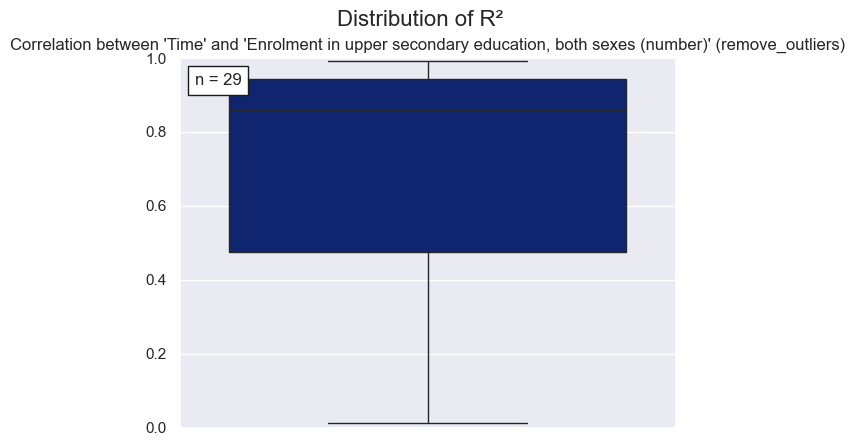

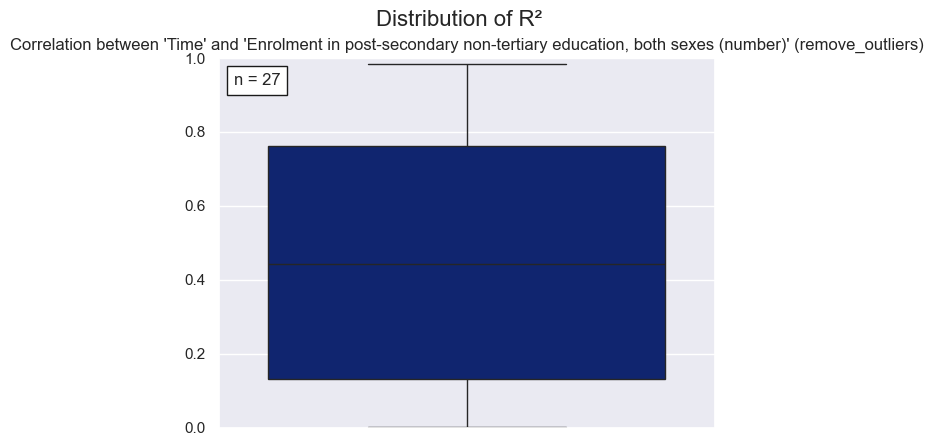

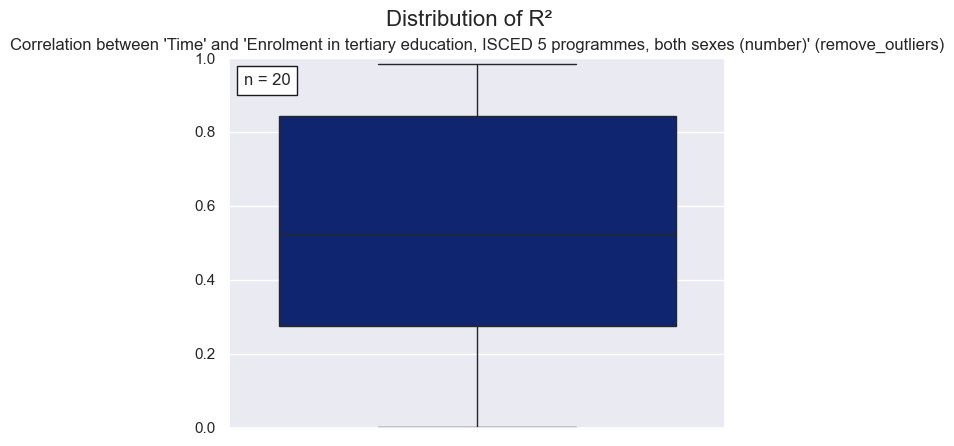

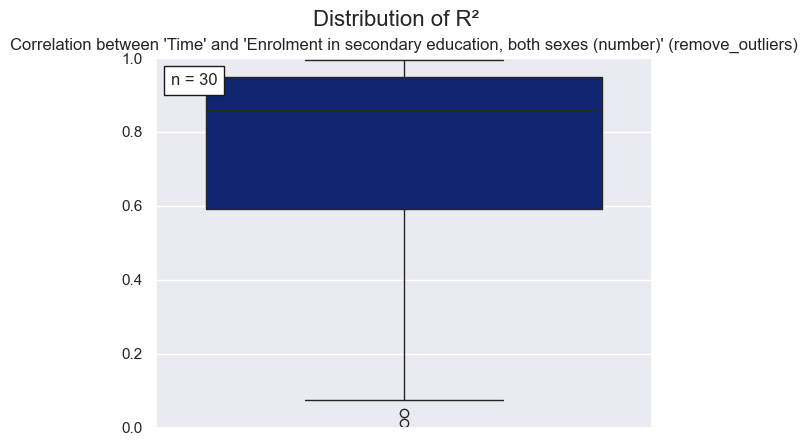

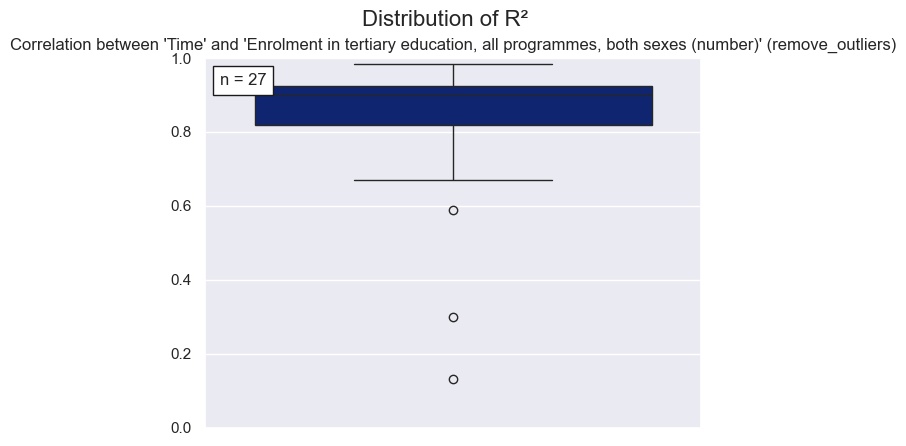

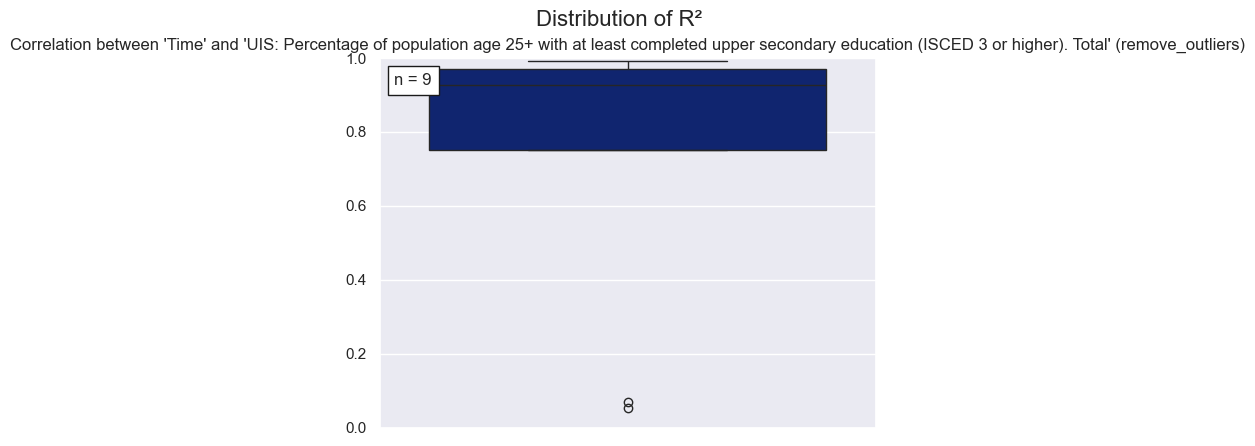

In [75]:
# Visualize correlation between Time and every demo_score_inds for countries with missing data in 2012.
# Also predicts values between 1999 and 2015 based on this correlation if correlation coefficient is above 0.5 and N >= 5
for ind in demo_score_inds:
    print(f"Predicting data for {ind}")
    countries_no_data_2012 = ed_stats_data.loc[(ed_stats_data["Indicator Code"] == ind) & (ed_stats_data["2012"].isna()) & (~(ed_stats_data["isAggregate"])), "Country Code"].values
    ed_stats_data = linreg(ed_stats_data, countries=countries_no_data_2012, ind_to_predict=ind, years=[str(y) for y in range(1999, 2016)], display=False, predict=True, hue="Country Code", transforms=[remove_outliers], legend=None)
    print(f"{"*"*30}")

In [76]:
get_filled_data_percentage(ed_stats_data, inds=demo_score_inds, countries=countries_not_aggregates)

1999       2000       2001       2002       2003  \
Indicator Code                                                              
SE.SEC.ENRL         74.509804  74.019608  76.470588  75.980392  75.000000   
UIS.E.3             74.509804  74.019608  76.470588  75.980392  74.509804   
SE.TER.ENRL         68.627451  63.725490  62.745098  66.666667  68.137255   
UIS.E.5.B           48.039216  47.549020  45.588235  48.039216  50.490196   
UIS.E.4             41.176471  42.647059  44.117647  40.196078  40.686275   
UIS.EA.3T6.AG25T99   5.392157  11.764706  13.235294  10.294118   8.333333   

                         2004       2005       2006       2007       2008  \
Indicator Code                                                              
SE.SEC.ENRL         78.921569  81.372549  77.941176  81.372549  80.392157   
UIS.E.3             78.431373  80.882353  77.941176  81.372549  79.901961   
SE.TER.ENRL         67.647059  68.137255  69.607843  69.117647  72.549020   
UIS.E.5.B           50.000000  48.529412  45.588235  48.039216  50.980392   
UIS.E.4             40.196078  40.196078  36.764706  39.215686  39.705882   
UIS.EA.3T6.AG25T99  16.666667  18.627451  24.509804  28.431373  29.901961   

                         2009       2010       2011       2012       2013  \
Indicator Code                                                              
SE.SEC.ENRL         81.372549  80.392157  83.333333  84.313725  77.450980   
UIS.E.3             80.392157  79.411765  83.823529  84.313725  75.980392   
SE.TER.ENRL         72.549020  75.000000  76.470588  80.882353  73.529412   
UIS.E.5.B           50.980392  54.411765  55.392157  57.843137  49.019608   
UIS.E.4             40.686275  39.705882  40.686275  42.156863  44.117647   
UIS.EA.3T6.AG25T99  30.882353  37.745098  36.274510  33.333333  29.411765   

                         2014       2015  Mean Filled Percentage  
Indicator Code                                                    
SE.SEC.ENRL         75.490196  66.666667               77.941176  
UIS.E.3             64.215686  13.235294               73.846597  
SE.TER.ENRL         69.607843  62.745098               69.867359  
UIS.E.5.B           42.156863   6.862745               47.029988  
UIS.E.4             36.274510   6.862745               38.552480  
UIS.EA.3T6.AG25T99  31.862745  26.960784               23.154556

In [77]:
def plot_distribution(data, title):
    if len(data) > 1:
        fig, ax = plt.subplots()
        sns.boxplot(data, ax=ax)
        ax.set_ylim((0, ax.get_ylim()[1]))
        fig.suptitle("Distribution of coefficients of variation", size=16)
        ax.set_title(title)
        corr_text = AnchoredText(f"n = {len(data)}", loc='upper left')
        ax.add_artist(corr_text)
        
        plt.plot()

In [78]:
def imputation(df:pd.DataFrame, ind_to_estimate:str, estimate_year:str, group:str, data_years:list=[], countries:list=all_countries, method:Callable=np.mean, useAggregateData:bool=False):
    '''
    Imputes missing values for a specified indicator in a DataFrame using group averages or a specified method.

    Parameters:
    df (pd.DataFrame): Original DataFrame.
    ind_to_estimate (str): Indicator code for imputation.
    predict_year (str): Year for which data needs to be predicted.
    group (str): Grouping variable for aggregation. Usually 'Country Code', 'Region' or 'Income Group'
    data_years (list): Years used to predict data. Defaults to None (in that case, is equal to predict_year)
    countries (list): List of countries to filter. Defaults to all countries.
    method (Callable): Imputation method (e.g., mean, median). Defaults to np.mean.
    useAggregateData (bool): Indicates whether to use aggregate (from "group") value.

    Returns:
    pd.DataFrame: DataFrame with imputed values for the specified indicator.
    '''
    if estimate_year not in data_years:
        data_years.append(estimate_year)
    
    supported_groups = ["Income Group", "Region", "Country Code"]
    if group not in supported_groups:
        raise NotImplementedError(f"{group} group is not supported.")
    elif group == "Country Code" and useAggregateData:
        raise ValueError(f"Cannot use aggregates data with group 'Country Code'.")
    elif group == "Country Code" and (len(data_years) == 0 or data_years == [estimate_year]) :
        raise ValueError(f"Group 'Country Code' needs at least 1 year that is different from predict_year.")
    
    df_copy = df.copy()
    
    ind_name = df_copy.loc[df_copy["Indicator Code"] == ind_to_estimate, "Indicator Name"].values[0]
    title = f"Data estimation for indicator '{ind_to_estimate}' on year {estimate_year} by imputating using '{method.__name__}'{"and aggregates data" if useAggregateData else ''}"

    filtered_df = filter_df(df, countries=countries, inds=[ind_to_estimate], years=data_years)
    
    pivoted_df = melt_and_pivot_df(filtered_df, inds=[ind_to_estimate])

    cv_list = []
    missing_data_countries = pivoted_df.loc[(pivoted_df[ind_to_estimate].isna()) & (pivoted_df["Year"] == estimate_year)]

    if missing_data_countries.shape[0] == 0:
        print(f"No data to estimate, check dataframe content and passed arguments.")
        return df_copy
    
    for i in missing_data_countries.index:
        group_name = pivoted_df.at[i, group]
        
        if group in ["Income Group", "Region"] and useAggregateData:
            group_values = pivoted_df.loc[pivoted_df["Country Name"] == group_name, ind_to_estimate].dropna().values
        else:
            group_values = pivoted_df.loc[pivoted_df[group] == group_name, ind_to_estimate].dropna().values

        if len(group_values) >= min(len(data_years), 5):
            cv = np.std(group_values)/abs(np.mean(group_values))
            cv_list.append(cv)
            if cv < 0.3:
                pivoted_df.at[i, ind_to_estimate] = method(group_values)

    print(f"{len(missing_data_countries["Country Code"].unique()) - len(cv_list)} missing data points could not be estimated due to insufficient data.")
    print(f"Data could not be estimated on {len([r for r in cv_list if r > 0.3])} missing data points because coefficient of variation was too high.")
    plot_distribution(cv_list, title)

    predicted_list = list(set(missing_data_countries["Country Name"].unique()) - set(pivoted_df.loc[(pivoted_df[ind_to_estimate].isna()) & (pivoted_df["Year"] == estimate_year), "Country Name"]))
    # Restore the original shape of the input DataFrame
    grouped_df = pivoted_df.groupby([c for c in pivoted_df if c not in [ind for ind in [ind_to_estimate] if ind != "Year"]])[ind_to_estimate].sum(min_count=1)

    unstacked_df = grouped_df.unstack('Year').reset_index()

    # Add "Indicator Name" and "Indicator Code" columns.
    unstacked_df["Indicator Code"] = ind_to_estimate
    unstacked_df['Indicator Name'] = ind_name

    index = ["Country Code", "Indicator Code"]

    reindexed_df = unstacked_df.set_index(index)

    df_copy = df_copy.set_index(index)

    df_copy.update(reindexed_df)
    df_final = df_copy.reset_index()
    if len(predicted_list) > 0:
        print(f'''Successfully estimated data for indicator '{ind_to_estimate}' on year {estimate_year} by imputating using '{method.__name__}' on {len(predicted_list)} countries :
{', '.join([c for c in predicted_list])}''')
    else:
        print("No data was estimated.")
    return df_final

- The functions defined here allow to visualize variation and predict data using imputation by chosen method (default is mean). 
- Imputation is done on a given year for a given list of countries, using data from other years for those same countries.  
- "group" is specified by the user, indicating if imputation should be done by "Country Code", or aggregates ("Region" or "Income Group")
- If imputation is done using aggregates, user can set "useAggregateData" argument to True to impute with aggregate value (instead of the mean of all values of countries corresponding to the given aggregate).
- Boxplot of coefficients of variation is always displayed.

Estimating data for indicator 'UIS.E.3'.
20 missing data points could not be estimated due to insufficient data.
Data could not be estimated on 0 missing data points because coefficient of variation was too high.
Successfully estimated data for indicator 'UIS.E.3' on year 2012 by imputating using 'mean' on 13 countries :
Uzbekistan, Marshall Islands, Philippines, Uruguay, Kiribati, Suriname, Barbados, Saudi Arabia, Kyrgyz Republic, Nigeria, Palau, Algeria, Tunisia
******************************
Estimating data for indicator 'UIS.E.4'.
101 missing data points could not be estimated due to insufficient data.
Data could not be estimated on 10 missing data points because coefficient of variation was too high.
Successfully estimated data for indicator 'UIS.E.4' on year 2012 by imputating using 'mean' on 8 countries :
Liechtenstein, Tonga, Zimbabwe, Germany, Barbados, Israel, Trinidad and Tobago, Greece
******************************
Estimating data for indicator 'UIS.E.5.B'.
72 missing data

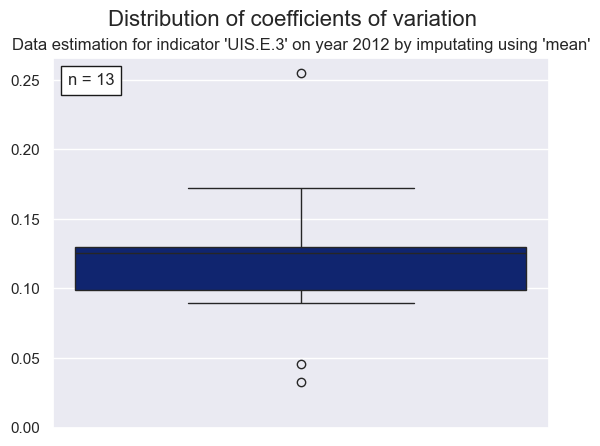

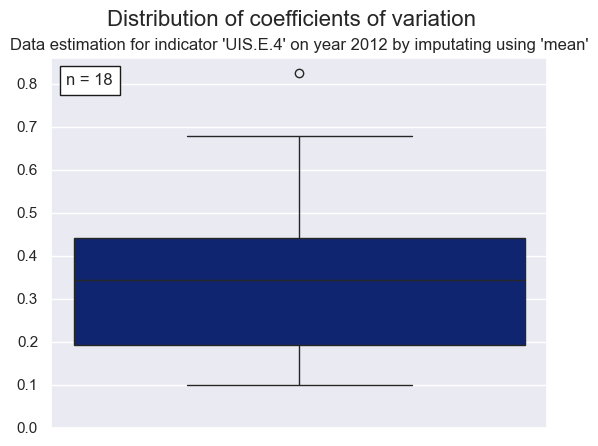

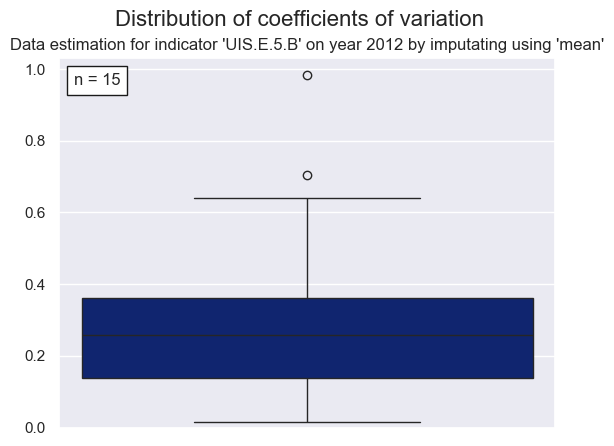

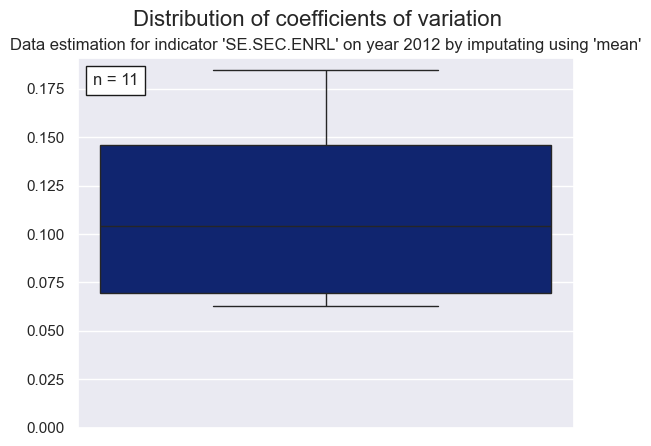

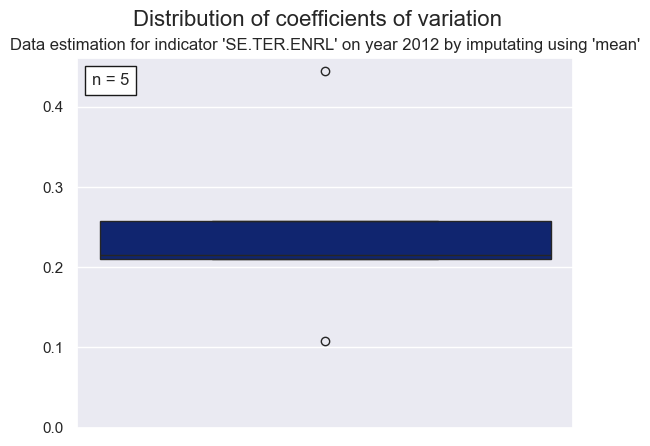

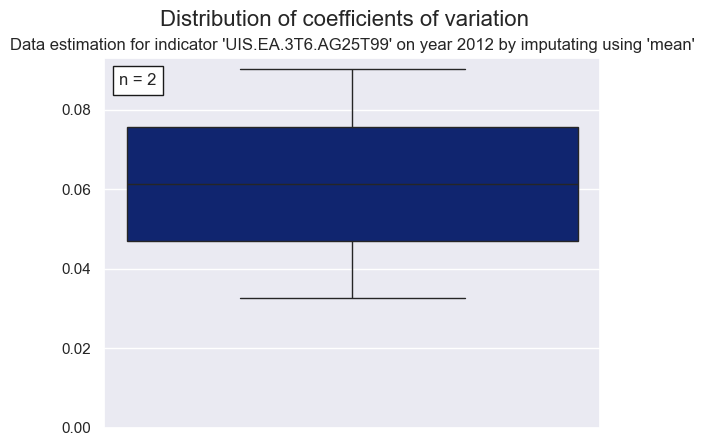

In [79]:
# Visualize variation of each demographic score indicator over time for countries with data missing in 2012.
# Also impute data with mean values of available values if coefficient of variation is below 0.3 and N >= 5
for ind in demo_score_inds:
    print(f"Estimating data for indicator '{ind}'.")
    countries_no_data_2012 = ed_stats_data.loc[(ed_stats_data["Indicator Code"] == ind) & (ed_stats_data["2012"].isna()) & (~(ed_stats_data["isAggregate"])), "Country Code"].values
    ed_stats_data = imputation(ed_stats_data, ind_to_estimate=ind, estimate_year="2012", data_years=[str(y) for y in range(1999, 2016)], countries=countries_no_data_2012, group="Country Code")
    print(f"{'*'*30}")

In [80]:
get_filled_data_percentage(ed_stats_data, inds=demo_score_inds, countries=countries_not_aggregates)

1999       2000       2001       2002       2003  \
Indicator Code                                                              
SE.SEC.ENRL         74.509804  74.019608  76.470588  75.980392  75.000000   
UIS.E.3             74.509804  74.019608  76.470588  75.980392  74.509804   
SE.TER.ENRL         68.627451  63.725490  62.745098  66.666667  68.137255   
UIS.E.5.B           48.039216  47.549020  45.588235  48.039216  50.490196   
UIS.E.4             41.176471  42.647059  44.117647  40.196078  40.686275   
UIS.EA.3T6.AG25T99   5.392157  11.764706  13.235294  10.294118   8.333333   

                         2004       2005       2006       2007       2008  \
Indicator Code                                                              
SE.SEC.ENRL         78.921569  81.372549  77.941176  81.372549  80.392157   
UIS.E.3             78.431373  80.882353  77.941176  81.372549  79.901961   
SE.TER.ENRL         67.647059  68.137255  69.607843  69.117647  72.549020   
UIS.E.5.B           50.000000  48.529412  45.588235  48.039216  50.980392   
UIS.E.4             40.196078  40.196078  36.764706  39.215686  39.705882   
UIS.EA.3T6.AG25T99  16.666667  18.627451  24.509804  28.431373  29.901961   

                         2009       2010       2011       2012       2013  \
Indicator Code                                                              
SE.SEC.ENRL         81.372549  80.392157  83.333333  89.705882  77.450980   
UIS.E.3             80.392157  79.411765  83.823529  90.686275  75.980392   
SE.TER.ENRL         72.549020  75.000000  76.470588  82.352941  73.529412   
UIS.E.5.B           50.980392  54.411765  55.392157  62.254902  49.019608   
UIS.E.4             40.686275  39.705882  40.686275  46.078431  44.117647   
UIS.EA.3T6.AG25T99  30.882353  37.745098  36.274510  34.313725  29.411765   

                         2014       2015  Mean Filled Percentage  
Indicator Code                                                    
SE.SEC.ENRL         75.490196  66.666667               78.258362  
UIS.E.3             64.215686  13.235294               74.221453  
SE.TER.ENRL         69.607843  62.745098               69.953864  
UIS.E.5.B           42.156863   6.862745               47.289504  
UIS.E.4             36.274510   6.862745               38.783160  
UIS.EA.3T6.AG25T99  31.862745  26.960784               23.212226

In [81]:
def build_corr_matrix_indicators(filtered_df:pd.DataFrame, indicators:list, transforms:Optional[list[Callable]]=None):
    '''
    Builds a correlation matrix between specified indicators.

    Parameters:
    filtered_df (pd.DataFrame): DataFrame containing the filtered data.
    indicators (list): List of indicators to include in the correlation matrix.
    transforms (Optional[list[Callable]]): List of transformation functions. Defaults to None.

    Returns:
    pd.DataFrame: Correlation matrix rounded to two decimal places.
    '''
    prepared_df = melt_and_pivot_df(filtered_df, indicators)

    transformed_df = transform_data(prepared_df, funcs=transforms)
    
    matrix = transformed_df.corr(min_periods=20, numeric_only=True).round(2)
    
    return matrix
    
def draw_heatmap(corr_matrix:pd.DataFrame, **plot_params):
    '''
    Draws a heatmap for the given correlation matrix.

    Parameters:
    corr_matrix (pd.DataFrame): Correlation matrix to visualize.
    '''
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    fig, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(corr_matrix, ax=ax, mask=mask, center=0, vmax=0.5, vmin=-0.5, **plot_params)
    ax.set_title("Correlation matrix (random sample of 100 indicators)")
    plt.plot()

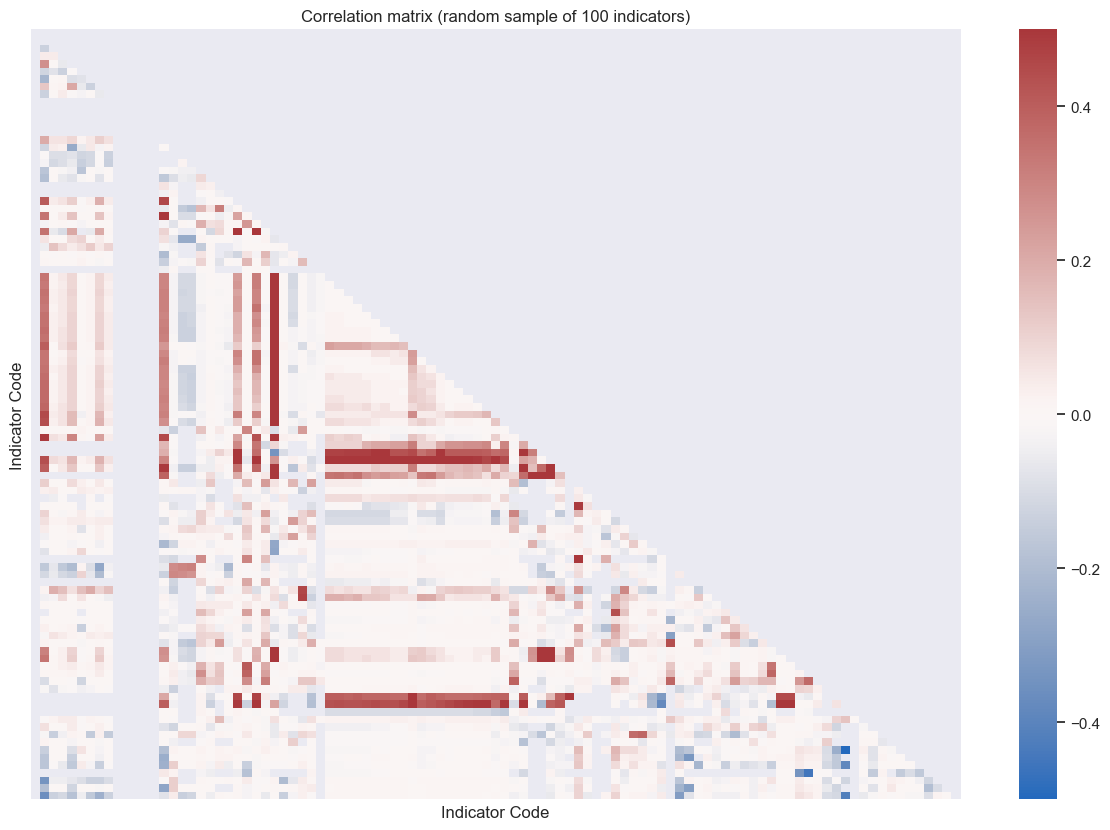

In [82]:
# Visualize if the correlations are resilient to outliers.
# Visualization of the difference between correlation matrix (with outliers) and correlation matrix (without outliers)
# Red means outliers have a positive impact on correlation ; Blue means negative impact
# Only bottom half of the matric is displayed for better readability
# Missing data corresponds to correlation for which number of individuals was below 20.

sample_indicators = random.sample(ed_stats_series["Series Code"].unique().tolist(), 100)
filtered_df = filter_df(ed_stats_data, countries=countries_not_aggregates, inds=sample_indicators, years=["2012"])
draw_heatmap((build_corr_matrix_indicators(filtered_df, indicators=sample_indicators)**2).round(2) - (build_corr_matrix_indicators(filtered_df, indicators=sample_indicators, transforms=[remove_outliers])**2).round(2), yticklabels=[], xticklabels=[], cmap='vlag')

As it is illustrated here, outliers can highly influence the correlation coefficient between 2 indicators. Indeed, some indicators include extremely high values (like total population of a country for example), but those values are not abnormal.

Therefore, for a given indicator for which we are seeking to estimate data, the choice of the other indicator used for linear regression will involve a compromise among:
- Minimizing the influence of extreme values on the R² correlation coefficient.
- Maximizing the R² correlation coefficient (calculated after removing extreme values).
- In order for the correlation coefficient to be meaningful, the number of common countries should be over 20 (around 10% of countries which are not aggregates).
- Maximizing the quantity of estimated data.

In [83]:
def build_corr_series_ind(filtered_df:pd.DataFrame, ind_to_estimate:str, candidates_inds:list, transforms:Optional[list[Callable]]=None):
    '''
    Builds a correlation series between a target indicator and a list of candidate indicators.

    Parameters:
    filtered_df (pd.DataFrame): DataFrame containing the filtered data.
    ind_to_estimate (str): Indicator to estimate.
    candidates_inds (list): List of candidate indicators for correlation.
    transforms (Optional[list[Callable]]): List of transformation functions. Defaults to None.

    Returns:
    pd.Series: Series containing correlation coefficients rounded to two decimal places.
    '''
    total_indicators = set(candidates_inds+[ind_to_estimate])
    
    prepared_df = melt_and_pivot_df(filtered_df, total_indicators)

    transformed_df = transform_data(prepared_df, funcs=transforms)

    series_ind_to_estimate = transformed_df[ind_to_estimate]
    df_candidates_inds = pd.DataFrame(transformed_df[candidates_inds])

    corr_series = df_candidates_inds.corrwith(series_ind_to_estimate, axis=0, numeric_only=True, method='pearson').round(2)
    
    return corr_series

In [84]:
def get_series_percentage_filled_data_missing_countries(filtered_df:pd.DataFrame, ind_to_estimate:str, candidates_inds:list):
    '''
    Calculates the percentage of missing data for candidate indicators based on a target indicator.

    Parameters:
    filtered_df (pd.DataFrame): DataFrame containing the filtered data.
    ind_to_estimate (str): Indicator to estimate.
    candidates_inds (list): List of candidate indicators.

    Returns:
    pd.Series: Series containing percentages of missing data for each candidate indicator.
    '''
    total_indicators = set(candidates_inds+[ind_to_estimate])

    prepared_df = melt_and_pivot_df(filtered_df, total_indicators)

    # Create a mask for countries without data for ind_to_estimate
    mask_no_data_ind_to_estimate = prepared_df[ind_to_estimate].isnull()
    mask_candidates = prepared_df[[ind for ind in candidates_inds if ind in prepared_df.columns]].notnull()

    # Calculate the number of countries without data for the target indicator
    n_countries_no_data_ind_to_estimate = mask_no_data_ind_to_estimate.sum()

    common_counts_no_data = (mask_candidates & mask_no_data_ind_to_estimate.values[:, None]).sum(axis=0)

    # Calculate percentages based on total countries without data for the target indicator
    percentages_no_data = (common_counts_no_data / n_countries_no_data_ind_to_estimate) if n_countries_no_data_ind_to_estimate > 0 else 0

    return pd.Series(percentages_no_data, index=candidates_inds)

In [85]:
def get_series_number_common_countries(filtered_df:pd.DataFrame, ind_to_estimate:str, candidates_inds:list):
    '''
    Calculates the number of common countries between a target indicator and candidate indicators.

    Parameters:
    filtered_df (pd.DataFrame): DataFrame containing the filtered data.
    ind_to_estimate (str): Indicator to estimate.
    candidates_inds (list): List of candidate indicators.

    Returns:
    pd.Series: Series containing the count of common countries for each candidate indicator.
    '''
    total_indicators = set(candidates_inds+[ind_to_estimate])
    
    prepared_df = melt_and_pivot_df(filtered_df, total_indicators)
    
    # Create boolean masks for non-null values
    mask_ind_to_estimate = prepared_df[ind_to_estimate].notnull()
    mask_candidates = prepared_df[[ind for ind in candidates_inds if ind in prepared_df.columns]].notnull()

    # Calculate the number of common countries for each indicator
    common_counts = (mask_candidates & mask_ind_to_estimate.values[:, None]).sum(axis=0)

    # Create a Series to return with the appropriate index
    return pd.Series(common_counts, index=candidates_inds)

In [86]:
# This function orders indicators (candidate_inds) in function of their "Interest Score" for a given list of countries, a given year and a given indicator.
# The higher the interest score, the more it should be interesting to perform the linear regression with this indicator.
# Interest Score is calculated based on previously mentioned criteria :
#   - Maximize R²
#   - Make sure that there is sufficient individuals for the correlation to be representative enough
#   - Maximize estimated data
#   - Minimize outliers influence 

def get_best_indicators_for_linreg(df:pd.DataFrame, ind_to_estimate:str, candidates_inds:list, year, countries:list):
    '''
    Orders candidate indicators based on their "Interest Score" for linear regression.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    ind_to_estimate (str): Indicator to estimate.
    candidates_inds (list): List of candidate indicators.
    year: Year for filtering.
    countries (list): List of countries for filtering.

    Returns:
    pd.DataFrame: DataFrame containing candidate indicators sorted by Interest Score.
    '''
    total_indicators = list(set(candidates_inds+[ind_to_estimate]))
    filtered_df = filter_df(df, countries=countries, inds=total_indicators, years=[str(year)])
    prepared_df = melt_and_pivot_df(filtered_df, total_indicators)
    
    # Initialize DataFrame
    df_best_inds_linreg = pd.DataFrame(index=candidates_inds)

    # Correlation series between a ind_to_estimate and candidates_inds.
    rsquared_series_without_outliers = build_corr_series_ind(prepared_df, ind_to_estimate, candidates_inds, [remove_outliers])**2
    df_best_inds_linreg["Correlation (R²)"] = rsquared_series_without_outliers.fillna(0)

    # Indicator to estimate and indicator used for the linear gression need to have a minimum number of countries in common for the data to be representative.
    # This column indicates if there is sufficient points on the scatterplot based on a threshold
    threshold = 20
    df_best_inds_linreg["Confidence"] = (get_series_number_common_countries(prepared_df, ind_to_estimate, candidates_inds) > threshold).astype(int)

    # Calculate the percentage of missing data that could be estimated by doing a linear regression with this indicator
    df_best_inds_linreg["Efficiency"] = get_series_percentage_filled_data_missing_countries(prepared_df, ind_to_estimate, candidates_inds)

    # Calculate the influence of outliers on the correlation
    outlier_influence_matrix = abs(rsquared_series_without_outliers - build_corr_series_ind(prepared_df, ind_to_estimate, candidates_inds)**2)
    df_best_inds_linreg["Outliers robustness"] = (1 - 2 * outlier_influence_matrix).fillna(0)

    df_best_inds_linreg["Interest Score"] = df_best_inds_linreg["Correlation (R²)"] + df_best_inds_linreg["Confidence"] + df_best_inds_linreg["Efficiency"] + df_best_inds_linreg["Outliers robustness"]

    df_best_inds_linreg = df_best_inds_linreg.round(2).sort_values(by="Interest Score", ascending=False)

    return df_best_inds_linreg

In [87]:
best_indicators_for_linreg = get_best_indicators_for_linreg(ed_stats_data, "UIS.E.3", all_indicators, "2012", countries_not_aggregates)
best_indicators_for_linreg.head(10)

c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation (R²)  Confidence  Efficiency  \
SP.POP.1564.MA.IN              0.76           1        0.95   
SP.POP.1564.TO                 0.74           1        0.95   
SP.POP.1564.FE.IN              0.72           1        0.95   
SP.POP.TOTL                    0.69           1        1.00   
NY.GNP.MKTP.PP.CD              0.45           1        0.74   
NY.GDP.MKTP.PP.KD              0.45           1        0.74   
SP.POP.TOTL.MA.IN              0.67           1        0.95   
NY.GDP.MKTP.PP.CD              0.44           1        0.74   
UIS.E.3.GPV.F                  0.90           1        0.21   
SL.TLF.TOTL.IN                 0.66           1        0.79   

                   Outliers robustness  Interest Score  
SP.POP.1564.MA.IN                 0.59            3.30  
SP.POP.1564.TO                    0.60            3.28  
SP.POP.1564.FE.IN                 0.56            3.23  
SP.POP.TOTL                       0.46            3.15  
NY.GNP.MKTP.PP.CD                 0.92            3.10  
NY.GDP.MKTP.PP.KD                 0.89            3.08  
SP.POP.TOTL.MA.IN                 0.42            3.04  
NY.GDP.MKTP.PP.CD                 0.86            3.04  
UIS.E.3.GPV.F                     0.92            3.04  
SL.TLF.TOTL.IN                    0.58            3.03

UIS.E.3.GPV.F is identified as a good candidate to perform linear regression, even though the efficiency is quite low.  
Let's build the functions to predict the values.

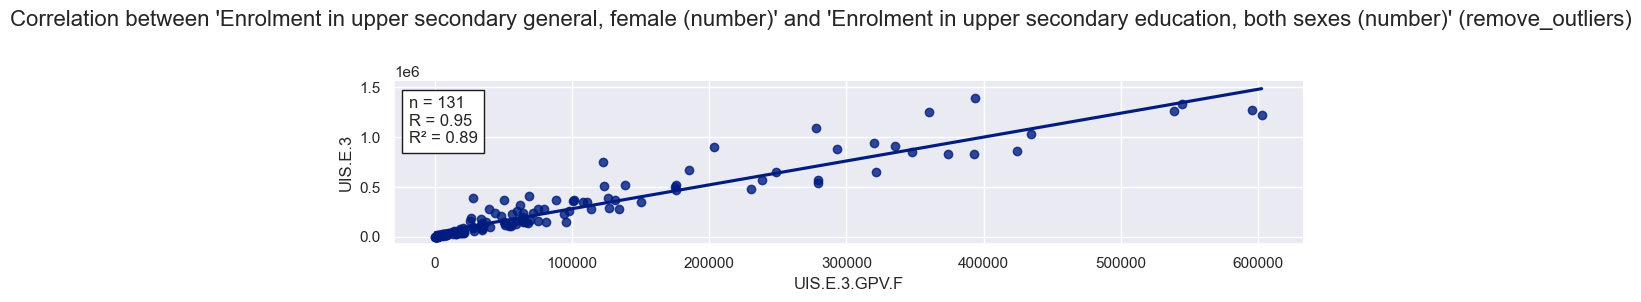

Successfully estimated data for indicator 'UIS.E.3' using 'UIS.E.3.GPV.F' on 4 countries : 
'Gambia, The', 'Tonga', 'Vietnam', 'Zambia'


In [88]:
ed_stats_data = linreg(ed_stats_data, countries=countries_not_aggregates, ind_x="UIS.E.3.GPV.F", ind_to_predict="UIS.E.3", years=["2012"], predict=True, transforms=[remove_outliers])

In [89]:
get_filled_data_percentage(ed_stats_data, inds=demo_score_inds, countries=countries_not_aggregates)

1999       2000       2001       2002       2003  \
Indicator Code                                                              
SE.SEC.ENRL         74.509804  74.019608  76.470588  75.980392  75.000000   
UIS.E.3             74.509804  74.019608  76.470588  75.980392  74.509804   
SE.TER.ENRL         68.627451  63.725490  62.745098  66.666667  68.137255   
UIS.E.5.B           48.039216  47.549020  45.588235  48.039216  50.490196   
UIS.E.4             41.176471  42.647059  44.117647  40.196078  40.686275   
UIS.EA.3T6.AG25T99   5.392157  11.764706  13.235294  10.294118   8.333333   

                         2004       2005       2006       2007       2008  \
Indicator Code                                                              
SE.SEC.ENRL         78.921569  81.372549  77.941176  81.372549  80.392157   
UIS.E.3             78.431373  80.882353  77.941176  81.372549  79.901961   
SE.TER.ENRL         67.647059  68.137255  69.607843  69.117647  72.549020   
UIS.E.5.B           50.000000  48.529412  45.588235  48.039216  50.980392   
UIS.E.4             40.196078  40.196078  36.764706  39.215686  39.705882   
UIS.EA.3T6.AG25T99  16.666667  18.627451  24.509804  28.431373  29.901961   

                         2009       2010       2011       2012       2013  \
Indicator Code                                                              
SE.SEC.ENRL         81.372549  80.392157  83.333333  89.705882  77.450980   
UIS.E.3             80.392157  79.411765  83.823529  92.647059  75.980392   
SE.TER.ENRL         72.549020  75.000000  76.470588  82.352941  73.529412   
UIS.E.5.B           50.980392  54.411765  55.392157  62.254902  49.019608   
UIS.E.4             40.686275  39.705882  40.686275  46.078431  44.117647   
UIS.EA.3T6.AG25T99  30.882353  37.745098  36.274510  34.313725  29.411765   

                         2014       2015  Mean Filled Percentage  
Indicator Code                                                    
SE.SEC.ENRL         75.490196  66.666667               78.258362  
UIS.E.3             64.215686  13.235294               74.336794  
SE.TER.ENRL         69.607843  62.745098               69.953864  
UIS.E.5.B           42.156863   6.862745               47.289504  
UIS.E.4             36.274510   6.862745               38.783160  
UIS.EA.3T6.AG25T99  31.862745  26.960784               23.212226

In 2012, there is still missing data for indicator "UIS.E.3".  
Let's use ANOVA to visualize its correlation with categories variables.

In [90]:
def eta_squared(x,y):
    '''
    Calculates the eta-squared statistic, a measure of effect size for categorical variables.

    Parameters:
    x (array-like): Categorical variable.
    y (array-like): Continuous variable.

    Returns:
    float: Eta-squared value representing the proportion of variance in y explained by x.
    '''
    y = y.dropna()
    moyenne_y = y.mean()
    classes = []
    for classe in x.dropna().unique():
        yi_classe = y[x==classe]
        if len(yi_classe) > 0:
            classes.append({'ni': len(yi_classe),
                            'moyenne_classe': yi_classe.mean()})
    
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])

    return SCE/SCT

In [91]:
def ANOVA(df, x:str, y:str, countries, inds, year, plot_function:Callable=sns.violinplot, transforms:Optional[list[Callable]]=None, **plot_params):
    '''
    Performs ANOVA analysis and visualizes the results using a specified plotting function.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    x (str): Categorical variable for grouping.
    y (str): Continuous variable for analysis.
    countries: List of countries to filter.
    inds: List of indicators to include.
    year: Year for filtering data.
    plot_function (Callable): Function for plotting results. Defaults to sns.violinplot.
    **plot_params: Additional parameters for the plotting function.

    Returns:
    None: Displays the plot with eta-squared value annotated.
    '''
    filtered_df = filter_df(df, countries=countries, inds=inds, years=[str(year)])
    
    pivoted_df = melt_and_pivot_df(filtered_df, inds)

    pivoted_df = pivoted_df.loc[pivoted_df[x] != "Undefined"]

    transformed_df = transform_data(pivoted_df, funcs=transforms)

    eta = round(eta_squared(transformed_df[x],transformed_df[y]), 2)

    fig, ax = plt.subplots(figsize=(20,5))
    plot_function(transformed_df, ax=ax, x=x, y=y, **plot_params)
    corr_test = AnchoredText(f"η² = {eta}", loc="upper left")
    ax.add_artist(corr_test)
    plt.plot()


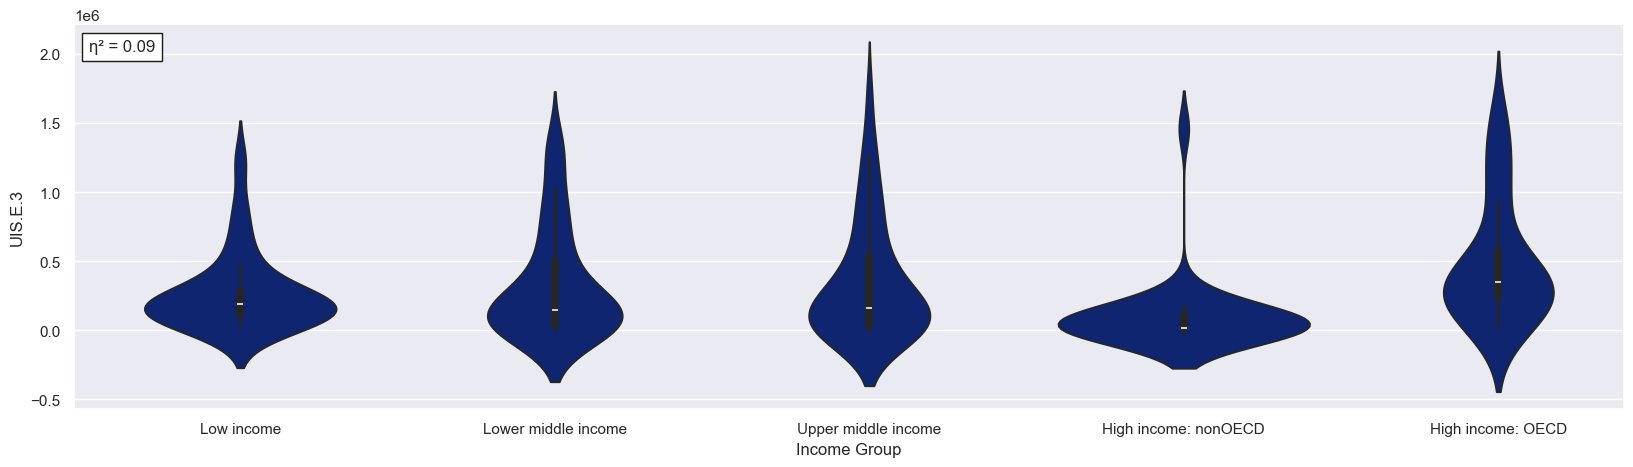

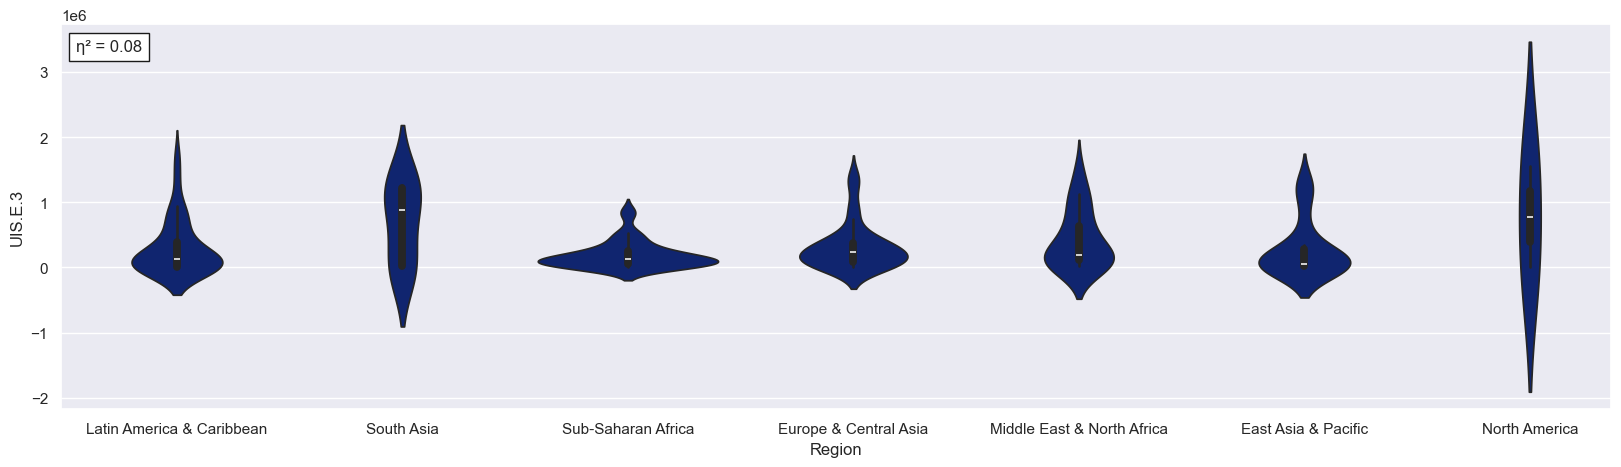

In [92]:
ANOVA(ed_stats_data, x="Income Group", y="UIS.E.3", countries=countries_not_aggregates, inds=all_indicators, year="2012", transforms=[remove_outliers], plot_function=sns.violinplot, order=["Low income", "Lower middle income", "Upper middle income", "High income: nonOECD", "High income: OECD"])
ANOVA(ed_stats_data, x="Region", y="UIS.E.3", countries=countries_not_aggregates, inds=all_indicators, year="2012", transforms=[remove_outliers], plot_function=sns.violinplot)

No imputation will be done using aggregates.  
Filled data percentage for "UIS.E.3" in 2012 is above 90%. It is considered enough. Let's proceed with the other indicators.

In [93]:
best_indicators_for_linreg = get_best_indicators_for_linreg(ed_stats_data, "SE.SEC.ENRL", all_indicators, "2012", countries_not_aggregates)
best_indicators_for_linreg.head(10)

c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation (R²)  Confidence  Efficiency  \
SP.POP.1564.MA.IN              0.88           1        0.95   
SP.POP.1564.TO                 0.88           1        0.95   
SP.POP.1564.FE.IN              0.86           1        0.95   
SP.POP.TOTL.MA.IN              0.86           1        0.95   
SP.POP.TOTL                    0.85           1        1.00   
SP.POP.TOTL.FE.IN              0.85           1        0.95   
SL.TLF.TOTL.IN                 0.81           1        0.81   
SP.POP.AG25.MA.UN              0.86           1        0.81   
SP.SEC.UTOT.IN                 0.81           1        0.90   
SP.POP.AG23.TO.UN              0.85           1        0.81   

                   Outliers robustness  Interest Score  
SP.POP.1564.MA.IN                 0.85            3.68  
SP.POP.1564.TO                    0.85            3.68  
SP.POP.1564.FE.IN                 0.81            3.63  
SP.POP.TOTL.MA.IN                 0.77            3.59  
SP.POP.TOTL                       0.73            3.58  
SP.POP.TOTL.FE.IN                 0.73            3.53  
SL.TLF.TOTL.IN                    0.85            3.47  
SP.POP.AG25.MA.UN                 0.77            3.44  
SP.SEC.UTOT.IN                    0.70            3.41  
SP.POP.AG23.TO.UN                 0.73            3.39

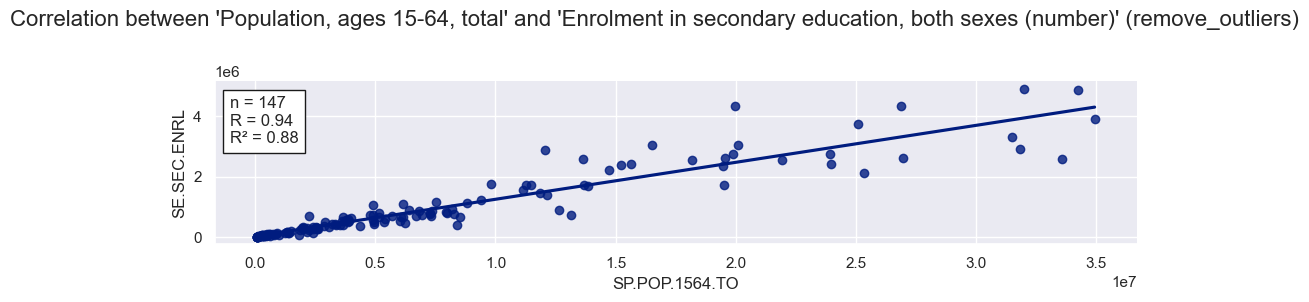

Successfully estimated data for indicator 'SE.SEC.ENRL' using 'SP.POP.1564.TO' on 20 countries : 
'United Arab Emirates', 'Azerbaijan', 'Cote d'Ivoire', 'Curacao', 'Micronesia, Fed. Sts.', 'Gabon', 'Gambia, The', 'Guinea-Bissau', 'Haiti', 'Libya', 'Korea, Dem. People’s Rep.', 'Singapore', 'Somalia', 'South Sudan', 'Turkmenistan', 'Trinidad and Tobago', 'Uganda', 'Virgin Islands (U.S.)', 'Vietnam', 'Zambia'


In [94]:
ed_stats_data = linreg(ed_stats_data, countries=countries_not_aggregates, ind_x="SP.POP.1564.TO", ind_to_predict="SE.SEC.ENRL", years=["2012"], predict=True, transforms=[remove_outliers])

In [95]:
get_filled_data_percentage(ed_stats_data, inds=demo_score_inds, countries=countries_not_aggregates)

1999       2000       2001       2002       2003  \
Indicator Code                                                              
SE.SEC.ENRL         74.509804  74.019608  76.470588  75.980392  75.000000   
UIS.E.3             74.509804  74.019608  76.470588  75.980392  74.509804   
SE.TER.ENRL         68.627451  63.725490  62.745098  66.666667  68.137255   
UIS.E.5.B           48.039216  47.549020  45.588235  48.039216  50.490196   
UIS.E.4             41.176471  42.647059  44.117647  40.196078  40.686275   
UIS.EA.3T6.AG25T99   5.392157  11.764706  13.235294  10.294118   8.333333   

                         2004       2005       2006       2007       2008  \
Indicator Code                                                              
SE.SEC.ENRL         78.921569  81.372549  77.941176  81.372549  80.392157   
UIS.E.3             78.431373  80.882353  77.941176  81.372549  79.901961   
SE.TER.ENRL         67.647059  68.137255  69.607843  69.117647  72.549020   
UIS.E.5.B           50.000000  48.529412  45.588235  48.039216  50.980392   
UIS.E.4             40.196078  40.196078  36.764706  39.215686  39.705882   
UIS.EA.3T6.AG25T99  16.666667  18.627451  24.509804  28.431373  29.901961   

                         2009       2010       2011       2012       2013  \
Indicator Code                                                              
SE.SEC.ENRL         81.372549  80.392157  83.333333  99.509804  77.450980   
UIS.E.3             80.392157  79.411765  83.823529  92.647059  75.980392   
SE.TER.ENRL         72.549020  75.000000  76.470588  82.352941  73.529412   
UIS.E.5.B           50.980392  54.411765  55.392157  62.254902  49.019608   
UIS.E.4             40.686275  39.705882  40.686275  46.078431  44.117647   
UIS.EA.3T6.AG25T99  30.882353  37.745098  36.274510  34.313725  29.411765   

                         2014       2015  Mean Filled Percentage  
Indicator Code                                                    
SE.SEC.ENRL         75.490196  66.666667               78.835063  
UIS.E.3             64.215686  13.235294               74.336794  
SE.TER.ENRL         69.607843  62.745098               69.953864  
UIS.E.5.B           42.156863   6.862745               47.289504  
UIS.E.4             36.274510   6.862745               38.783160  
UIS.EA.3T6.AG25T99  31.862745  26.960784               23.212226

In [96]:
best_indicators_for_linreg = get_best_indicators_for_linreg(ed_stats_data, "SE.TER.ENRL", all_indicators, "2012", countries_not_aggregates)
best_indicators_for_linreg.head(10)

c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation (R²)  Confidence  Efficiency  \
NY.GDP.MKTP.KD                 0.42           1        0.78   
NY.GDP.MKTP.CD                 0.42           1        0.81   
NY.GNP.MKTP.CD                 0.42           1        0.78   
SE.PRM.DURS                    0.01           1        1.00   
SE.TER.ENRL                    1.00           1        0.00   
UIS.E.3.PU.F                   0.67           1        0.36   
UIS.THAGE.3.A.GPV              0.02           1        0.97   
UIS.THAGE.0                    0.01           1        0.97   
SE.SEC.DURS.UP                 0.00           1        0.97   
SE.SEC.AGES                    0.01           1        0.97   

                   Outliers robustness  Interest Score  
NY.GDP.MKTP.KD                    0.84            3.04  
NY.GDP.MKTP.CD                    0.81            3.04  
NY.GNP.MKTP.CD                    0.81            3.01  
SE.PRM.DURS                       0.99            3.00  
SE.TER.ENRL                       1.00            3.00  
UIS.E.3.PU.F                      0.97            3.00  
UIS.THAGE.3.A.GPV                 0.99            2.99  
UIS.THAGE.0                       0.98            2.97  
SE.SEC.DURS.UP                    1.00            2.97  
SE.SEC.AGES                       0.98            2.97

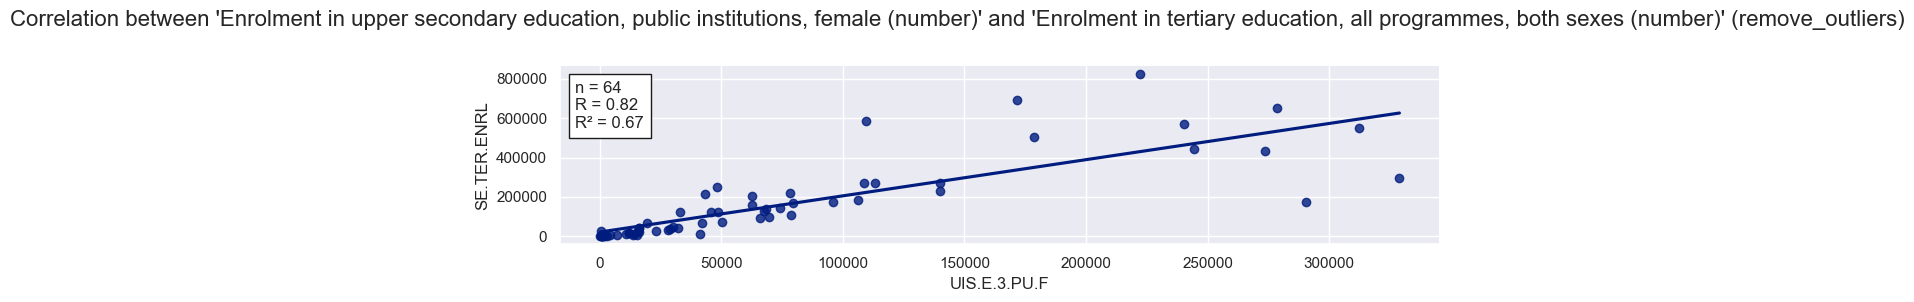

Successfully estimated data for indicator 'SE.TER.ENRL' using 'UIS.E.3.PU.F' on 13 countries : 
'Canada', 'Dominica', 'Guatemala', 'St. Kitts and Nevis', 'Monaco', 'Nauru', 'Papua New Guinea', 'Solomon Islands', 'Sierra Leone', 'Timor-Leste', 'St. Vincent and the Grenadines', 'Venezuela, RB', 'Samoa'


In [97]:
ed_stats_data = linreg(ed_stats_data, countries=countries_not_aggregates, ind_x="UIS.E.3.PU.F", ind_to_predict="SE.TER.ENRL", years=["2012"], predict=True, transforms=[remove_outliers])

In [98]:
get_filled_data_percentage(ed_stats_data, inds=demo_score_inds, countries=countries_not_aggregates)

1999       2000       2001       2002       2003  \
Indicator Code                                                              
SE.SEC.ENRL         74.509804  74.019608  76.470588  75.980392  75.000000   
UIS.E.3             74.509804  74.019608  76.470588  75.980392  74.509804   
SE.TER.ENRL         68.627451  63.725490  62.745098  66.666667  68.137255   
UIS.E.5.B           48.039216  47.549020  45.588235  48.039216  50.490196   
UIS.E.4             41.176471  42.647059  44.117647  40.196078  40.686275   
UIS.EA.3T6.AG25T99   5.392157  11.764706  13.235294  10.294118   8.333333   

                         2004       2005       2006       2007       2008  \
Indicator Code                                                              
SE.SEC.ENRL         78.921569  81.372549  77.941176  81.372549  80.392157   
UIS.E.3             78.431373  80.882353  77.941176  81.372549  79.901961   
SE.TER.ENRL         67.647059  68.137255  69.607843  69.117647  72.549020   
UIS.E.5.B           50.000000  48.529412  45.588235  48.039216  50.980392   
UIS.E.4             40.196078  40.196078  36.764706  39.215686  39.705882   
UIS.EA.3T6.AG25T99  16.666667  18.627451  24.509804  28.431373  29.901961   

                         2009       2010       2011       2012       2013  \
Indicator Code                                                              
SE.SEC.ENRL         81.372549  80.392157  83.333333  99.509804  77.450980   
UIS.E.3             80.392157  79.411765  83.823529  92.647059  75.980392   
SE.TER.ENRL         72.549020  75.000000  76.470588  88.725490  73.529412   
UIS.E.5.B           50.980392  54.411765  55.392157  62.254902  49.019608   
UIS.E.4             40.686275  39.705882  40.686275  46.078431  44.117647   
UIS.EA.3T6.AG25T99  30.882353  37.745098  36.274510  34.313725  29.411765   

                         2014       2015  Mean Filled Percentage  
Indicator Code                                                    
SE.SEC.ENRL         75.490196  66.666667               78.835063  
UIS.E.3             64.215686  13.235294               74.336794  
SE.TER.ENRL         69.607843  62.745098               70.328720  
UIS.E.5.B           42.156863   6.862745               47.289504  
UIS.E.4             36.274510   6.862745               38.783160  
UIS.EA.3T6.AG25T99  31.862745  26.960784               23.212226

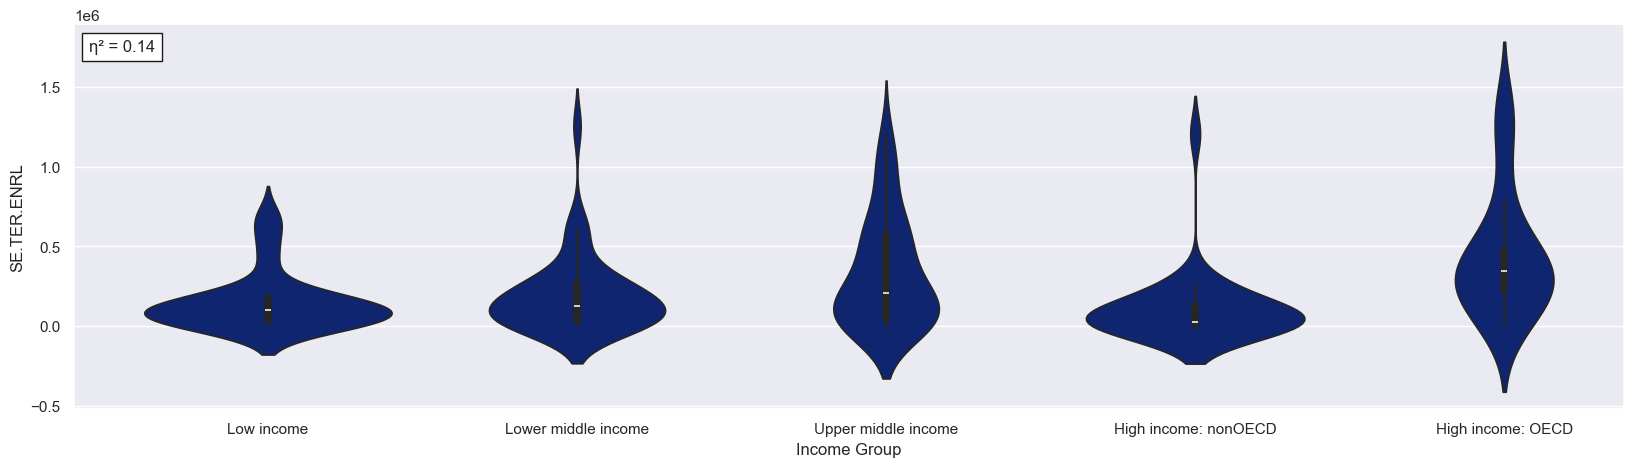

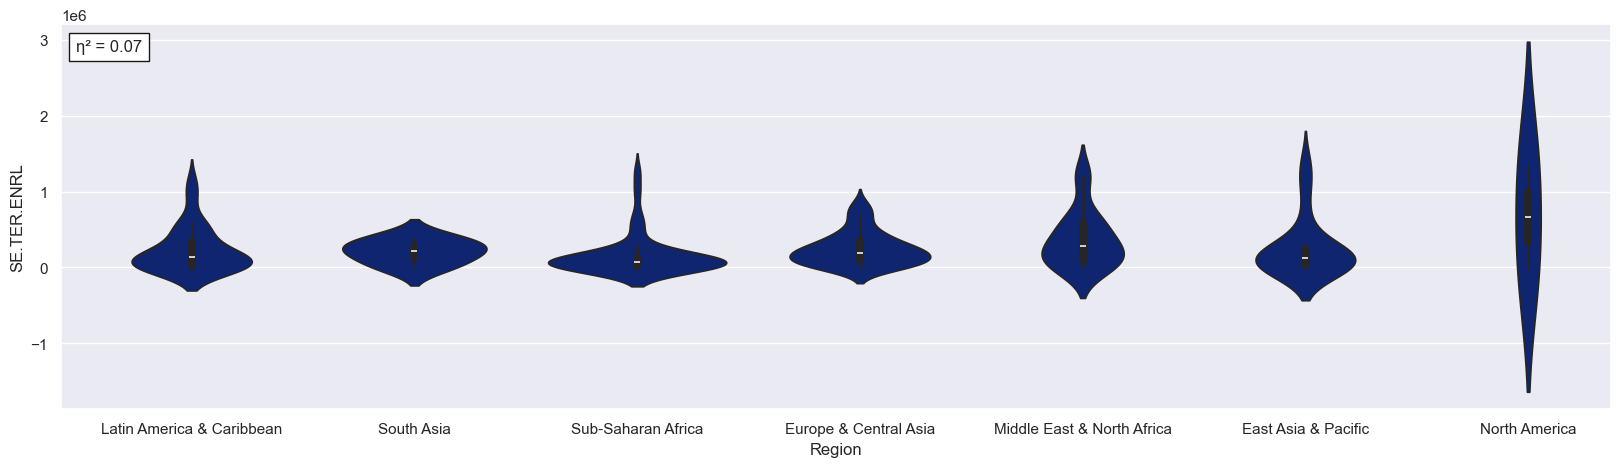

In [99]:
ANOVA(ed_stats_data, x="Income Group", y="SE.TER.ENRL", countries=countries_not_aggregates, inds=all_indicators, year="2012", plot_function=sns.violinplot, transforms=[remove_outliers], order=["Low income", "Lower middle income", "Upper middle income", "High income: nonOECD", "High income: OECD"])
ANOVA(ed_stats_data, x="Region", y="SE.TER.ENRL", countries=countries_not_aggregates, inds=all_indicators, year="2012", plot_function=sns.violinplot, transforms=[remove_outliers])

0 missing data points could not be estimated due to insufficient data.
Data could not be estimated on 23 missing data points because coefficient of variation was too high.
No data was estimated.


Country Code        Indicator Code Country Name  \
0               ARB            UIS.NERA.2   Arab World   
1               ARB          UIS.NERA.2.F   Arab World   
2               ARB        UIS.NERA.2.GPI   Arab World   
3               ARB          UIS.NERA.2.M   Arab World   
4               ARB           SE.PRM.TENR   Arab World   
...             ...                   ...          ...   
287265          ZWE      UIS.LP.AG15T24.M     Zimbabwe   
287266          ZWE     SE.ADT.1524.LT.ZS     Zimbabwe   
287267          ZWE  SE.ADT.1524.LT.FE.ZS     Zimbabwe   
287268          ZWE  SE.ADT.1524.LT.FM.ZS     Zimbabwe   
287269          ZWE  SE.ADT.1524.LT.MA.ZS     Zimbabwe   

                                                                 Indicator Name  \
0                  Adjusted net enrolment rate, lower secondary, both sexes (%)   
1                      Adjusted net enrolment rate, lower secondary, female (%)   
2       Adjusted net enrolment rate, lower secondary, gender parity index (GPI)   
3                        Adjusted net enrolment rate, lower secondary, male (%)   
4                          Adjusted net enrolment rate, primary, both sexes (%)   
...                                                                         ...   
287265                  Youth illiterate population, 15-24 years, male (number)   
287266              Youth literacy rate, population 15-24 years, both sexes (%)   
287267                  Youth literacy rate, population 15-24 years, female (%)   
287268   Youth literacy rate, population 15-24 years, gender parity index (GPI)   
287269                    Youth literacy rate, population 15-24 years, male (%)   

             1999       2000       2001       2002       2003       2004  ...  \
0             NaN        NaN        NaN        NaN        NaN        NaN  ...   
1             NaN        NaN        NaN        NaN        NaN        NaN  ...   
2             NaN        NaN        NaN        NaN        NaN        NaN  ...   
3             NaN        NaN        NaN        NaN        NaN        NaN  ...   
4       76.254318  77.245682  78.800522  80.051399  80.805389  81.607063  ...   
...           ...        ...        ...        ...        ...        ...  ...   
287265        NaN        NaN        NaN        NaN        NaN        NaN  ...   
287266        NaN        NaN        NaN        NaN        NaN        NaN  ...   
287267        NaN        NaN        NaN        NaN        NaN        NaN  ...   
287268        NaN        NaN        NaN        NaN        NaN        NaN  ...   
287269        NaN        NaN        NaN        NaN        NaN        NaN  ...   

             2009       2010          2011       2012      2013  \
0             NaN        NaN           NaN        NaN       NaN   
1             NaN        NaN           NaN        NaN       NaN   
2             NaN        NaN           NaN        NaN       NaN   
3             NaN        NaN           NaN        NaN       NaN   
4       84.195961  85.211998      85.24514  86.101669  85.51194   
...           ...        ...           ...        ...       ...   
287265        NaN        NaN  166679.00000        NaN       NaN   
287266        NaN        NaN      90.93070        NaN       NaN   
287267        NaN        NaN      92.12456        NaN       NaN   
287268        NaN        NaN       1.02828        NaN       NaN   
287269        NaN        NaN      89.59058        NaN       NaN   

                 2014  2015  Income Group              Region  isAggregate  
0                 NaN   NaN     Undefined           Undefined         True  
1                 NaN   NaN     Undefined           Undefined         True  
2                 NaN   NaN     Undefined           Undefined         True  
3                 NaN   NaN     Undefined           Undefined         True  
4           85.320152   NaN     Undefined           Undefined         True  
...               ...   ...           ...                 ...          ..

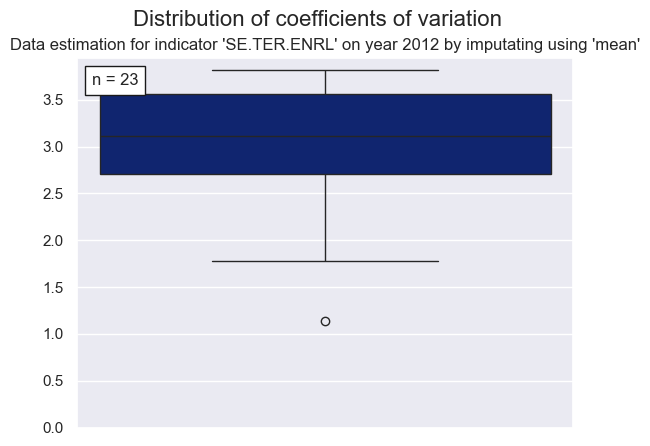

In [100]:
imputation(ed_stats_data, ind_to_estimate="SE.TER.ENRL", estimate_year="2012", group="Income Group", method=np.mean)

Coefficients of variation are really high and correlation with neither of the categories is sufficient. Precision would be low if missing data was estimated using imputation here. Given the fact that we have 88% of filled data, data will not be estimated further.

In [101]:
best_indicators_for_linreg = get_best_indicators_for_linreg(ed_stats_data, "UIS.E.5.B", all_indicators, "2012", countries_not_aggregates)
best_indicators_for_linreg.loc[best_indicators_for_linreg["Correlation (R²)"] >= 0.5].head(10)

c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation (R²)  Confidence  Efficiency  Outliers robustness  \
UIS.E.5.B                  1.00           1        0.00                 1.00   
UIS.E.5.B.F                0.96           1        0.00                 0.92   
UIS.E.23.PU.F              0.50           1        0.43                 0.82   
UIS.E.4.PU.F               0.67           1        0.10                 0.93   
UIS.G.5.B.T                0.83           1        0.05                 0.74   
UIS.T.4.F                  0.72           1        0.12                 0.77   
UIS.T.5.B                  0.61           1        0.04                 0.88   
UIS.T.4                    0.56           1        0.12                 0.84   
UIS.T.23.GPV               0.52           1        0.31                 0.63   
UIS.G.5.B.F                0.77           1        0.05                 0.63   

               Interest Score  
UIS.E.5.B                3.00  
UIS.E.5.B.F              2.88  
UIS.E.23.PU.F            2.76  
UIS.E.4.PU.F             2.71  
UIS.G.5.B.T              2.62  
UIS.T.4.F                2.61  
UIS.T.5.B                2.53  
UIS.T.4                  2.52  
UIS.T.23.GPV             2.46  
UIS.G.5.B.F              2.45

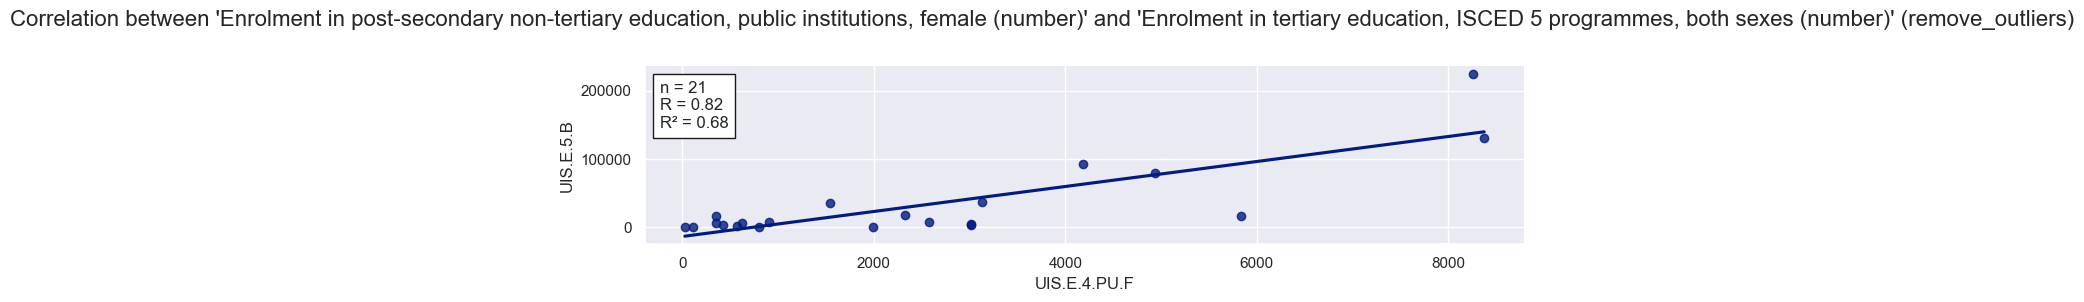

Successfully estimated data for indicator 'UIS.E.5.B' using 'UIS.E.4.PU.F' on 8 countries : 
'Cuba', 'St. Kitts and Nevis', 'Malawi', 'Rwanda', 'Serbia', 'Swaziland', 'Seychelles', 'St. Vincent and the Grenadines'


In [102]:
ed_stats_data = linreg(ed_stats_data, countries=countries_not_aggregates, ind_x="UIS.E.4.PU.F", ind_to_predict="UIS.E.5.B", years=["2012"], predict=True, transforms=[remove_outliers])

In [103]:
get_filled_data_percentage(ed_stats_data, inds=demo_score_inds, countries=countries_not_aggregates)

1999       2000       2001       2002       2003  \
Indicator Code                                                              
SE.SEC.ENRL         74.509804  74.019608  76.470588  75.980392  75.000000   
UIS.E.3             74.509804  74.019608  76.470588  75.980392  74.509804   
SE.TER.ENRL         68.627451  63.725490  62.745098  66.666667  68.137255   
UIS.E.5.B           48.039216  47.549020  45.588235  48.039216  50.490196   
UIS.E.4             41.176471  42.647059  44.117647  40.196078  40.686275   
UIS.EA.3T6.AG25T99   5.392157  11.764706  13.235294  10.294118   8.333333   

                         2004       2005       2006       2007       2008  \
Indicator Code                                                              
SE.SEC.ENRL         78.921569  81.372549  77.941176  81.372549  80.392157   
UIS.E.3             78.431373  80.882353  77.941176  81.372549  79.901961   
SE.TER.ENRL         67.647059  68.137255  69.607843  69.117647  72.549020   
UIS.E.5.B           50.000000  48.529412  45.588235  48.039216  50.980392   
UIS.E.4             40.196078  40.196078  36.764706  39.215686  39.705882   
UIS.EA.3T6.AG25T99  16.666667  18.627451  24.509804  28.431373  29.901961   

                         2009       2010       2011       2012       2013  \
Indicator Code                                                              
SE.SEC.ENRL         81.372549  80.392157  83.333333  99.509804  77.450980   
UIS.E.3             80.392157  79.411765  83.823529  92.647059  75.980392   
SE.TER.ENRL         72.549020  75.000000  76.470588  88.725490  73.529412   
UIS.E.5.B           50.980392  54.411765  55.392157  66.176471  49.019608   
UIS.E.4             40.686275  39.705882  40.686275  46.078431  44.117647   
UIS.EA.3T6.AG25T99  30.882353  37.745098  36.274510  34.313725  29.411765   

                         2014       2015  Mean Filled Percentage  
Indicator Code                                                    
SE.SEC.ENRL         75.490196  66.666667               78.835063  
UIS.E.3             64.215686  13.235294               74.336794  
SE.TER.ENRL         69.607843  62.745098               70.328720  
UIS.E.5.B           42.156863   6.862745               47.520185  
UIS.E.4             36.274510   6.862745               38.783160  
UIS.EA.3T6.AG25T99  31.862745  26.960784               23.212226

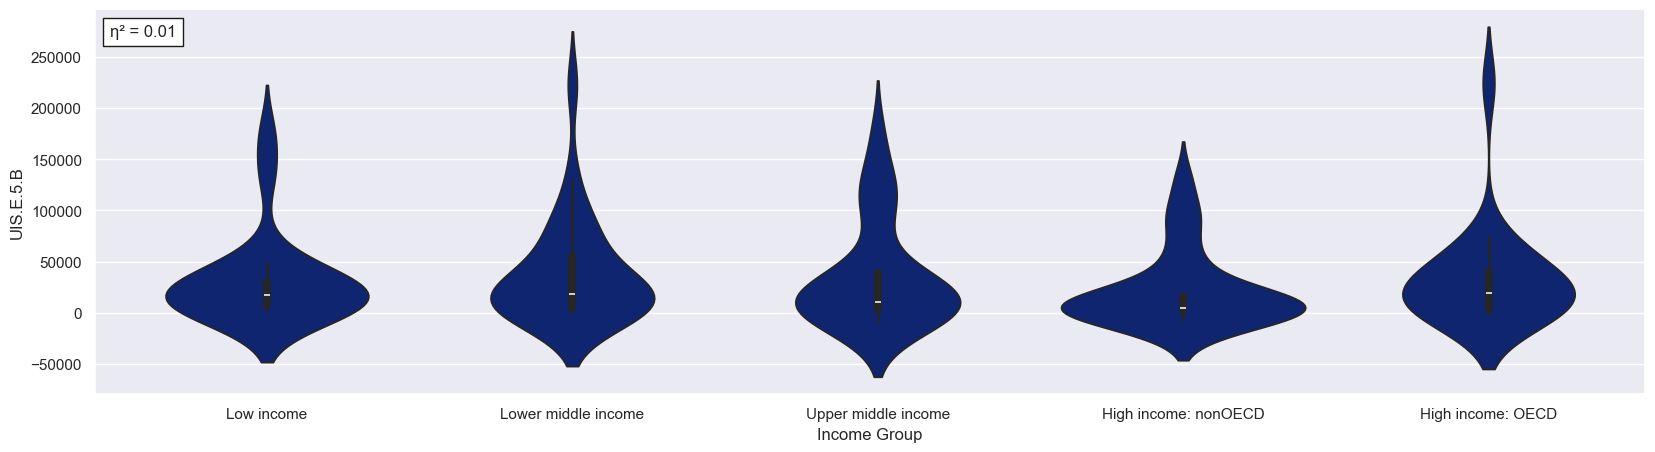

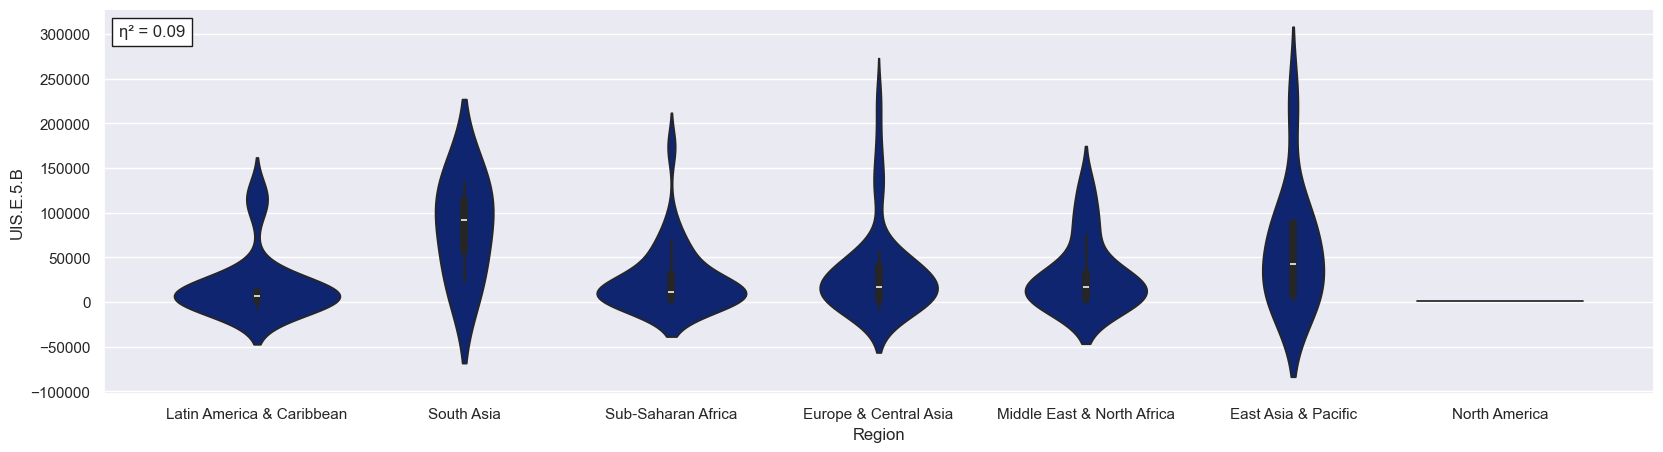

In [104]:
ANOVA(ed_stats_data, x="Income Group", y="UIS.E.5.B", countries=countries_not_aggregates, inds=all_indicators, year="2012", plot_function=sns.violinplot, transforms=[remove_outliers], order=["Low income", "Lower middle income", "Upper middle income", "High income: nonOECD", "High income: OECD"])
ANOVA(ed_stats_data, x="Region", y="UIS.E.5.B", countries=countries_not_aggregates, inds=all_indicators, year="2012", plot_function=sns.violinplot, transforms=[remove_outliers])

Correlation with neither of the categories is sufficient. Precision would be low if missing data was estimated using imputation here. We'll continue with only 66% of data for this indicator.

In [105]:
get_filled_data_percentage(ed_stats_data, inds=demo_score_inds, countries=countries_not_aggregates)

1999       2000       2001       2002       2003  \
Indicator Code                                                              
SE.SEC.ENRL         74.509804  74.019608  76.470588  75.980392  75.000000   
UIS.E.3             74.509804  74.019608  76.470588  75.980392  74.509804   
SE.TER.ENRL         68.627451  63.725490  62.745098  66.666667  68.137255   
UIS.E.5.B           48.039216  47.549020  45.588235  48.039216  50.490196   
UIS.E.4             41.176471  42.647059  44.117647  40.196078  40.686275   
UIS.EA.3T6.AG25T99   5.392157  11.764706  13.235294  10.294118   8.333333   

                         2004       2005       2006       2007       2008  \
Indicator Code                                                              
SE.SEC.ENRL         78.921569  81.372549  77.941176  81.372549  80.392157   
UIS.E.3             78.431373  80.882353  77.941176  81.372549  79.901961   
SE.TER.ENRL         67.647059  68.137255  69.607843  69.117647  72.549020   
UIS.E.5.B           50.000000  48.529412  45.588235  48.039216  50.980392   
UIS.E.4             40.196078  40.196078  36.764706  39.215686  39.705882   
UIS.EA.3T6.AG25T99  16.666667  18.627451  24.509804  28.431373  29.901961   

                         2009       2010       2011       2012       2013  \
Indicator Code                                                              
SE.SEC.ENRL         81.372549  80.392157  83.333333  99.509804  77.450980   
UIS.E.3             80.392157  79.411765  83.823529  92.647059  75.980392   
SE.TER.ENRL         72.549020  75.000000  76.470588  88.725490  73.529412   
UIS.E.5.B           50.980392  54.411765  55.392157  66.176471  49.019608   
UIS.E.4             40.686275  39.705882  40.686275  46.078431  44.117647   
UIS.EA.3T6.AG25T99  30.882353  37.745098  36.274510  34.313725  29.411765   

                         2014       2015  Mean Filled Percentage  
Indicator Code                                                    
SE.SEC.ENRL         75.490196  66.666667               78.835063  
UIS.E.3             64.215686  13.235294               74.336794  
SE.TER.ENRL         69.607843  62.745098               70.328720  
UIS.E.5.B           42.156863   6.862745               47.520185  
UIS.E.4             36.274510   6.862745               38.783160  
UIS.EA.3T6.AG25T99  31.862745  26.960784               23.212226

In [106]:
best_indicators_for_linreg = get_best_indicators_for_linreg(ed_stats_data, "UIS.E.4", all_indicators, "2012", countries_not_aggregates)
best_indicators_for_linreg.loc[best_indicators_for_linreg["Correlation (R²)"] >= 0.5].head(10)

c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation (R²)  Confidence  Efficiency  Outliers robustness  \
UIS.E.4                    1.00           1        0.00                 1.00   
UIS.E.4.F                  0.92           1        0.00                 0.88   
UIS.E.3.PU.F               0.61           1        0.41                 0.76   
UIS.E.4.PU                 0.72           1        0.01                 0.97   
UIS.E.23.PU.F              0.72           1        0.40                 0.30   
UIS.E.2.PU.F               0.61           1        0.45                 0.26   
UIS.T.4.F                  0.53           1        0.01                 0.69   
UIS.E.4.PR                 0.50           1        0.01                 0.35   
UIS.ECDP.1.M               0.58           0        0.24                -0.05   
UIS.ECDP.1.F               0.58           0        0.24                -0.08   

               Interest Score  
UIS.E.4                  3.00  
UIS.E.4.F                2.80  
UIS.E.3.PU.F             2.78  
UIS.E.4.PU               2.70  
UIS.E.23.PU.F            2.42  
UIS.E.2.PU.F             2.32  
UIS.T.4.F                2.23  
UIS.E.4.PR               1.87  
UIS.ECDP.1.M             0.76  
UIS.ECDP.1.F             0.74

UIS.E.3.PU.F would be the most relevant candidate to perform linear regression.  
However, outliers robustness is quite low, and this indicator has already been used to predict missing data for SE.TER.ENRL earlier.
Therefore, we consider there is no serious candidate to perform linear regression for UIS.E.4.

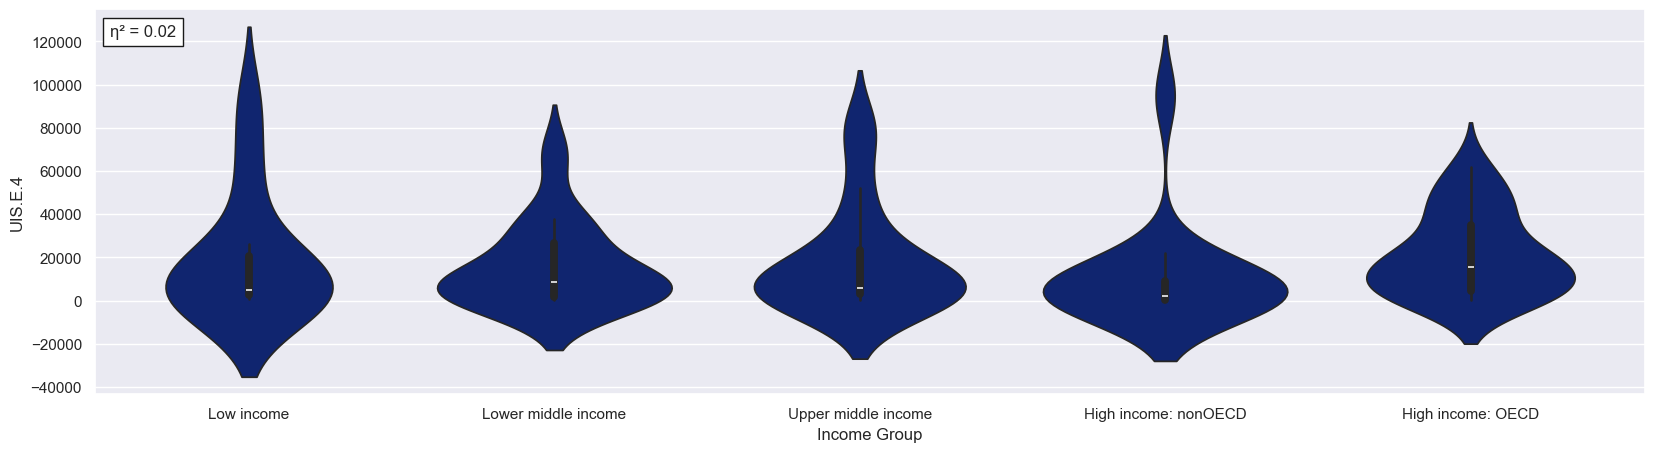

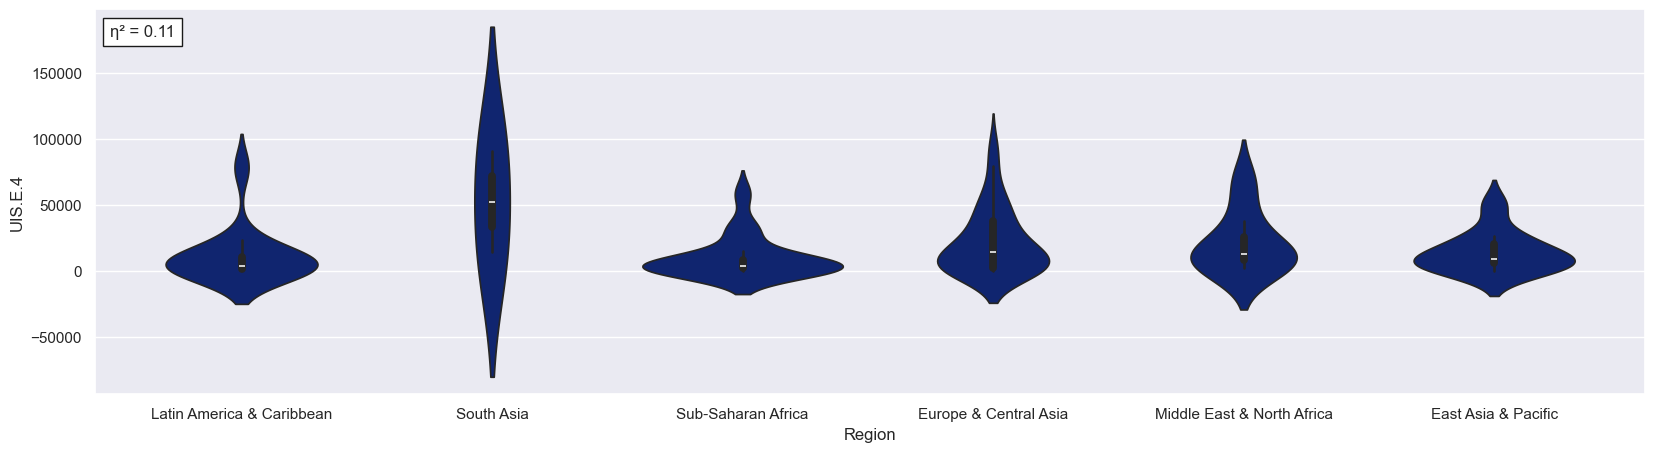

In [107]:
ANOVA(ed_stats_data, x="Income Group", y="UIS.E.4", countries=countries_not_aggregates, inds=all_indicators, year="2012", plot_function=sns.violinplot, transforms=[remove_outliers], order=["Low income", "Lower middle income", "Upper middle income", "High income: nonOECD", "High income: OECD"])
ANOVA(ed_stats_data, x="Region", y="UIS.E.4", countries=countries_not_aggregates, inds=all_indicators, year="2012", plot_function=sns.violinplot, transforms=[remove_outliers])

No correlation is considered robust enough to estimate the high percentage of missing data for "UIS.E.4". It will not be included in the rest of this analysis.

In [108]:
best_indicators_for_linreg = get_best_indicators_for_linreg(ed_stats_data, "UIS.EA.3T6.AG25T99", all_indicators, "2012", countries_not_aggregates)
best_indicators_for_linreg.head(10)

c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Git-OpenClassrooms\DS_2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation (R²)  Confidence  Efficiency  \
IT.NET.USER.P2                 0.58           1        0.95   
SP.POP.0014.TO.ZS              0.55           1        0.89   
SH.DYN.MORT                    0.41           1        0.93   
SE.PRM.TCHR.FE.ZS              0.58           1        0.61   
UIS.THDUR.0                    0.16           1        0.99   
SP.POP.GROW                    0.31           1        0.99   
UIS.THAGE.0                    0.20           1        0.99   
NY.GDP.PCAP.CD                 0.22           1        0.91   
NY.GNP.PCAP.CD                 0.23           1        0.87   
SE.PRM.DURS                    0.08           1        1.00   

                   Outliers robustness  Interest Score  
IT.NET.USER.P2                    1.00            3.53  
SP.POP.0014.TO.ZS                 1.00            3.44  
SH.DYN.MORT                       1.00            3.33  
SE.PRM.TCHR.FE.ZS                 1.00            3.19  
UIS.THDUR.0                       1.00            3.15  
SP.POP.GROW                       0.83            3.13  
UIS.THAGE.0                       0.90            3.09  
NY.GDP.PCAP.CD                    0.96            3.09  
NY.GNP.PCAP.CD                    0.98            3.08  
SE.PRM.DURS                       1.00            3.08

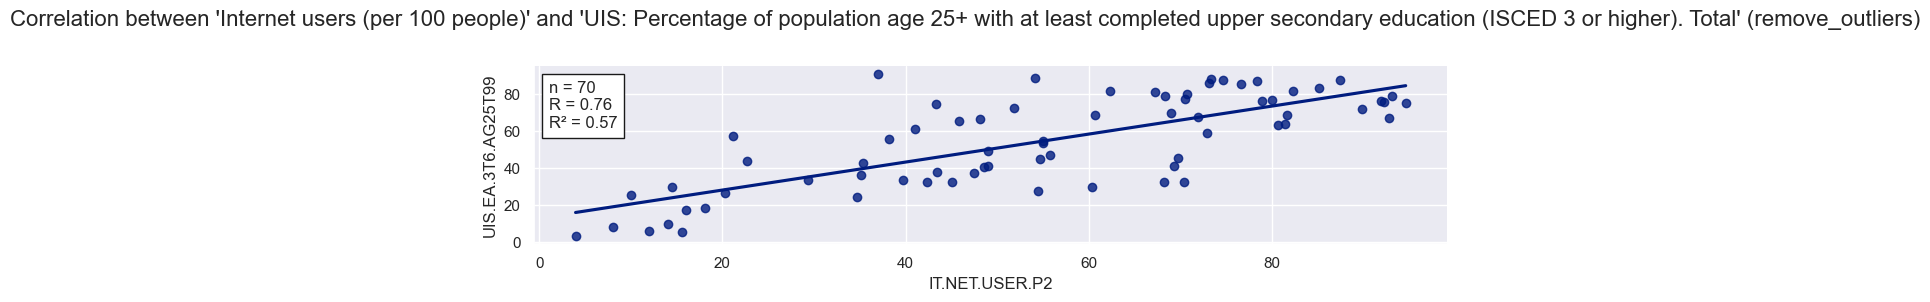

Successfully estimated data for indicator 'UIS.EA.3T6.AG25T99' using 'IT.NET.USER.P2' on 127 countries : 
'Aruba', 'Afghanistan', 'Angola', 'Andorra', 'United Arab Emirates', 'Argentina', 'Armenia', 'Antigua and Barbuda', 'Burundi', 'Benin', 'Burkina Faso', 'Bangladesh', 'Bahrain', 'Bahamas, The', 'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda', 'Barbados', 'Brunei Darussalam', 'Botswana', 'Central African Republic', 'Canada', 'China', 'Cote d'Ivoire', 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Comoros', 'Cabo Verde', 'Cayman Islands', 'Djibouti', 'Dominica', 'Algeria', 'Egypt, Arab Rep.', 'Eritrea', 'Ethiopia', 'Fiji', 'Micronesia, Fed. Sts.', 'Gabon', 'Ghana', 'Gibraltar', 'Guinea', 'Gambia, The', 'Guinea-Bissau', 'Equatorial Guinea', 'Grenada', 'Guyana', 'Croatia', 'Haiti', 'India', 'Ireland', 'Iraq', 'Iceland', 'Jamaica', 'Jordan', 'Japan', 'Kazakhstan', 'Kenya', 'Kyrgyz Republic', 'Cambodia', 'Kiribati', 'St. Kitts and Nevis', 'Korea, Rep.', 'Lao PDR', 'Lebanon', 'Li

In [109]:
ed_stats_data = linreg(ed_stats_data, countries=countries_not_aggregates, ind_x="IT.NET.USER.P2", ind_to_predict="UIS.EA.3T6.AG25T99", years=["2012"], predict=True, transforms=[remove_outliers])

In [110]:
get_filled_data_percentage(ed_stats_data, inds=demo_score_inds, countries=countries_not_aggregates)

1999       2000       2001       2002       2003  \
Indicator Code                                                              
SE.SEC.ENRL         74.509804  74.019608  76.470588  75.980392  75.000000   
UIS.E.3             74.509804  74.019608  76.470588  75.980392  74.509804   
SE.TER.ENRL         68.627451  63.725490  62.745098  66.666667  68.137255   
UIS.E.5.B           48.039216  47.549020  45.588235  48.039216  50.490196   
UIS.E.4             41.176471  42.647059  44.117647  40.196078  40.686275   
UIS.EA.3T6.AG25T99   5.392157  11.764706  13.235294  10.294118   8.333333   

                         2004       2005       2006       2007       2008  \
Indicator Code                                                              
SE.SEC.ENRL         78.921569  81.372549  77.941176  81.372549  80.392157   
UIS.E.3             78.431373  80.882353  77.941176  81.372549  79.901961   
SE.TER.ENRL         67.647059  68.137255  69.607843  69.117647  72.549020   
UIS.E.5.B           50.000000  48.529412  45.588235  48.039216  50.980392   
UIS.E.4             40.196078  40.196078  36.764706  39.215686  39.705882   
UIS.EA.3T6.AG25T99  16.666667  18.627451  24.509804  28.431373  29.901961   

                         2009       2010       2011       2012       2013  \
Indicator Code                                                              
SE.SEC.ENRL         81.372549  80.392157  83.333333  99.509804  77.450980   
UIS.E.3             80.392157  79.411765  83.823529  92.647059  75.980392   
SE.TER.ENRL         72.549020  75.000000  76.470588  88.725490  73.529412   
UIS.E.5.B           50.980392  54.411765  55.392157  66.176471  49.019608   
UIS.E.4             40.686275  39.705882  40.686275  46.078431  44.117647   
UIS.EA.3T6.AG25T99  30.882353  37.745098  36.274510  96.568627  29.411765   

                         2014       2015  Mean Filled Percentage  
Indicator Code                                                    
SE.SEC.ENRL         75.490196  66.666667               78.835063  
UIS.E.3             64.215686  13.235294               74.336794  
SE.TER.ENRL         69.607843  62.745098               70.328720  
UIS.E.5.B           42.156863   6.862745               47.520185  
UIS.E.4             36.274510   6.862745               38.783160  
UIS.EA.3T6.AG25T99  31.862745  26.960784               26.874279

Indicators "UIS.E.3", "SE.SEC.ENRL", "UIS.E.5.B", "SE.TER.ENRL" and "UIS.EA.3T6.AG25T99" will be used to to estimate the countries of greatest interest in terms of potential customers in any given year.

### Economic Score

Now that we have data for demographic score, let's focus on economy related indicators.

Here are relevant indicators to define Economic Score, based on their definition:

- NY.GDP.PCAP.CD
- NY.GDP.MKTP.CD

However, other GDP-related indicators might be more appropriate to represent the purchasing power of the population (like "GDP per capita, PPP (current international $)").  

Unfortunately, it seems there is no indicator on household spending on education.

In [111]:
eco_score_inds = ["NY.GDP.PCAP.CD", "NY.GDP.MKTP.CD"]
ed_stats_series.loc[ed_stats_series["Series Code"].isin(eco_score_inds), ["Series Code", "Topic", "Indicator Name"]]

Series Code  \
1658  NY.GDP.MKTP.CD   
1662  NY.GDP.PCAP.CD   

                                                                                       Topic  \
1658  Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators   
1662  Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators   

                    Indicator Name  
1658             GDP (current US$)  
1662  GDP per capita (current US$)

In [112]:
get_filled_data_percentage(ed_stats_data, inds=eco_score_inds, countries=countries_not_aggregates)

1999       2000       2001       2002       2003  \
Indicator Code                                                          
NY.GDP.MKTP.CD  92.647059  94.117647  95.098039  95.588235  95.588235   
NY.GDP.PCAP.CD  92.647059  94.117647  95.098039  95.588235  95.588235   

                     2004       2005       2006       2007       2008  \
Indicator Code                                                          
NY.GDP.MKTP.CD  96.078431  96.078431  96.568627  96.078431  96.078431   
NY.GDP.PCAP.CD  96.078431  96.078431  96.568627  96.078431  96.078431   

                     2009       2010       2011       2012       2013  \
Indicator Code                                                          
NY.GDP.MKTP.CD  95.588235  96.078431  96.078431  94.117647  94.607843   
NY.GDP.PCAP.CD  95.588235  96.078431  96.078431  94.117647  94.607843   

                     2014       2015  Mean Filled Percentage  
Indicator Code                                                
NY.GDP.MKTP.CD  93.137255  92.647059               95.069204  
NY.GDP.PCAP.CD  93.137255  92.647059               95.069204

Percentage of filled data already is high enough.  
Let's check if both indicators are closely correlated to each other.

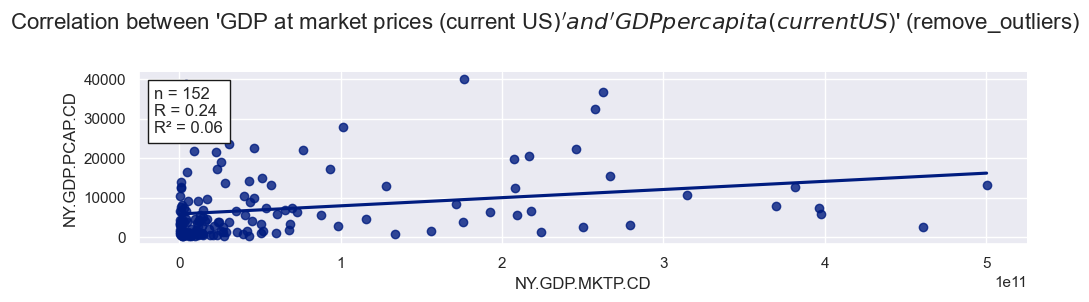

In [113]:
linreg(ed_stats_data, countries=countries_not_aggregates, ind_x="NY.GDP.MKTP.CD", ind_to_predict="NY.GDP.PCAP.CD", years=["2012"], predict=False, transforms=[remove_outliers])

Correlation is considered low enough to keep both indicators in this analysis.

Indicators "NY.GDP.MKTP.CD", "NY.GDP.PCAP.CD" will be used to to estimate the ability to pay for online training.

## Final Scores for most relevant year

In [114]:
# Weighted average of each score is done before summing all scores
demo_score_weights = {"UIS.E.3":3, "SE.SEC.ENRL":1, "UIS.E.5.B":2, "SE.TER.ENRL":1, "UIS.EA.3T6.AG25T99":3}
economic_score_weights = {"NY.GDP.PCAP.CD":2, "NY.GDP.MKTP.CD":1}

all_scores_inds = list(demo_score_weights.keys()) + list(economic_score_weights.keys())

print(all_scores_inds)

['UIS.E.3', 'SE.SEC.ENRL', 'UIS.E.5.B', 'SE.TER.ENRL', 'UIS.EA.3T6.AG25T99', 'NY.GDP.PCAP.CD', 'NY.GDP.MKTP.CD']


In [115]:
def maxmin(value, ind_values):
    '''
    Normalizes a value based on the min-max scaling method.

    Parameters:
    value (float): The value to normalize.
    ind_values (array-like): Array of indicator values for scaling.

    Returns:
    float: Normalized value between 0 and 1, or 0 if all values are the same.
    '''
    min_val = min(ind_values)[0]
    max_val = max(ind_values)[0]
    # Avoid division by zero
    if max_val != min_val:
        return (value - min_val) / (max_val - min_val)  # Calculate normalized value
    else:
        return 0  # Handle case where all values are the same

def rank(value, ind_values):
    '''
    Calculates the rank of a value relative to an array of indicator values.

    Parameters:
    value (float): The value to rank.
    ind_values (array-like): Array of indicator values for comparison.

    Returns:
    float: Rank of the value as a proportion of the total number of values.
    '''
    return np.sum(ind_values < value) / len(ind_values)  # Calculate rank

def calculate_country_score(inds_country_data, inds_data, ind_weights: dict, norm_method:Callable):
    '''
    Calculates a weighted score for a country based on normalized indicator values.

    Parameters:
    inds_country_data (pd.Series): Series of indicator values for the country.
    inds_data (pd.DataFrame): DataFrame of indicator values for all countries.
    ind_weights (dict): Dictionary of indicator weights.
    norm_method (Callable): Normalization method to apply.

    Returns:
    tuple: (score, confidence_score) rounded to two decimal places.
    '''
    # Initialize the score
    norm_values = []
    weights = []

    # Calculate normalized values for each indicator
    for ind, w in ind_weights.items():
        # Check if the indicator is in both the country data and the indicator data
        if ind in inds_country_data.index and not np.isnan(inds_country_data[ind]):
            # Get all data for the indicator
            ind_values = inds_data.loc[ind].values
            
            if len(ind_values) == 0:
                continue  # Handle case where there's no data for this indicator
            
            value = inds_country_data[ind]  # Get the value for this country and indicator
            
            norm_value = norm_method(value, ind_values)

            norm_values.append(norm_value)
            weights.append(w)

    total_weight_abs = sum(map(abs, ind_weights.values()))
    confidence_score = sum(map(abs, weights)) / total_weight_abs if total_weight_abs > 0 else 0
    
    if len(weights) == 0:
        score = 0
    elif sum(weights) != 0:
        score = np.dot(norm_values, weights) / sum(map(abs, weights))  # Perform weighted average
    else:
        raise ValueError('Sum of weights is 0. Cannot calculate weighted average.')
    
    return round(score, 2), round(confidence_score, 2)

In [116]:
def calculate_country_year_scores(inds_country_data, inds_data, demo_ind, economic_ind, norm_method:Callable):
    '''
    Calculates demographic and economic scores for a country based on its indicator data.

    Parameters:
    inds_country_data (pd.Series): Series of indicator values for the country.
    inds_data (pd.DataFrame): DataFrame of indicator values for all countries.
    demo_ind (dict): Dictionary of demographic indicator weights.
    economic_ind (dict): Dictionary of economic indicator weights.
    norm_method (Callable): Normalization method to apply.

    Returns:
    tuple: A list of scores for demographic and economic categories, and a list of corresponding confidence scores.
    '''
    # Calculate scores for each category
    demo_score, confidence_demo_score = calculate_country_score(inds_country_data, inds_data, demo_ind, norm_method)
    economic_score, confidence_economic_score = calculate_country_score(inds_country_data, inds_data, economic_ind, norm_method)
    
    return [demo_score, economic_score], [confidence_demo_score, confidence_economic_score]

In [117]:
def build_year_score_df(df:pd.DataFrame, year, countries: list, demo_ind=demo_score_weights, economic_ind=economic_score_weights, norm_method:Callable=rank):
    '''
    Builds a DataFrame of scores for specified countries and year based on demographic and economic indicators.

    Parameters:
    df (pd.DataFrame): Data used to build the scores.
    year (int): The year for which scores are calculated.
    countries (list): List of country codes to include.
    demo_ind (dict): Dictionary of demographic indicator weights. Defaults to demo_score_weights.
    economic_ind (dict): Dictionary of economic indicator weights. Defaults to economic_score_weights.
    norm_method (Callable): Normalization method to apply. Defaults to rank.

    Returns:
    pd.DataFrame: DataFrame containing country names, scores, and confidence scores.
    '''
    year_score_data = []
    
    # Combine all indicator weights into a single list
    all_scores_inds = (
        list(demo_ind.keys()) + 
        list(economic_ind.keys())
    )

    # Filter relevant indicators data for the specified country and year
    inds_data = df.loc[df["Indicator Code"].isin(all_scores_inds) & df["Country Code"].isin(countries), ["Indicator Code", "Country Code", str(year)]].set_index("Indicator Code")

    for country in countries:
        # Extract country data for the specified year
        try:
            inds_country_data = inds_data.loc[inds_data["Country Code"] == country, str(year)].squeeze()  # Use squeeze to convert DataFrame to Series
        except KeyError:
            continue  # Skip if country data not found
        
        scores, confidence_scores = calculate_country_year_scores(
            inds_country_data,
            inds_data.drop(columns="Country Code"),
            demo_ind=demo_ind,
            economic_ind=economic_ind,
            norm_method=norm_method
        )

        total_confidence_score = round(np.mean(confidence_scores), 2)
        total_score = round(sum(scores), 2)

        country_name = ed_stats_country.loc[ed_stats_country["Country Code"] == country, "Short Name"].values[0]
        
        year_score_data.append([country_name] + scores + [total_score, total_confidence_score])
    
    # Create DataFrame from the collected scores
    year_score_df = pd.DataFrame(year_score_data, columns=["Country Name", "Demo Score", "Economic Score", "Total Score", "Confidence Score"])

    # Display boxplot of Confidence scores
    fig, ax = plt.subplots()
    sns.boxplot(year_score_df['Confidence Score'], ax=ax)
    ax.set_ylim([0,1])
    ax.set_title("Distribution of confidence scores")
    plt.show()
    
    return year_score_df


Scores built using normalization method "maxmin" are actually highly impacted by extreme values. Therefore, "rank" (or centile) method will be used here.

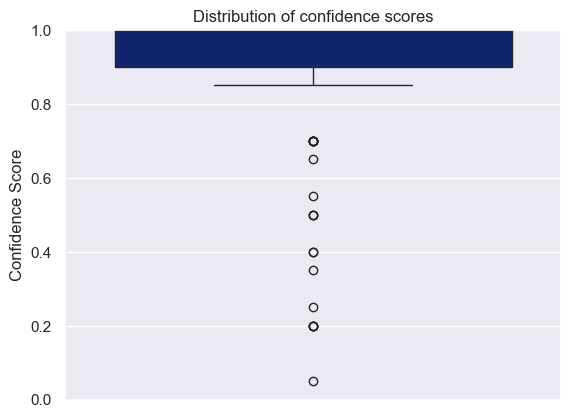

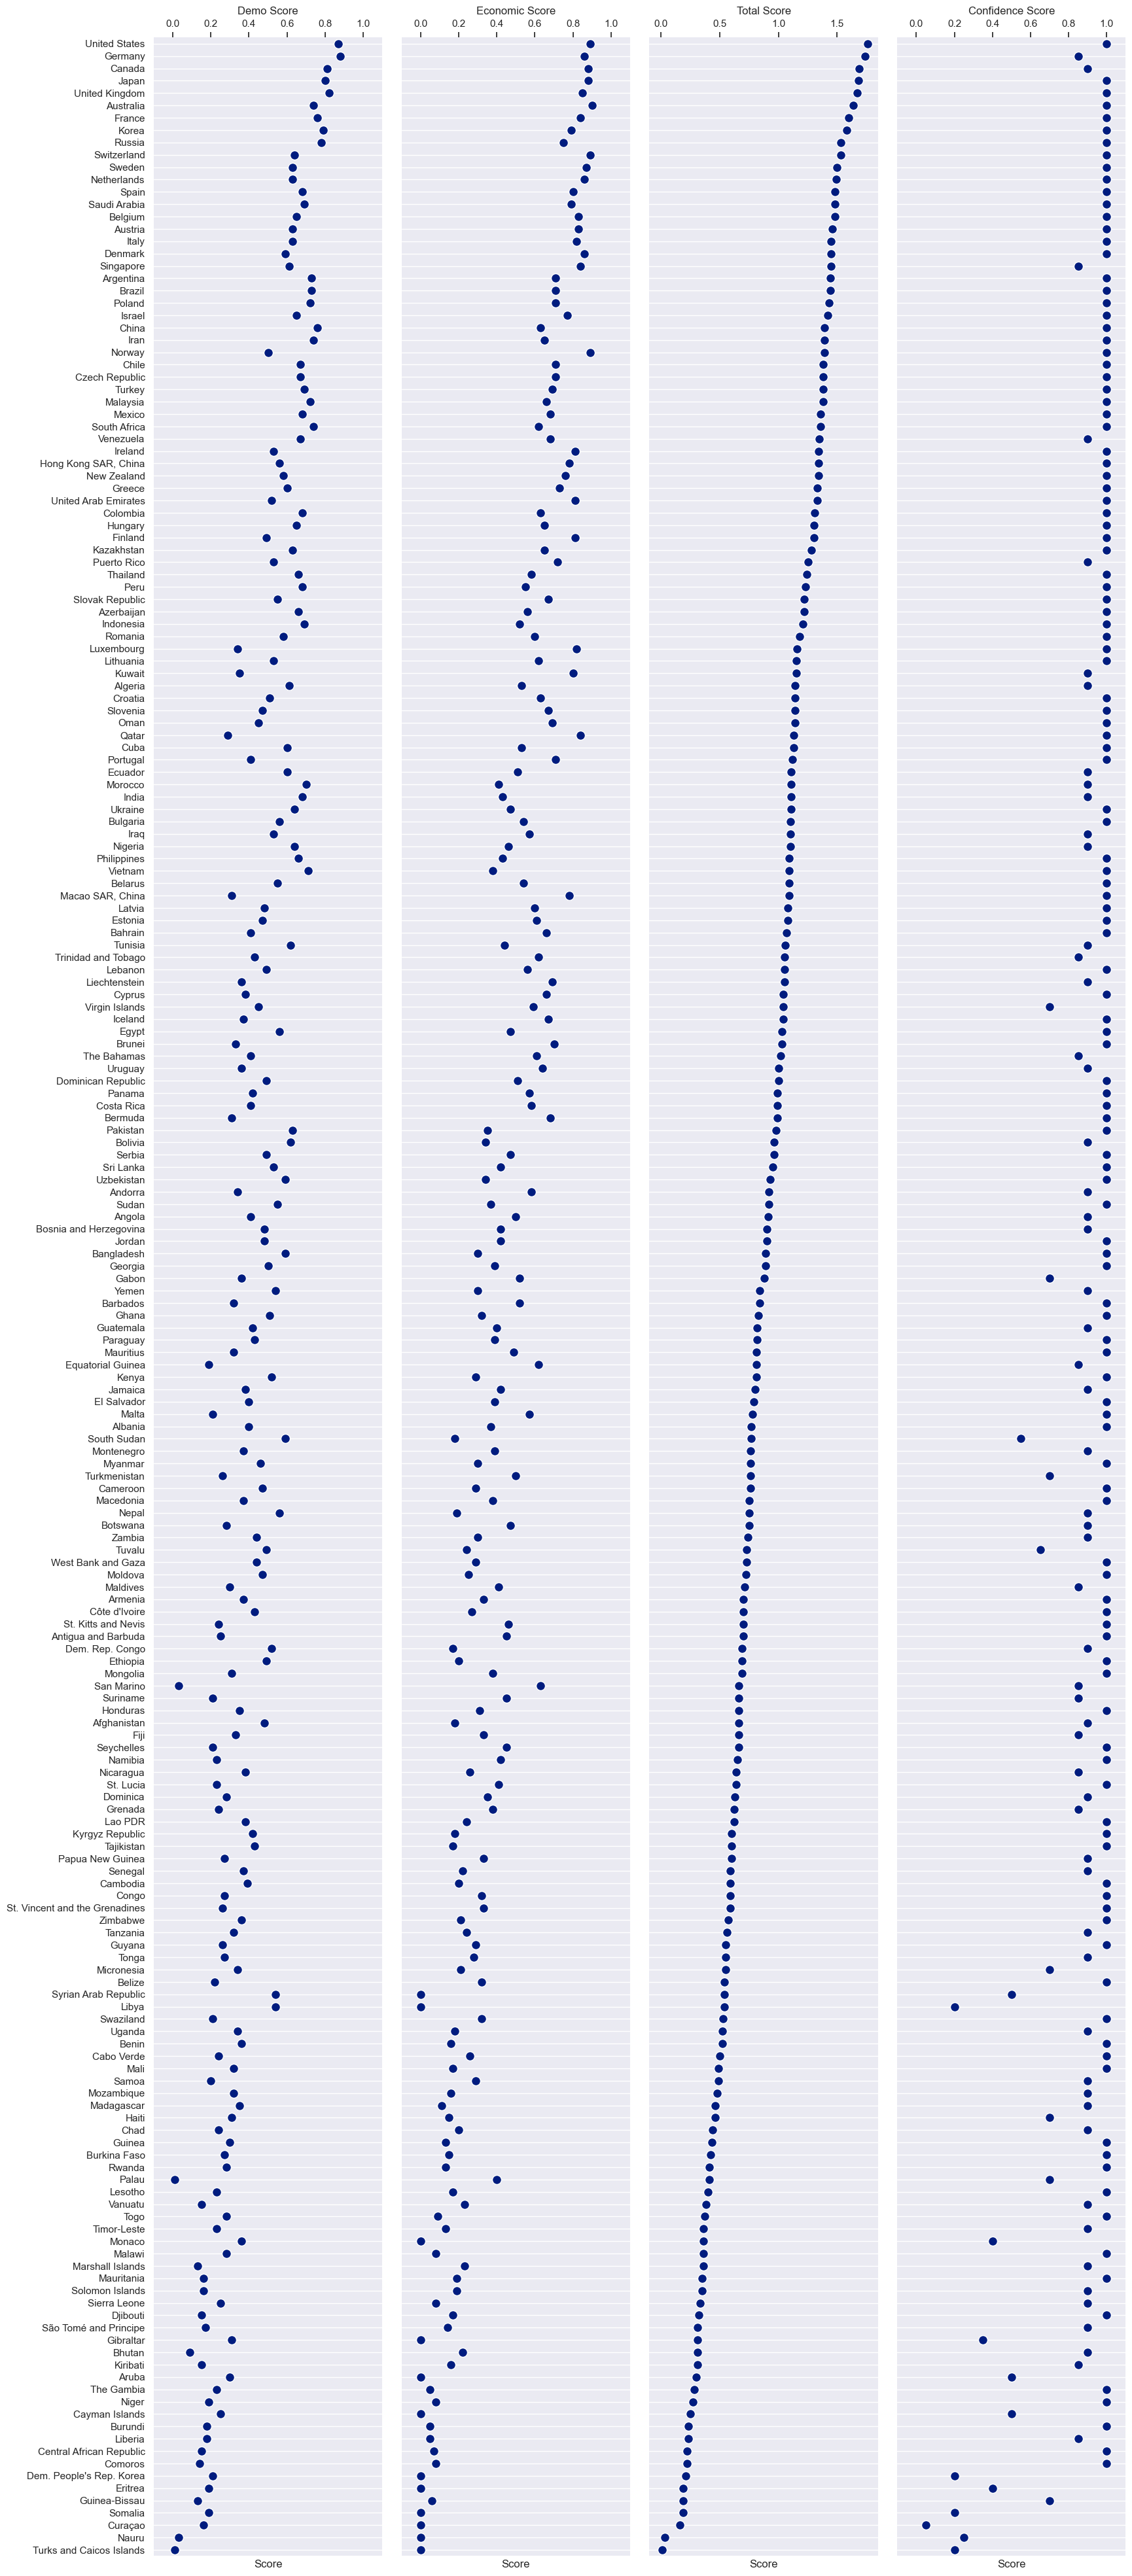

In [118]:
year_score_2012 = build_year_score_df(ed_stats_data, year='2012', countries=countries_not_aggregates).sort_values(by="Total Score", ascending=False)
# Make the PairGrid
g = sns.PairGrid(year_score_2012,
                 x_vars=year_score_2012.columns[1:], y_vars=["Country Name"],
                 height=40, aspect=0.1)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlabel="Score", ylabel="")

# Use semantically meaningful titles for the columns
titles = year_score_2012.columns[1:]

lims_by_col = {'Demo Score': [-0.1,1.1], 'Economic Score': [-0.1,1.1], 'Total Score': [-0.1,None], 'Confidence Score': [-0.1,1.1]}

for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)

    ax.set_xlim(lims_by_col[title])

    # Set X axis position to top of graph
    ax.xaxis.set_ticks_position("top")

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

## Predictions for 2025

Let's only keep top 25 countries from this result for the prediction on future years.

In [120]:
top25_year_score = year_score_2012[0:25]
relevant_countries_for_prediction = top25_year_score.loc[:, "Country Name"].values.tolist()
relevant_countries_for_prediction

['United States',
 'Germany',
 'Canada',
 'Japan',
 'United Kingdom',
 'Australia',
 'France',
 'Korea',
 'Russia',
 'Switzerland',
 'Sweden',
 'Netherlands',
 'Spain',
 'Saudi Arabia',
 'Belgium',
 'Austria',
 'Italy',
 'Denmark',
 'Singapore',
 'Argentina',
 'Brazil',
 'Poland',
 'Israel',
 'China',
 'Iran']

In [121]:
# Convert country names back to country codes 
relevant_country_codes_for_prediction = ed_stats_country.loc[ed_stats_country["Short Name"].isin(relevant_countries_for_prediction), "Country Code"].values.tolist()

Predicting data for indicator 'UIS.E.3'.
1 correlation coefficients were not calculated due to lack of data.
Data cannot be predicted on 11 missing data points due to insufficient correlation.
Successfully estimated data for indicator 'UIS.E.3' using 'Year' on 10 countries : 
'Argentina', 'Switzerland', 'Denmark', 'Iran, Islamic Rep.', 'Italy', 'Japan', 'Netherlands', 'Poland', 'Russian Federation', 'Saudi Arabia'
******************************
Predicting data for indicator 'SE.SEC.ENRL'.
1 correlation coefficients were not calculated due to lack of data.
Data cannot be predicted on 8 missing data points due to insufficient correlation.
Successfully estimated data for indicator 'SE.SEC.ENRL' using 'Year' on 13 countries : 
'Argentina', 'Canada', 'Switzerland', 'Germany', 'Denmark', 'Iran, Islamic Rep.', 'Israel', 'Italy', 'Japan', 'Netherlands', 'Poland', 'Russian Federation', 'Saudi Arabia'
******************************
Predicting data for indicator 'UIS.E.5.B'.
1 correlation coeffic

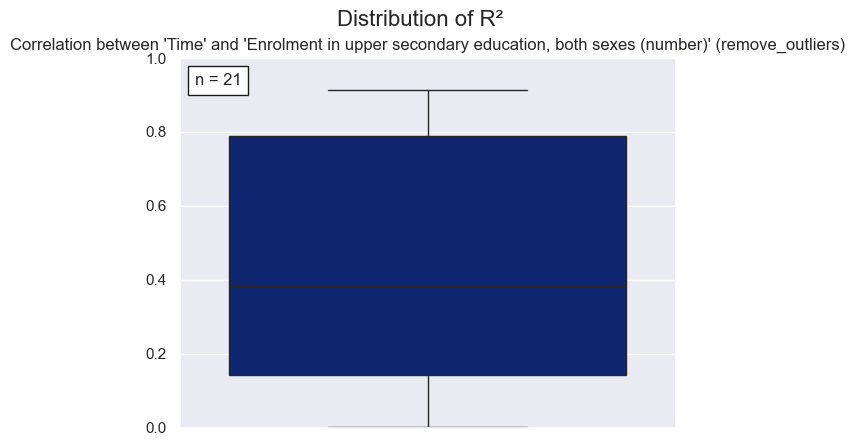

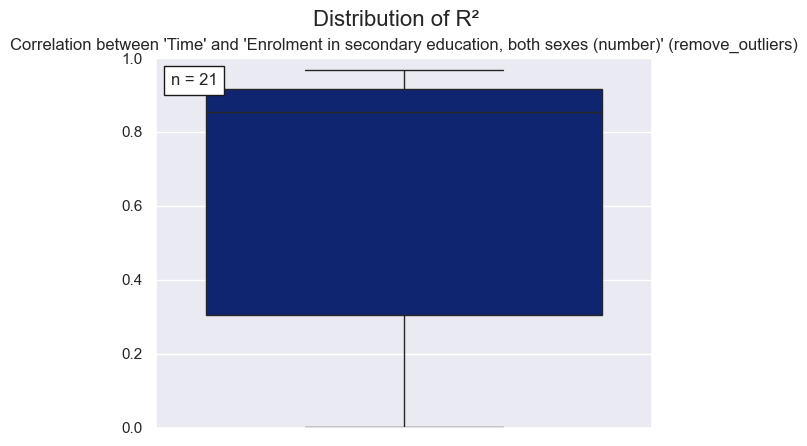

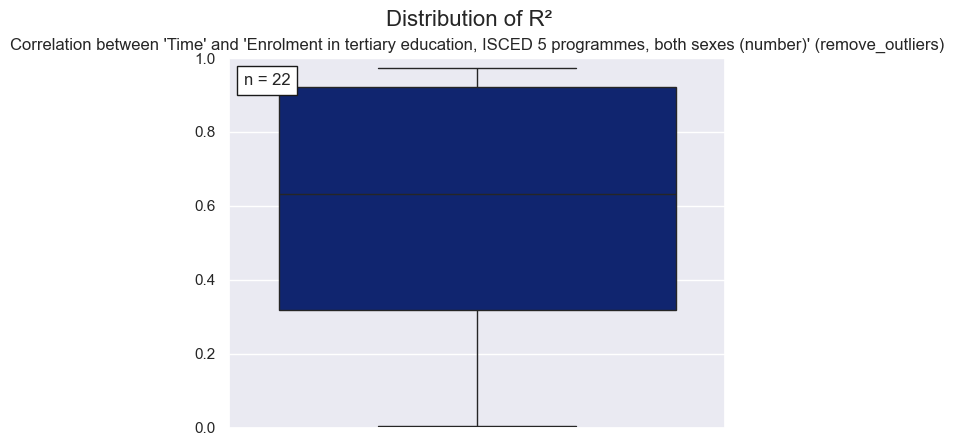

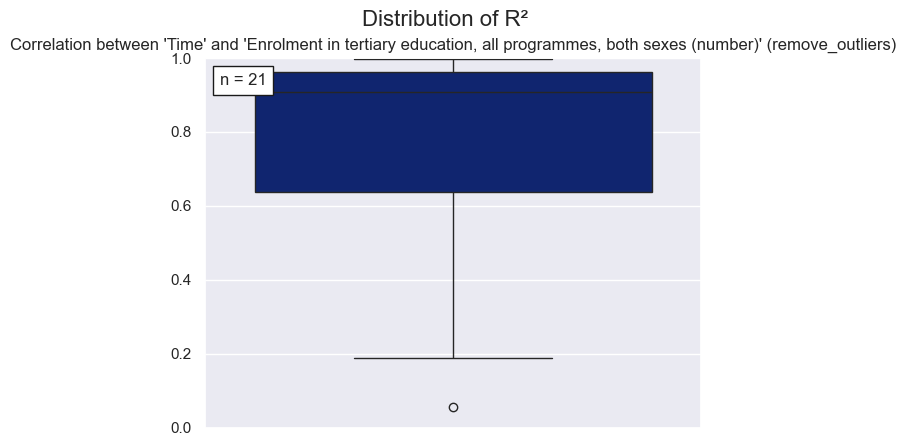

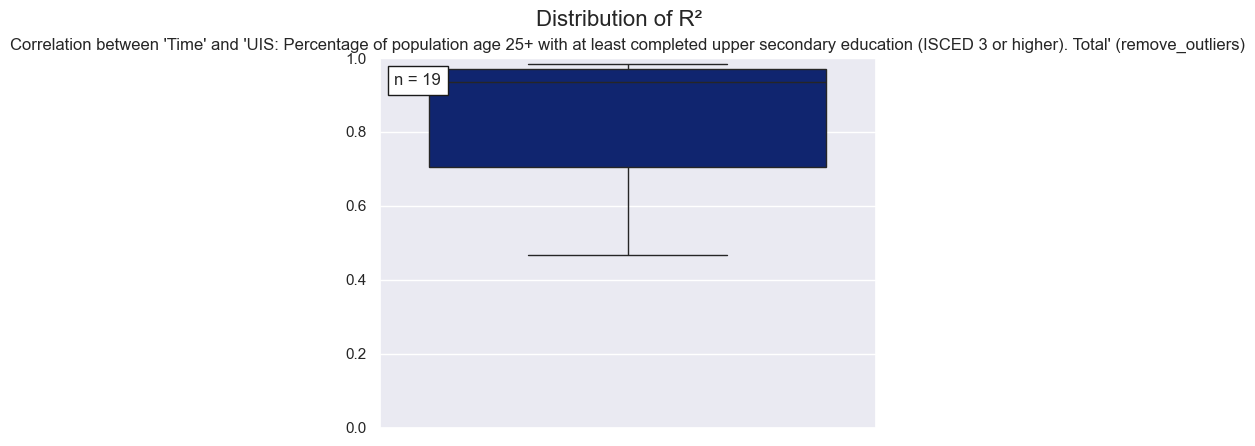

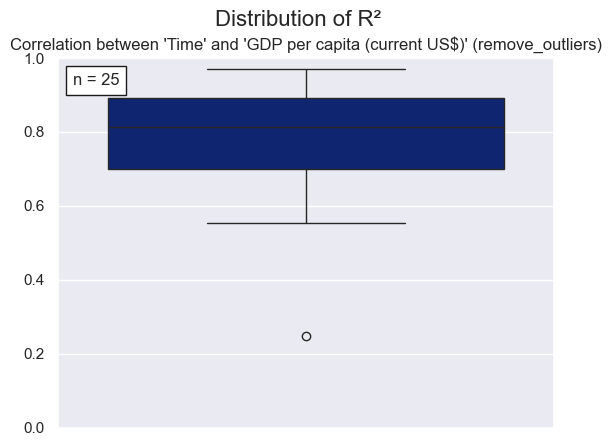

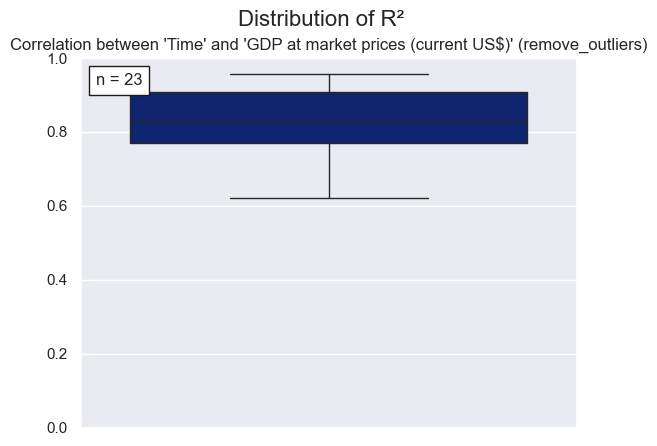

In [122]:
# Visualize correlation between Time and each indicator for each top25 country.
# Also predicts values accordingly if data quality criteria are met
# R² coefficient can actually be impacted here by previous estimation made in 2012 using the same method.
# However, data was only predicted for countries presenting an R² coefficient higher than 0.5.
# Since criteria is the same here, this will actually not impact the amount of predicted data.
for ind in all_scores_inds:
    print(f"Predicting data for indicator '{ind}'.")
    ed_stats_data = linreg(ed_stats_data, countries=relevant_country_codes_for_prediction, ind_to_predict=ind, years=[str(y) for y in range(1999, 2026)], row="Country Code", predict=True, display=False, transforms=[remove_outliers], legend=None)
    print(f"{'*'*30}")

Estimating data for indicator 'UIS.E.3'.
1 missing data points could not be estimated due to insufficient data.
Data could not be estimated on 0 missing data points because coefficient of variation was too high.
Successfully estimated data for indicator 'UIS.E.3' on year 2025 by imputating using 'mean' on 14 countries :
Australia, Austria, Canada, France, United States, Spain, United Kingdom, Germany, Brazil, Korea, Rep., Israel, Sweden, Belgium, China
******************************
Estimating data for indicator 'SE.SEC.ENRL'.
1 missing data points could not be estimated due to insufficient data.
Data could not be estimated on 0 missing data points because coefficient of variation was too high.
Successfully estimated data for indicator 'SE.SEC.ENRL' on year 2025 by imputating using 'mean' on 11 countries :
Australia, Austria, France, United States, Spain, United Kingdom, Brazil, Korea, Rep., Sweden, Belgium, China
******************************
Estimating data for indicator 'UIS.E.5.B'

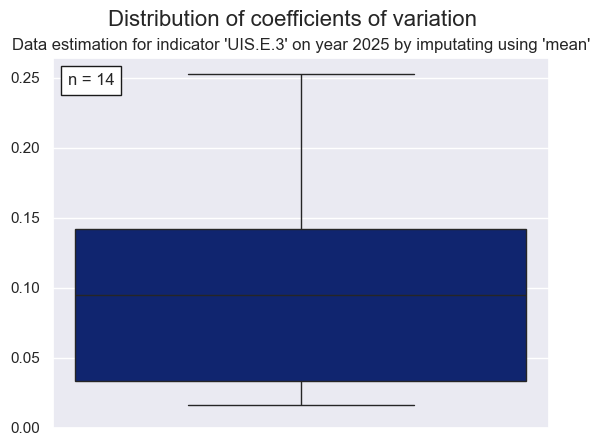

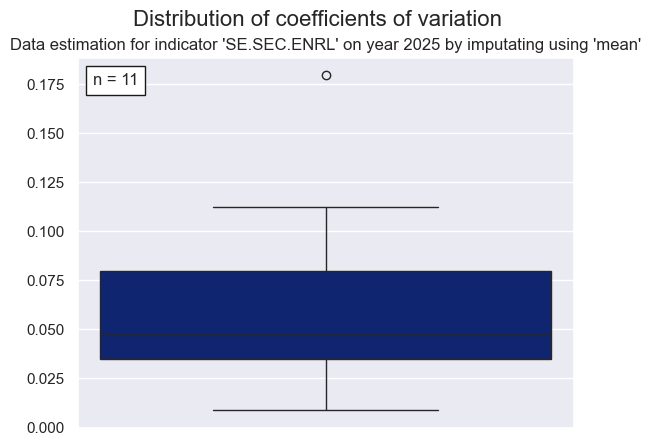

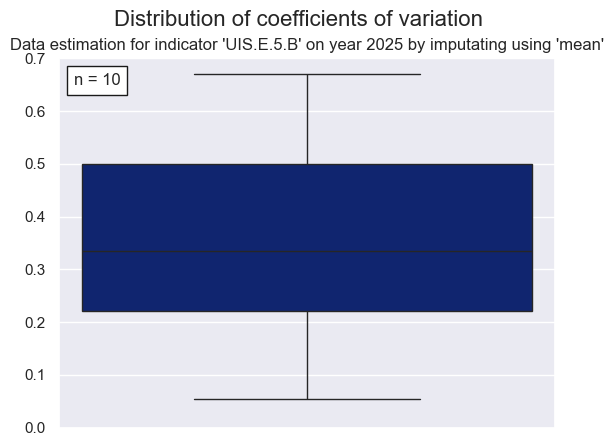

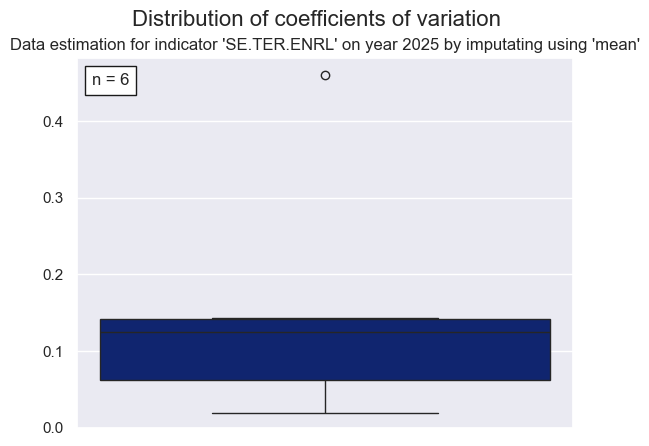

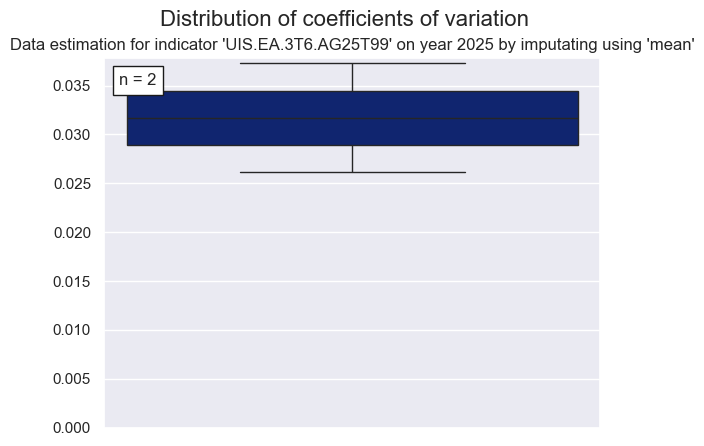

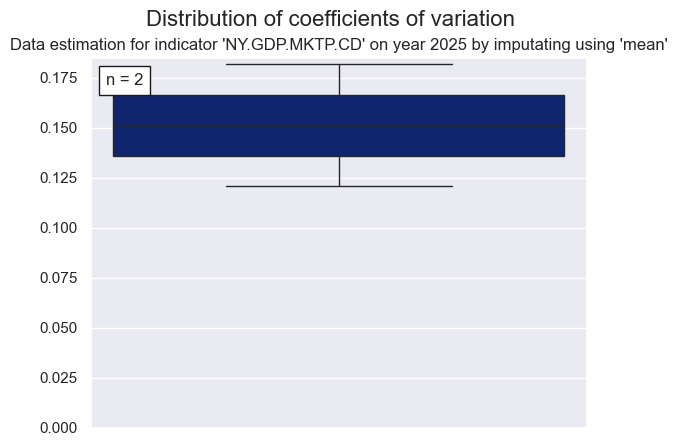

In [123]:
# Visualize variation over time and each indicator for each top25 country.
# Also imputes values accordingly if data quality criteria are met
# Coefficient of variation can actually be impacted here by previous estimation made in 2012 using the same method.
# However, data was only predicted for countries presenting a CV coefficient lower than 0.3.
# Since criteria is the same here, this will actually not impact the amount of estimated data.
for ind in all_scores_inds:
    print(f"Estimating data for indicator '{ind}'.")
    ed_stats_data = imputation(ed_stats_data, ind_to_estimate=ind, estimate_year="2025", data_years=[str(y) for y in range(1999, 2016)], countries=relevant_country_codes_for_prediction, group="Country Code")
    print(f"{'*'*30}")

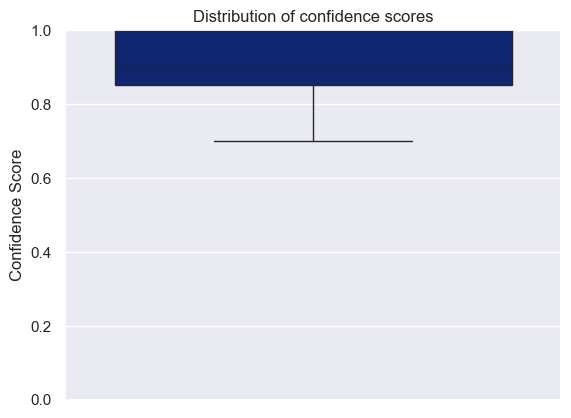

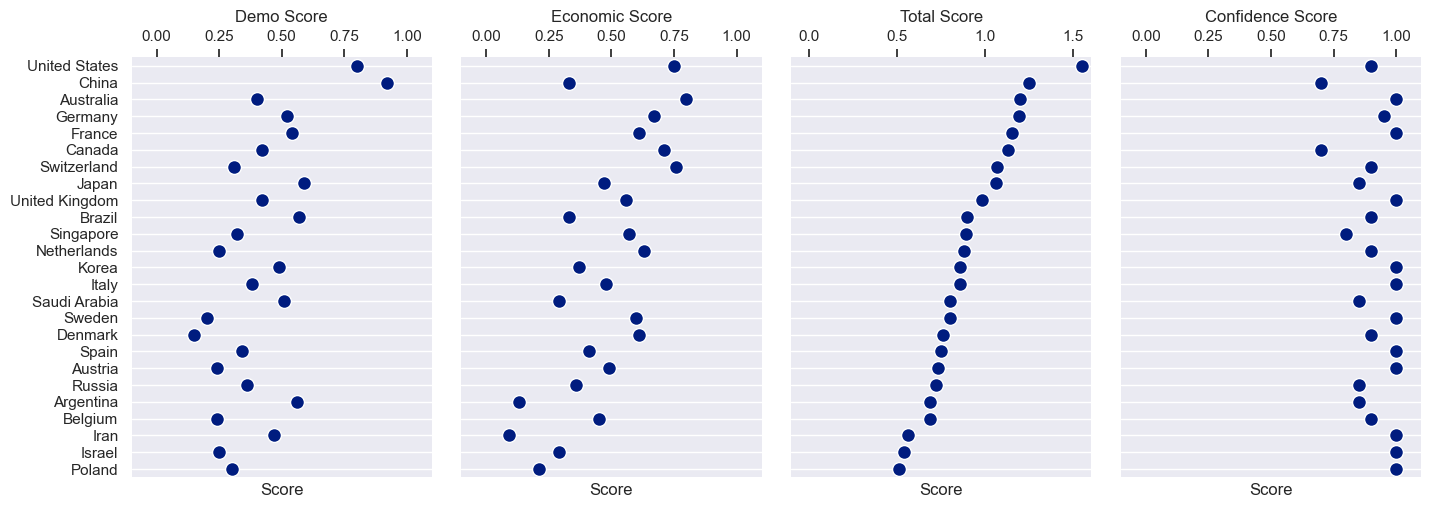

In [124]:
year_score_2025 = build_year_score_df(ed_stats_data, year='2025', countries=relevant_country_codes_for_prediction).sort_values(by="Total Score", ascending=False)
# Make the PairGrid
g = sns.PairGrid(year_score_2025,
                 x_vars=year_score_2025.columns[1:], y_vars=["Country Name"],
                 height=5, aspect=0.7)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="dark", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlabel="Score", ylabel="")

# Use semantically meaningful titles for the columns
titles = year_score_2025.columns[1:]

lims_by_col = {'Demo Score': [-0.1,1.1], 'Economic Score': [-0.1,1.1], 'Total Score': [-0.1,None], 'Confidence Score': [-0.1,1.1]}

for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)

    ax.set_xlim(lims_by_col[title])
    # Set X axis position to top of graph
    ax.xaxis.set_ticks_position("top")

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

## Annexes

In [125]:
def create_or_replace_ind(df:pd.DataFrame, name_new_ind, code_new_ind, expr):
    """
    Create a new indicator for each country and every year based on expr (containg operations on other indicators).
    
    Parameters:
    df (pd.DataFrame): The input dataframe containing indicators data.
    name_new_ind (str): The name of the new indicator.
    code_new_ind (str): The code of the new indicator.
    expr (str): The expression to calculate the new indicator.
    
    Returns:
    pd.DataFrame: The dataframe with the new indicator added.
    
    Example usage:
    df = create_new_ind(df, 'New Indicator', 'NEW_IND_CODE', 'Indicator1 + Indicator2')
    """
    df_copy = df.copy()

    # Remove the existing indicator if it exists
    df_copy = df_copy.loc[df_copy['Indicator Code'] != code_new_ind, :]

    # Function to apply the expression to each group
    def apply_expr(group:pd.DataFrame):
        # Replace dots with underscores to prevent eval from interpreting it
        safe_expr = expr.replace('.', '_')
        group[code_new_ind] = group.eval(safe_expr).round(2)

        return group
    
    df_pivoted= melt_and_pivot_df(df_copy)

    # Replace dots with underscores in column names to prevent eval from interpreting it
    df_pivoted.columns = df_pivoted.columns.str.replace('.', '_')

    # Group by Year and apply the expression
    df_grouped = df_pivoted.groupby('Year').apply(apply_expr, include_groups=False).reset_index()

    # Restore original column names
    df_grouped.columns = df_grouped.columns.str.replace('_', '.')

    # Filter the DataFrame to keep only the created indicator
    non_number_columns_grouped = df_grouped.select_dtypes(exclude=[np.number]).columns.tolist()
    new_ind_df = df_grouped.loc[:, non_number_columns_grouped + [code_new_ind]]

    # Restore the original shape of the input DataFrame
    new_ind_df_grouped = new_ind_df.groupby([c for c in new_ind_df if c not in [code_new_ind]])[code_new_ind].sum(min_count=1)
    new_ind_df_unstacked = new_ind_df_grouped.unstack('Year').reset_index()
    
    # Add "Indicator Name" and "Indicator Code" columns.
    new_ind_df_unstacked["Indicator Code"] = code_new_ind
    new_ind_df_unstacked['Indicator Name'] = name_new_ind

    # Append the new indicator to the original dataframe
    df_final = pd.concat([df_copy, new_ind_df_unstacked], ignore_index=True)
    
    return df_final
